# Using LSTMs for Stock Market Prediction

## EE 782 Assignment 1
## Name : Rohan Rajesh Kalbag
## Roll: 20D170033



## Using Kaggle API for frequent and fast download of Dataset, unable to use mounting GDrive after restrictions added by CC on Google Services

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!wget https://rohankalbag.github.io/kaggle.json
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d rohanrkalbag/ee782

--2023-09-17 13:52:29--  https://rohankalbag.github.io/kaggle.json
Resolving rohankalbag.github.io (rohankalbag.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rohankalbag.github.io (rohankalbag.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68 [application/json]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      68  --.-KB/s    in 0s      

2023-09-17 13:52:29 (1.84 MB/s) - ‘kaggle.json’ saved [68/68]

ref                                                        title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                    Most Streamed Spotify Songs 2023                    47

In [2]:
# include libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import torch

### Chosen Stocks

In [3]:
# choose the stocks which want to be included for processing later
chosen_stocks = ['AMD', 'ADBE', 'AAPL', 'AMZN']

import zipfile

zip_file_path = './ee782.zip'

output_directory = './'

# Open the .zip file and selectively extract the files corresponding to these stocks
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file_name in chosen_stocks:
        try:
            zip_ref.extract('sp500_tickers_A-D_1min_1pppix/%s_1min.txt' % file_name, output_directory)
            print(f'Extracted {file_name} to {output_directory}')
        except KeyError:
            print(f'File {file_name} not found in the archive.')

print('Unzip process completed.')

Extracted AMD to ./
Extracted ADBE to ./
Extracted AAPL to ./
Extracted AMZN to ./
Unzip process completed.


## 1a) Minute by Minute Closing Price for a Few Stocks

In [4]:
def get_subset_of_dataset(stockname, start_date, end_date):
    # function which returns a subset of data, given start and end date, and stock name
    filename = 'sp500_tickers_A-D_1min_1pppix/%s_1min.txt' % stockname
    df = pd.read_csv(filename, header=0, names=["datetime", "open", "high", "low", "close", "volume"]) # add column names
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S') # convert to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    df = df[(df['datetime'] < end_date) & (df['datetime'] >= start_date)] # obtain subset from start date to end date
    return df

def visualize_stock_prices_min(df, title):
    fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharex=True)
    column_names=['open', 'close', 'high', 'low']

    for i, col_name in enumerate(column_names):
      axes[0].plot(df['datetime'], df[col_name], '-s', label=col_name)

    # visualize minute wise stocks prices in one subplot
    axes[0].set_title("Stock Prices")
    dtFmt = mdates.DateFormatter('%Y-%m-%d %H:%M')
    axes[0].xaxis.set_major_formatter(dtFmt)
    axes[0].xaxis.set_tick_params(rotation=90, labelsize='x-small')
    axes[0].legend(loc='upper left')

    # visualize minute wise volumes in the other subplot
    axes[1].plot(df['datetime'], df['volume'], '-s', label='volume')
    axes[1].set_title("Volume of Stock Traded")
    dtFmt = mdates.DateFormatter('%Y-%m-%d %H:%M')
    axes[1].xaxis.set_major_formatter(dtFmt)
    axes[1].xaxis.set_tick_params(rotation=90, labelsize='x-small')
    axes[1].legend(loc='upper left')

    plt.xlabel("timestamp")
    plt.suptitle(title, fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust subplot layout
    plt.show()

### Let us print for the case of January 3rd 2020 from 12:00 pm to 12:30 pm for each of the stocks

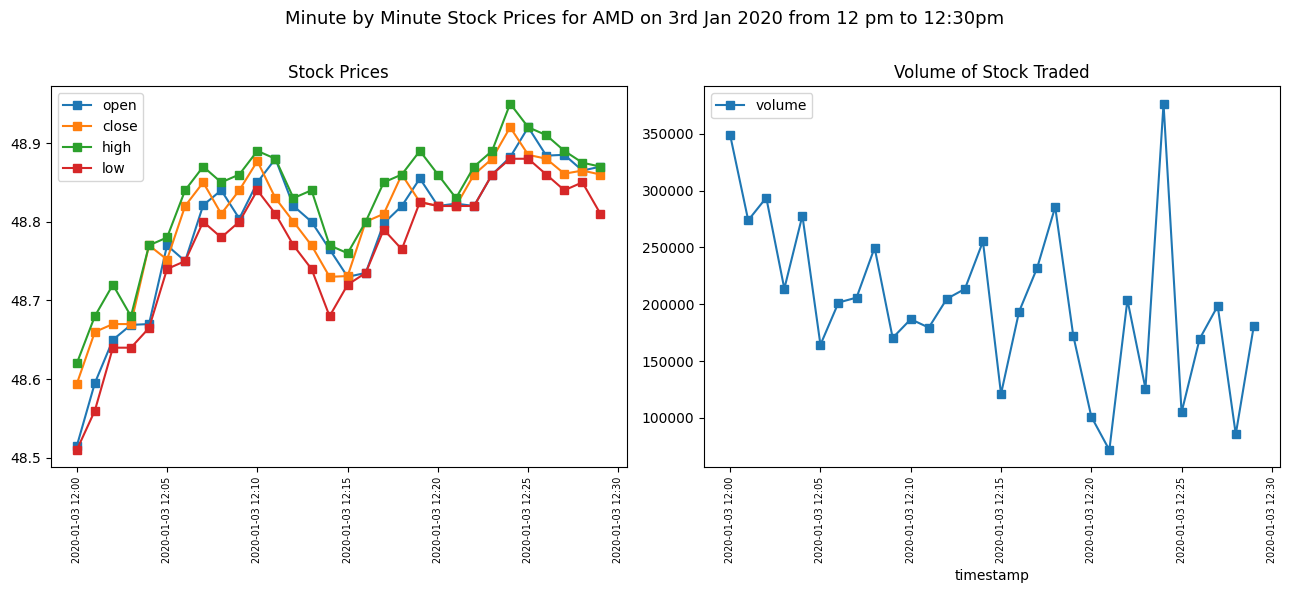

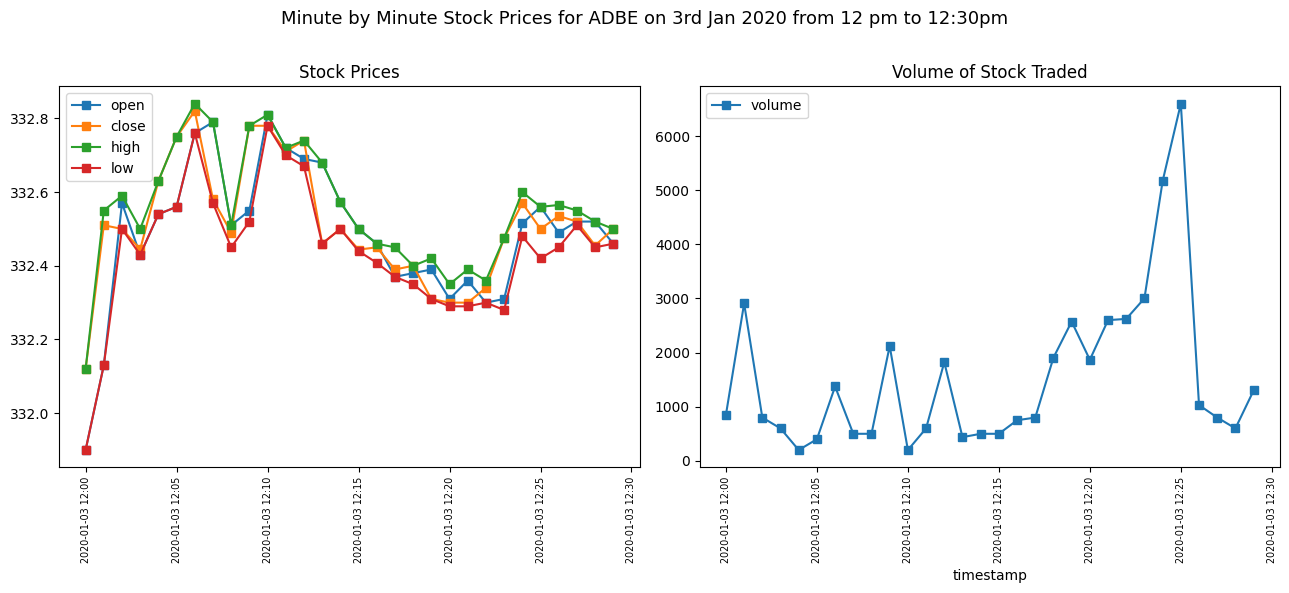

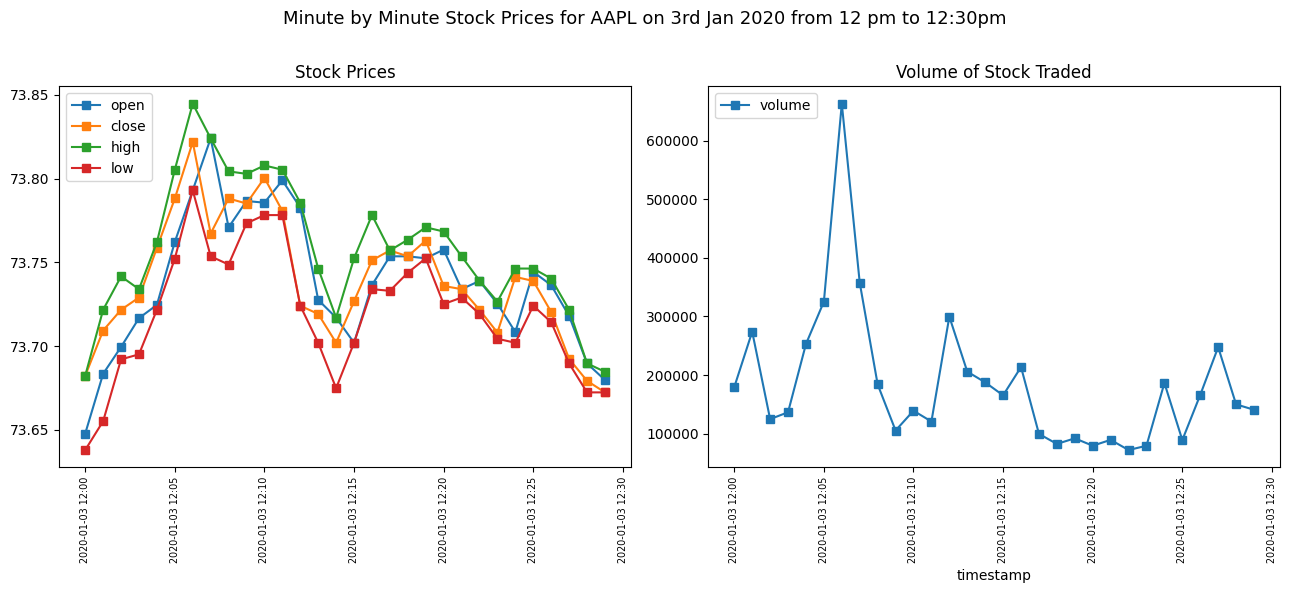

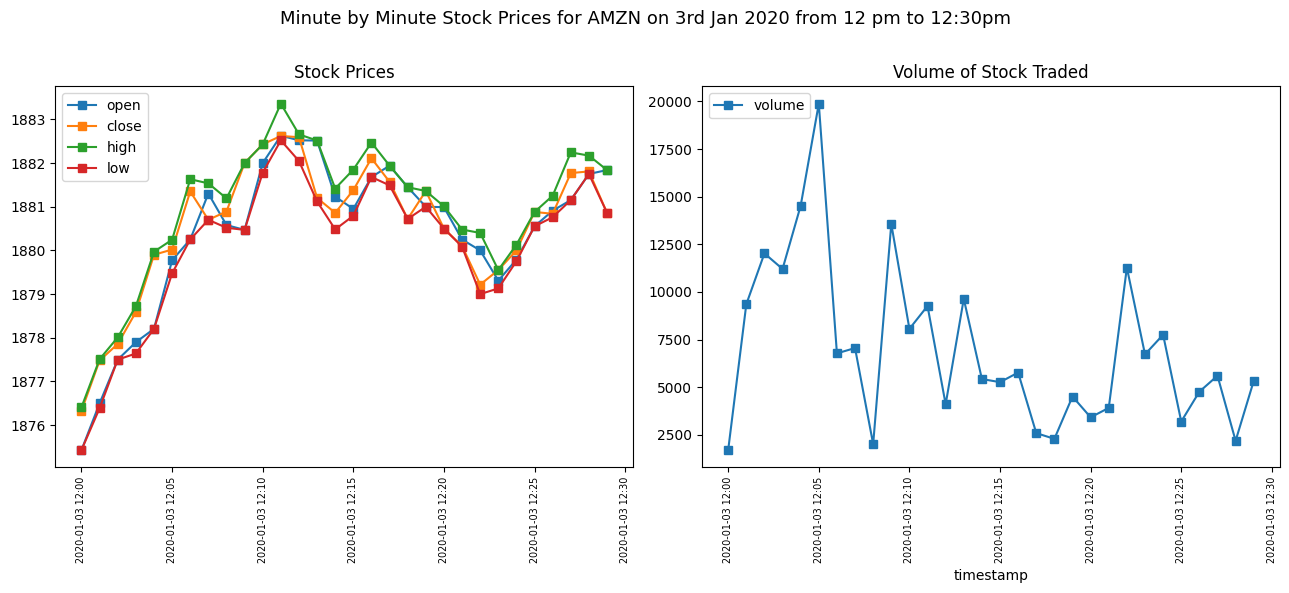

In [5]:
for i in chosen_stocks:
  df = get_subset_of_dataset(i, start_date='2020-01-03 12:00:00', end_date='2020-01-03 12:30:00')
  visualize_stock_prices_min(df, f"Minute by Minute Stock Prices for {i} on 3rd Jan 2020 from 12 pm to 12:30pm")


## 1b) Day by Day Closing Price for Few Stocks

In [6]:
def visualize_stock_prices_day(df, title):
    # index dataframe using the datetime column
    df.set_index('datetime', inplace=True)
    # resample the data day-wise using time index, perform aggregations according to the column
    # for opening take the start price, for high take the maximum price, for low take minimum, close take the last one, for volume take the sum
    df = df.resample('D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', "volume" : "sum"})

    fig, axes = plt.subplots(2, 1, figsize=(13, 10), sharex=True)
    column_names=['open', 'close', 'high', 'low']

    for i, col_name in enumerate(column_names):
      axes[0].plot(df.index, df[col_name], label=col_name)

    axes[0].set_title("Stock Prices")
    dtFmt = mdates.DateFormatter('%Y-%m-%d %H:%M')
    axes[0].xaxis.set_major_formatter(dtFmt)
    axes[0].xaxis.set_tick_params(rotation=90, labelsize='x-small')
    axes[0].legend(loc='upper left')

    axes[1].plot(df.index, df['volume'], label='volume')
    axes[1].set_title("Volume of Stock Traded")
    dtFmt = mdates.DateFormatter('%Y-%m-%d %H:%M')
    axes[1].xaxis.set_major_formatter(dtFmt)
    axes[1].xaxis.set_tick_params(rotation=90, labelsize='x-small')
    axes[1].legend(loc='upper left')

    plt.xlabel("timestamp")
    plt.suptitle(title, fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust subplot layout
    plt.show()

### Let us print for the case of the month of January 2020

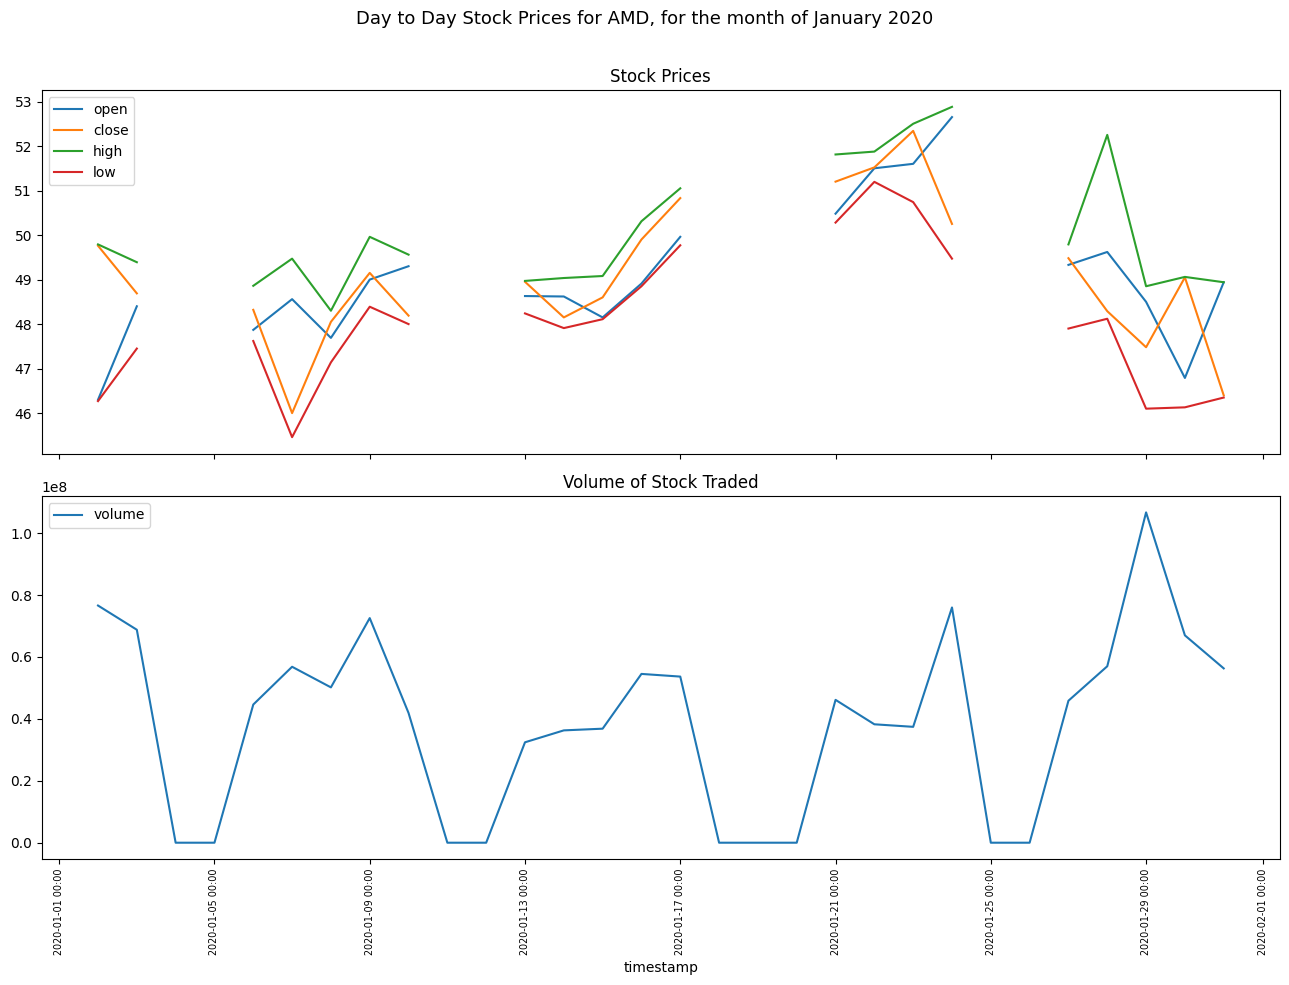

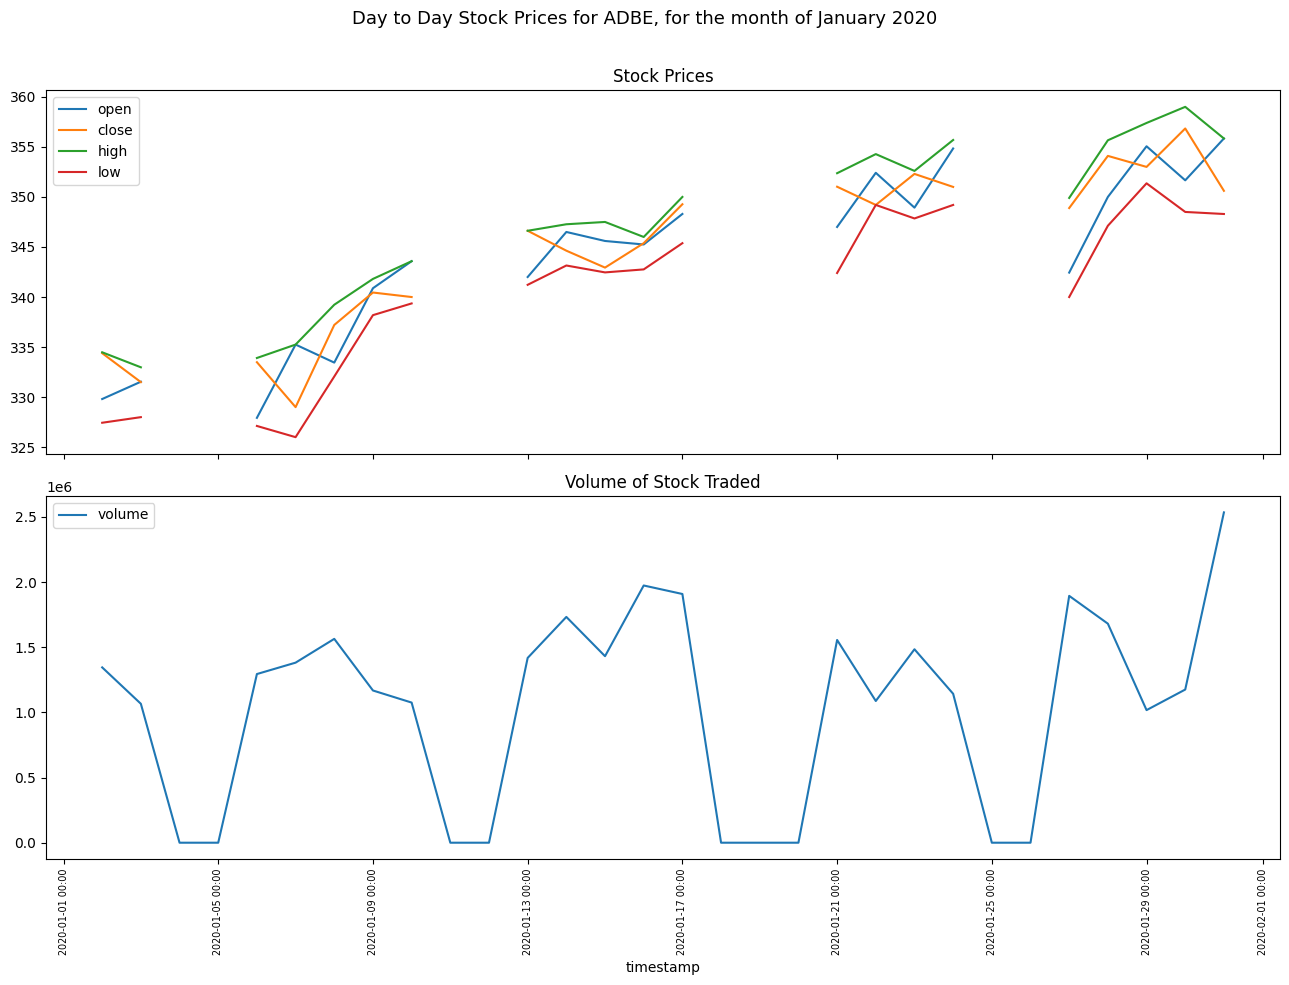

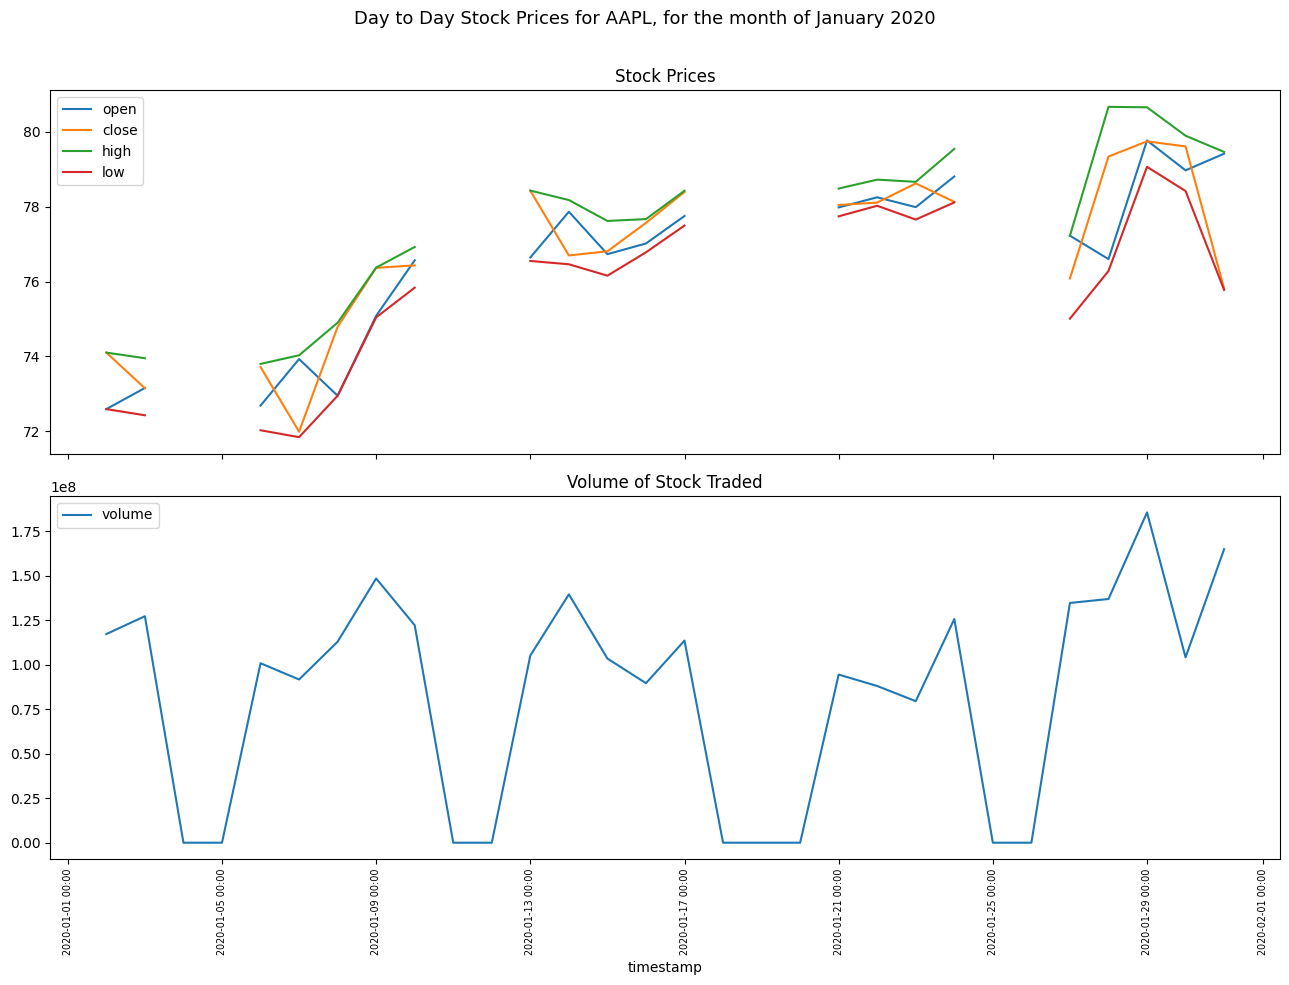

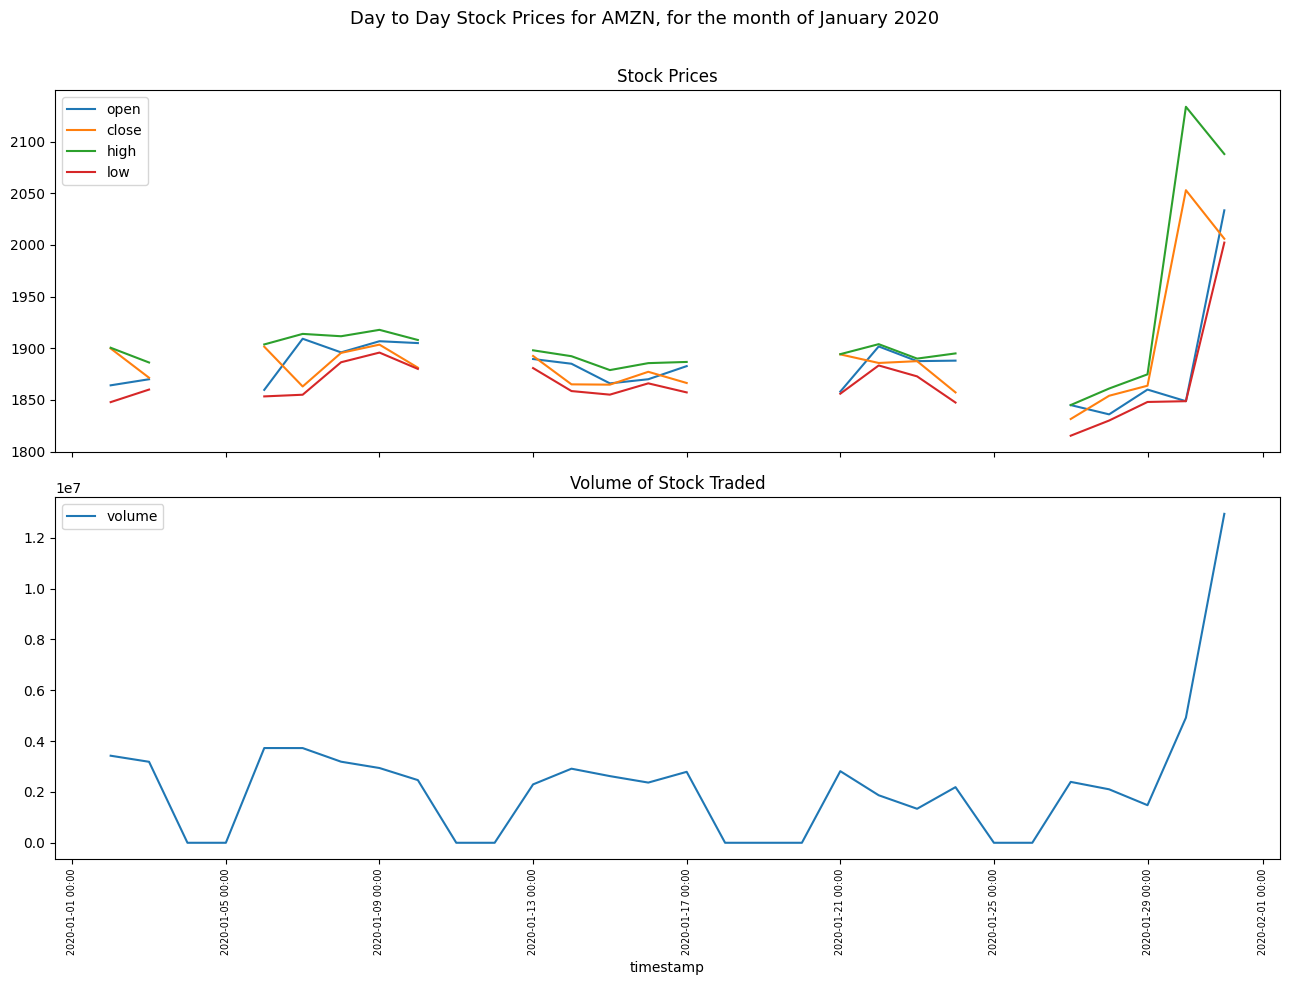

In [7]:
for i in chosen_stocks:
  df = get_subset_of_dataset(i, start_date='2020-01-01 00:00:00', end_date='2020-01-31 23:59:00')
  visualize_stock_prices_day(df, f"Day to Day Stock Prices for {i}, for the month of January 2020")

## 1c) Plotting candlestick chart with volume on secondary y-axis
- We will use the python library mplfinance by matplotlib for plotting candlestick charts

In [8]:
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.7 MB/s eta 0:00:00


### Let us plot for the first quarter of 2019

In [9]:
import pandas as pd
import mplfinance as mpf

def visualize_stock_candlestick(df, title):
    df.set_index('datetime', inplace=True)
    # perform aggregations as before to get daily data
    daily_closing = df.resample('D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', "volume" : "sum"})
    # use mpf.plot() to plot the candlestick plot
    fig, axes = mpf.plot(daily_closing, type='candle', style='yahoo', title=title, ylabel='Price', volume=True, figsize=(15, 8), returnfig=True)
    axes[1].set_ylabel('Volume')
    mpf.show()

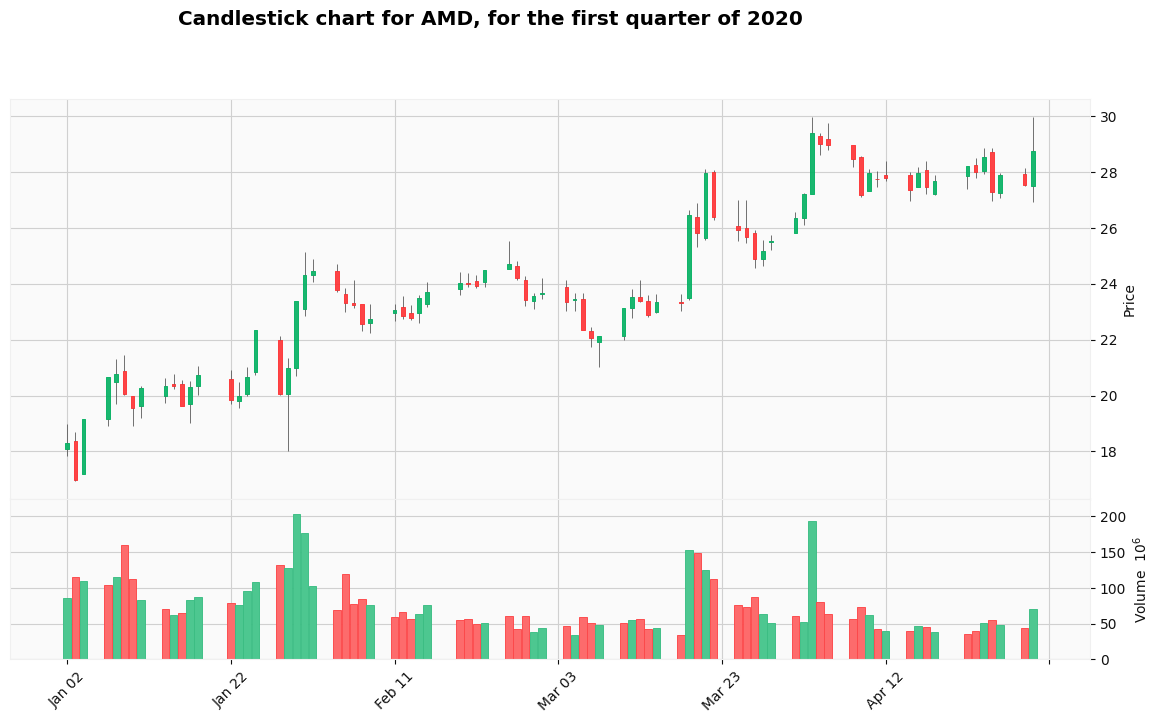

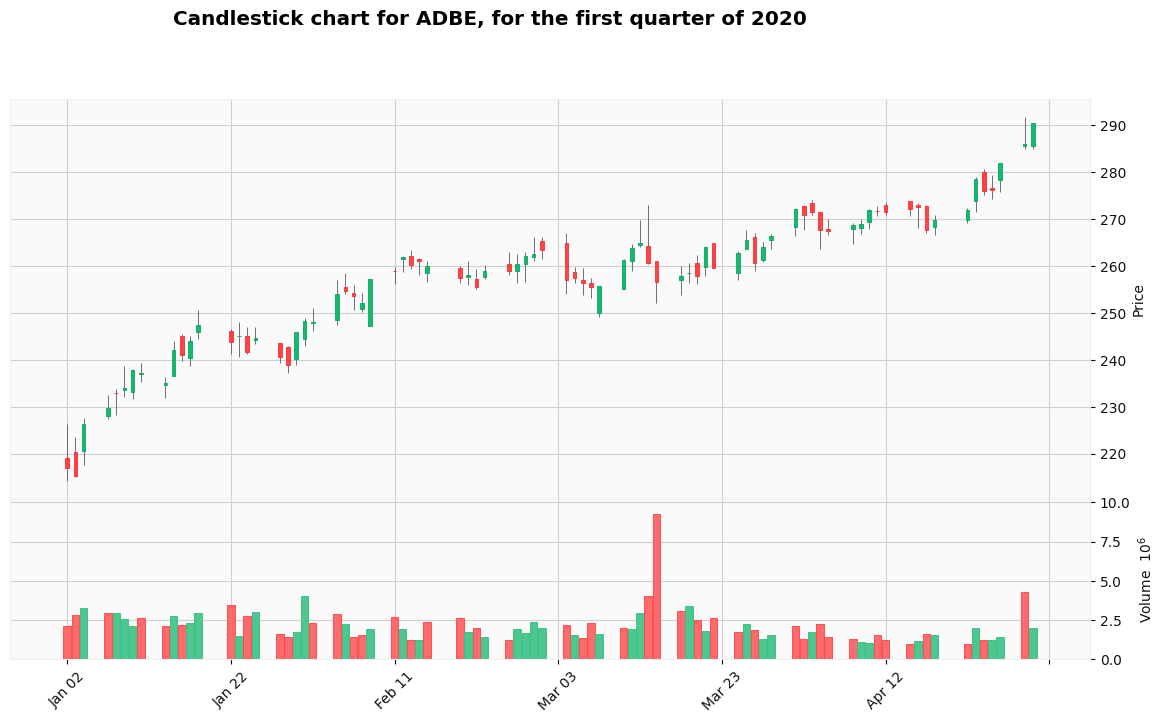

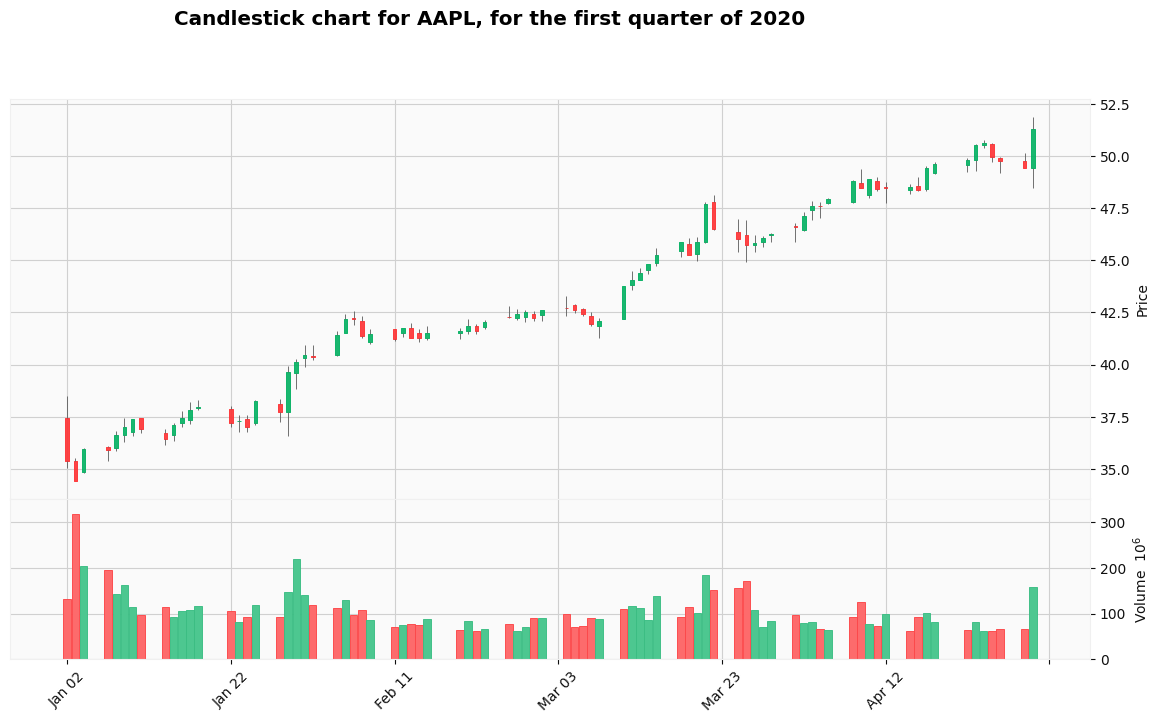

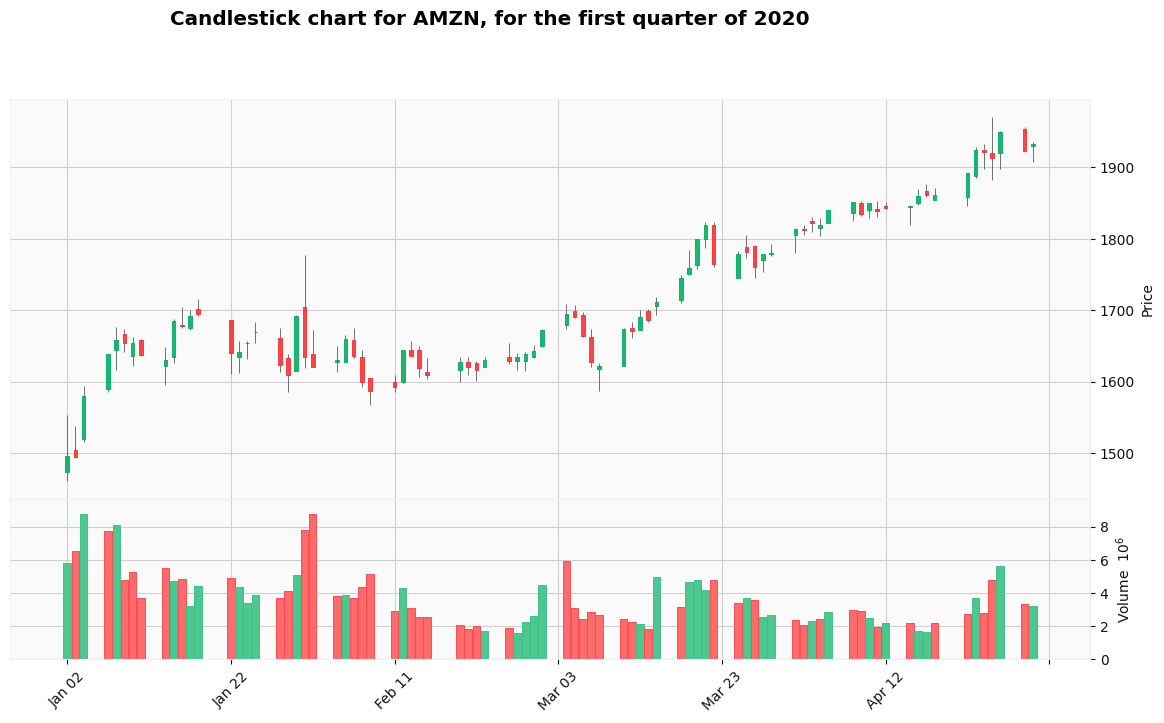

In [10]:
for i in chosen_stocks:
  df = get_subset_of_dataset(i, start_date='2020-01-01 00:00:00', end_date='2020-04-30 23:59:00')
  visualize_stock_candlestick(df, f"Candlestick chart for {i}, for the first quarter of 2020")

## 1d) Observations of Data

We can see the following things, which have been explained below with some plot image example




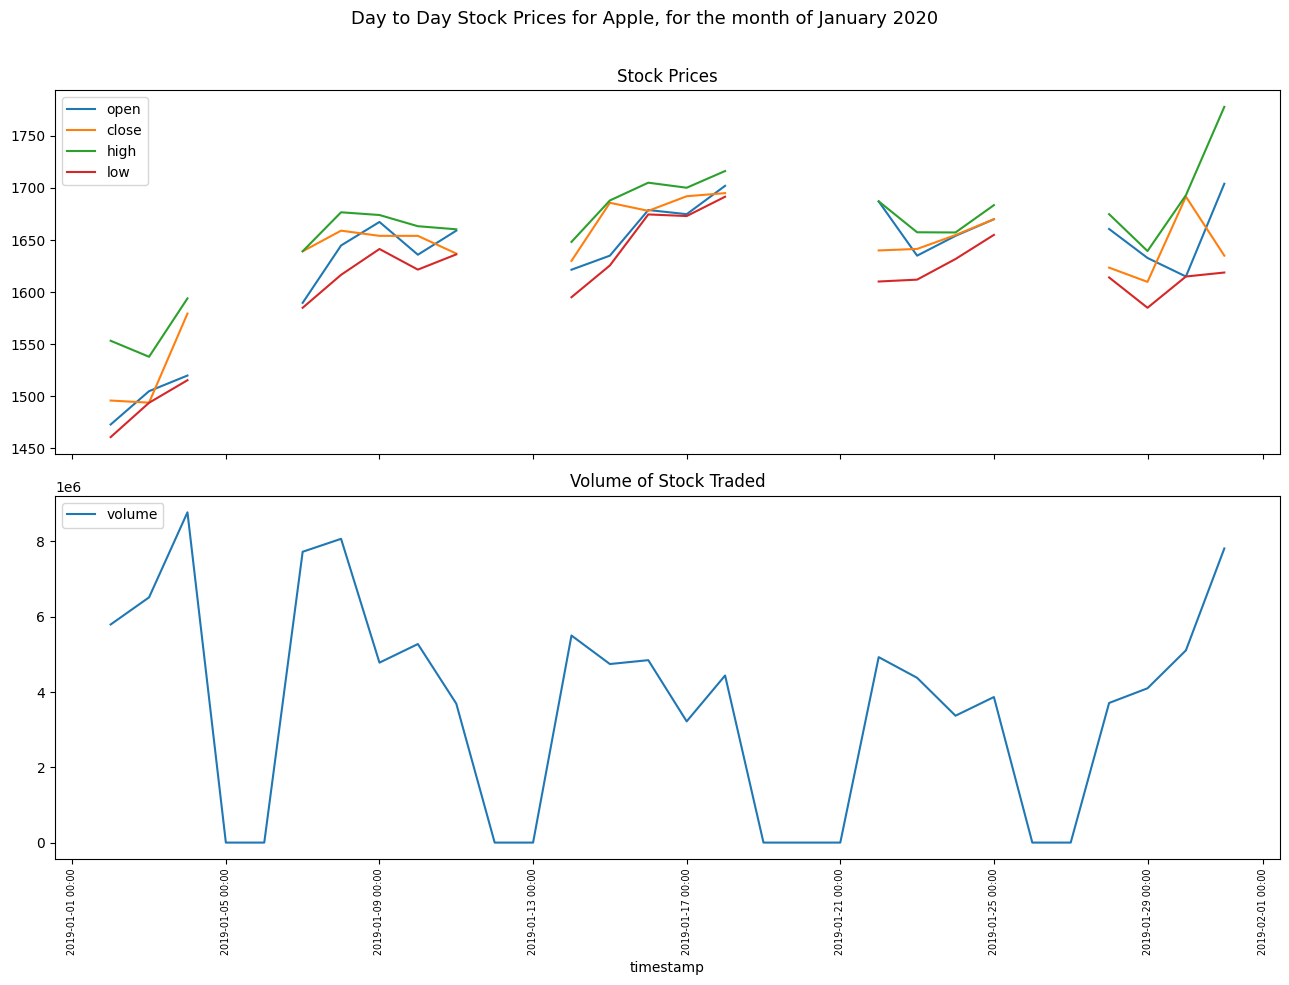

In [11]:
plt.style.use('default')
df = get_subset_of_dataset(i, start_date='2020-01-01 00:00:00', end_date='2020-01-31 23:59:00')
visualize_stock_prices_day(df, f"Day to Day Stock Prices for Apple, for the month of January 2020")

- See above figure : There are a few days for which the data is missing, for example in the case of study of a stock for a month, we will see abrupt jumps, indicating missing data for some days (this may be because of holidays or days when the market was not functioning)
- While training the LSTM, we will ignore these jumps and consider it to be a single continuous time series


## 2) Normalizing Stock Data
Two ways in which we can normalize stock data is using
- Min-Max Scaling : the relative relationships between stock prices and volumes fall within the same range, thus we can compare stocks across different companies and time periods

- Z score Scaling : we transform data to have a mean of 0 and a standard deviation of 1, centering the data around a common mean and express values in terms of standard deviations from the mean.

## Strategy we will use for Normalization

- We will use normalizers from sklearn.preprocessing, we will need seperate normalizers for volume and stock prices
- Let us take the data for the first quarter of 2020

In [12]:
mm_company_wise = {}

for i in chosen_stocks:
  # get a company wise dictionary of datasets
  mm_company_wise[i] = get_subset_of_dataset(i, start_date='2020-01-01 00:00:00', end_date='2020-04-30 23:59:00')

# combine all company data together to perform normalization
combined_data = pd.concat(list(mm_company_wise.values()), axis=0, ignore_index=True)
# we will perform seperate
price_columns = ['open', 'high', 'low', 'close']
volume_columns = ['volume']

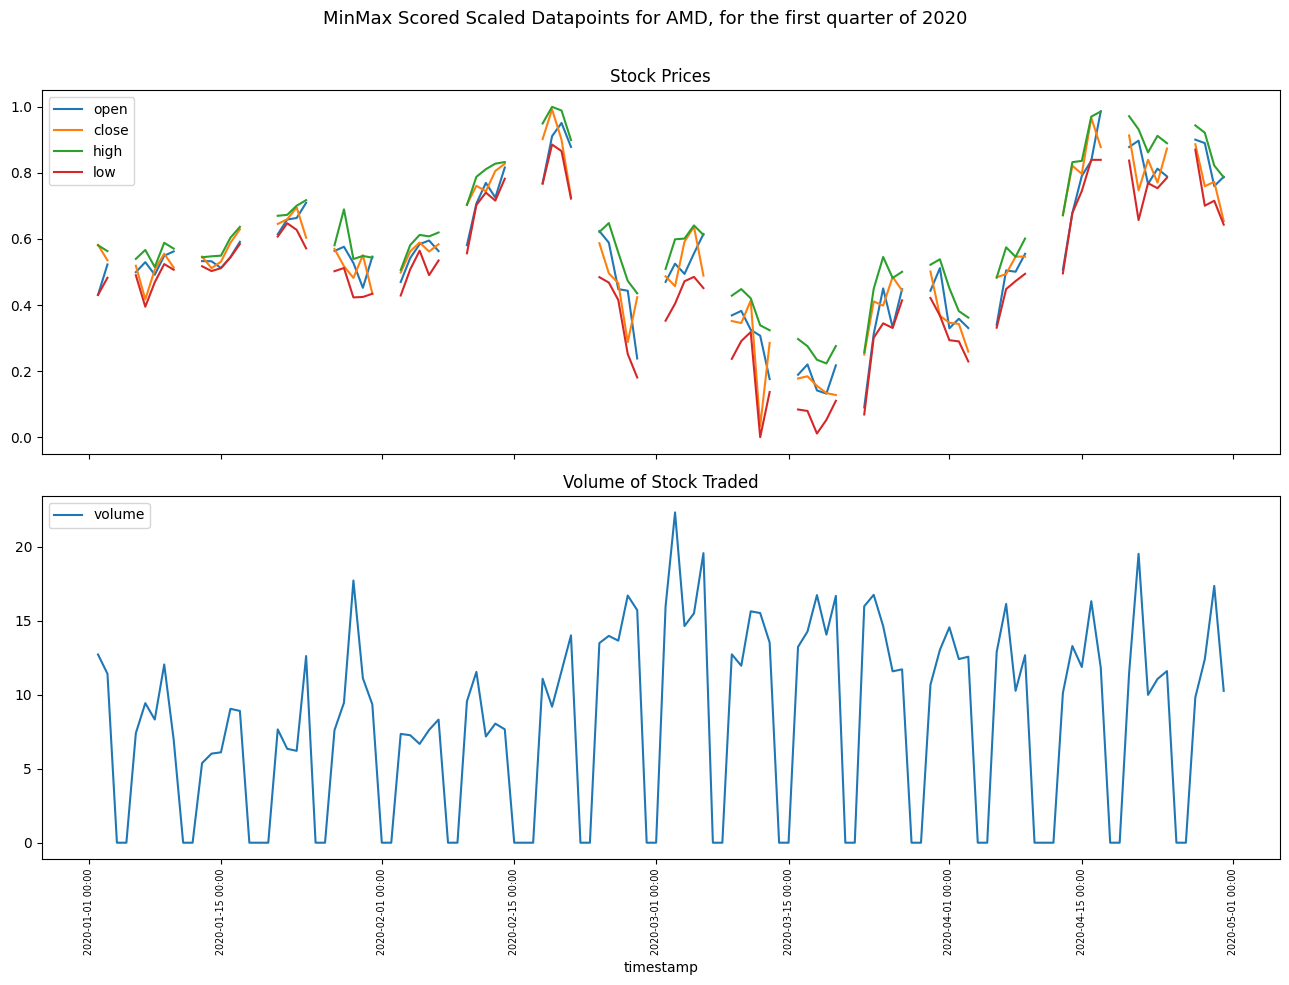

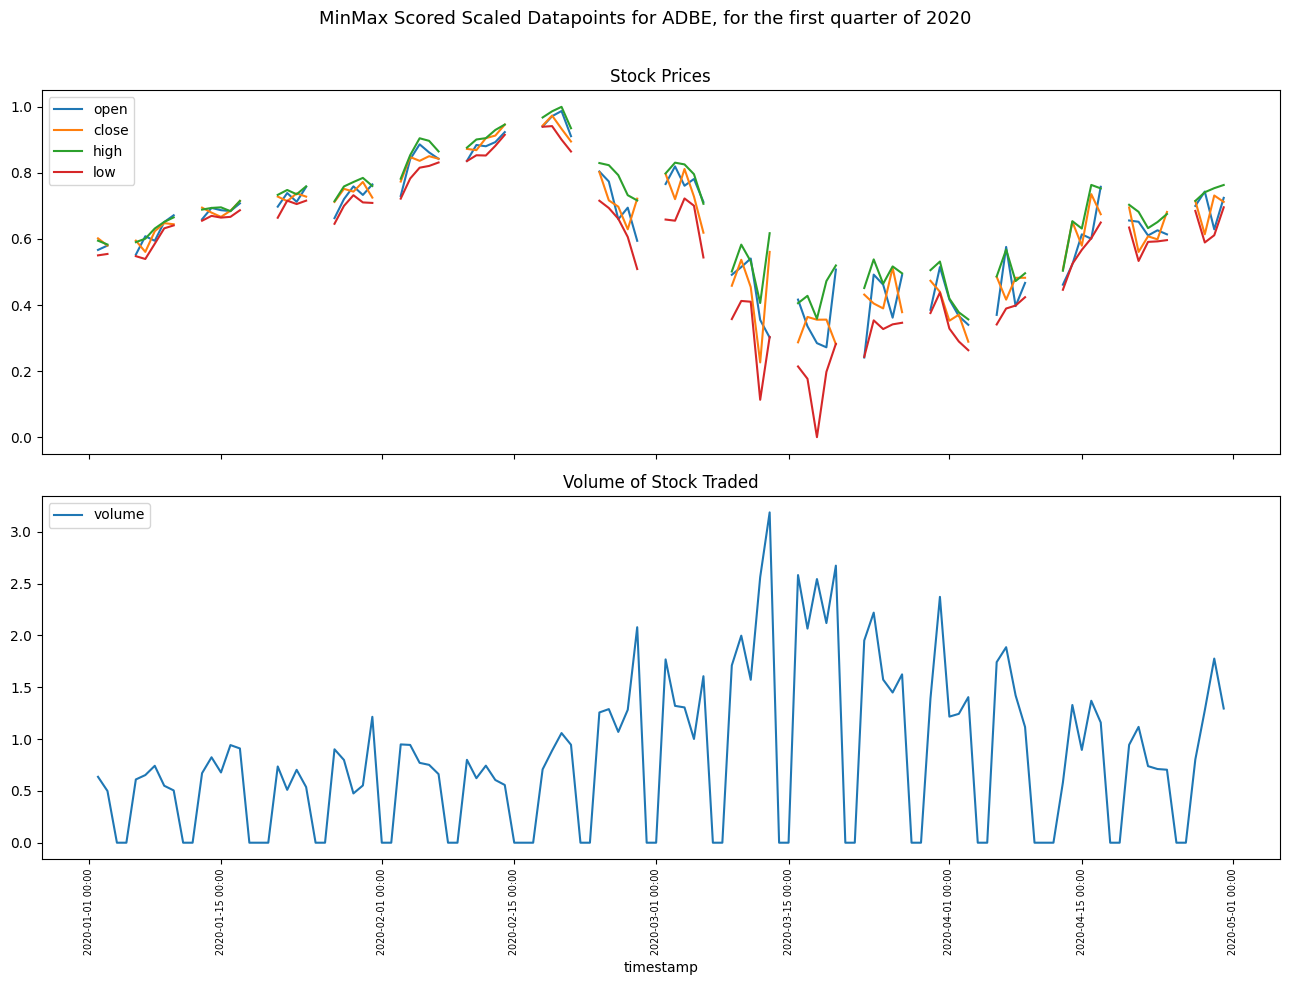

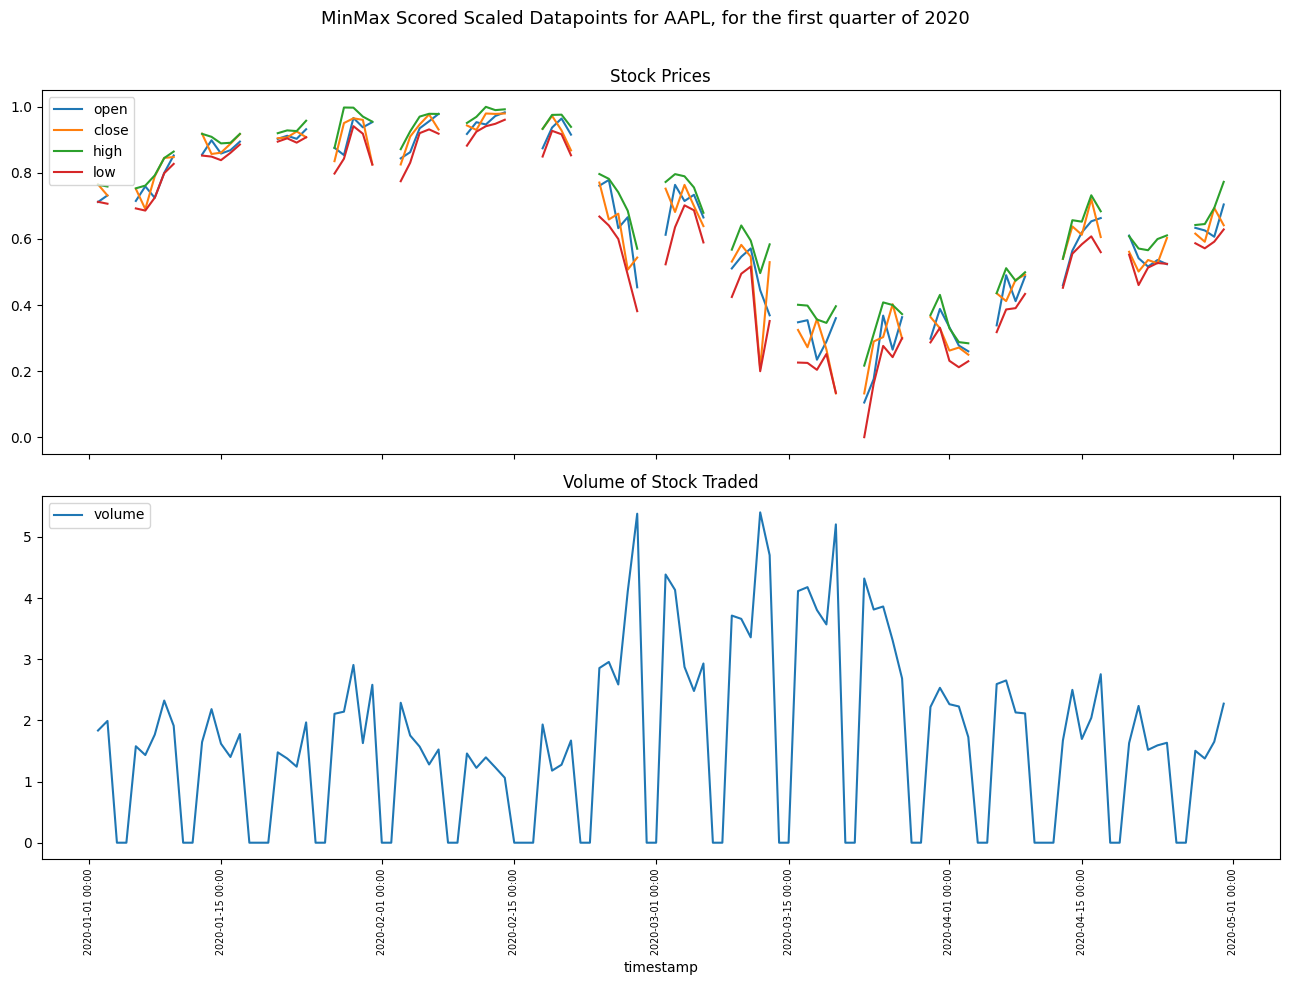

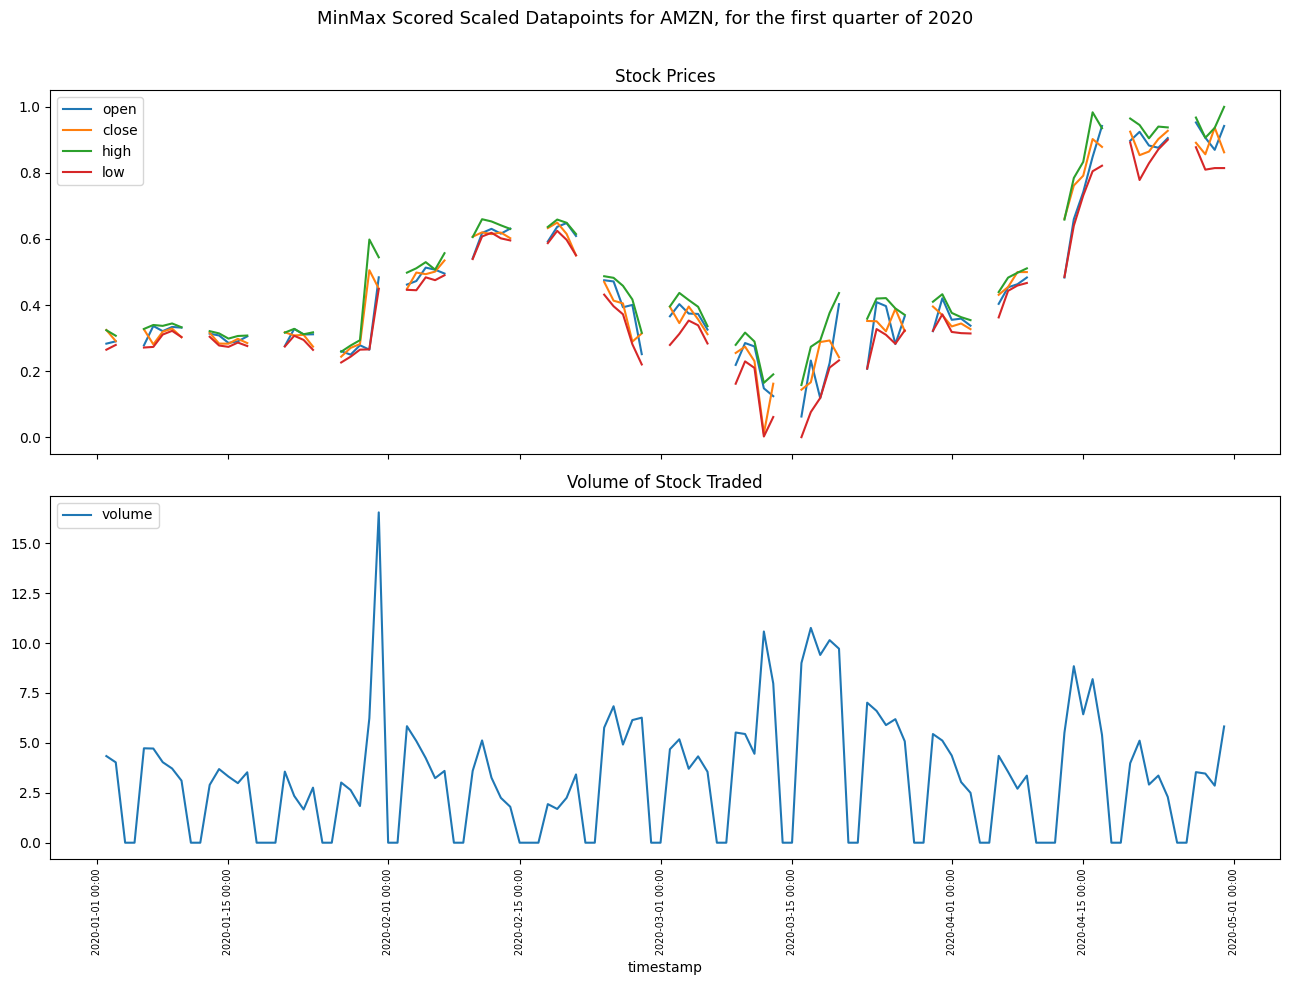

In [13]:
from sklearn.preprocessing import MinMaxScaler

mm_price_scaler = MinMaxScaler()
mm_volume_scaler = MinMaxScaler()

# fit the scaler on the combined data
mm_price_scaler.fit(combined_data[price_columns])
mm_volume_scaler.fit(combined_data[volume_columns])

for i in chosen_stocks:
  # after fitting, transform the data
  mm_company_wise[i][['open', 'close', 'low', 'high']] = mm_price_scaler.fit_transform(mm_company_wise[i][['open', 'close', 'low', 'high']])
  mm_company_wise[i]['volume'] = mm_volume_scaler.fit_transform(mm_company_wise[i][['volume']])
  visualize_stock_prices_day(mm_company_wise[i], f"MinMax Scored Scaled Datapoints for {i}, for the first quarter of 2020")

In [14]:
# perform the same as MinMax for StandardScalar for z-score based normalization
z_company_wise = {}

for i in chosen_stocks:
  z_company_wise[i] = get_subset_of_dataset(i, start_date='2020-01-01 00:00:00', end_date='2020-04-30 23:59:00')

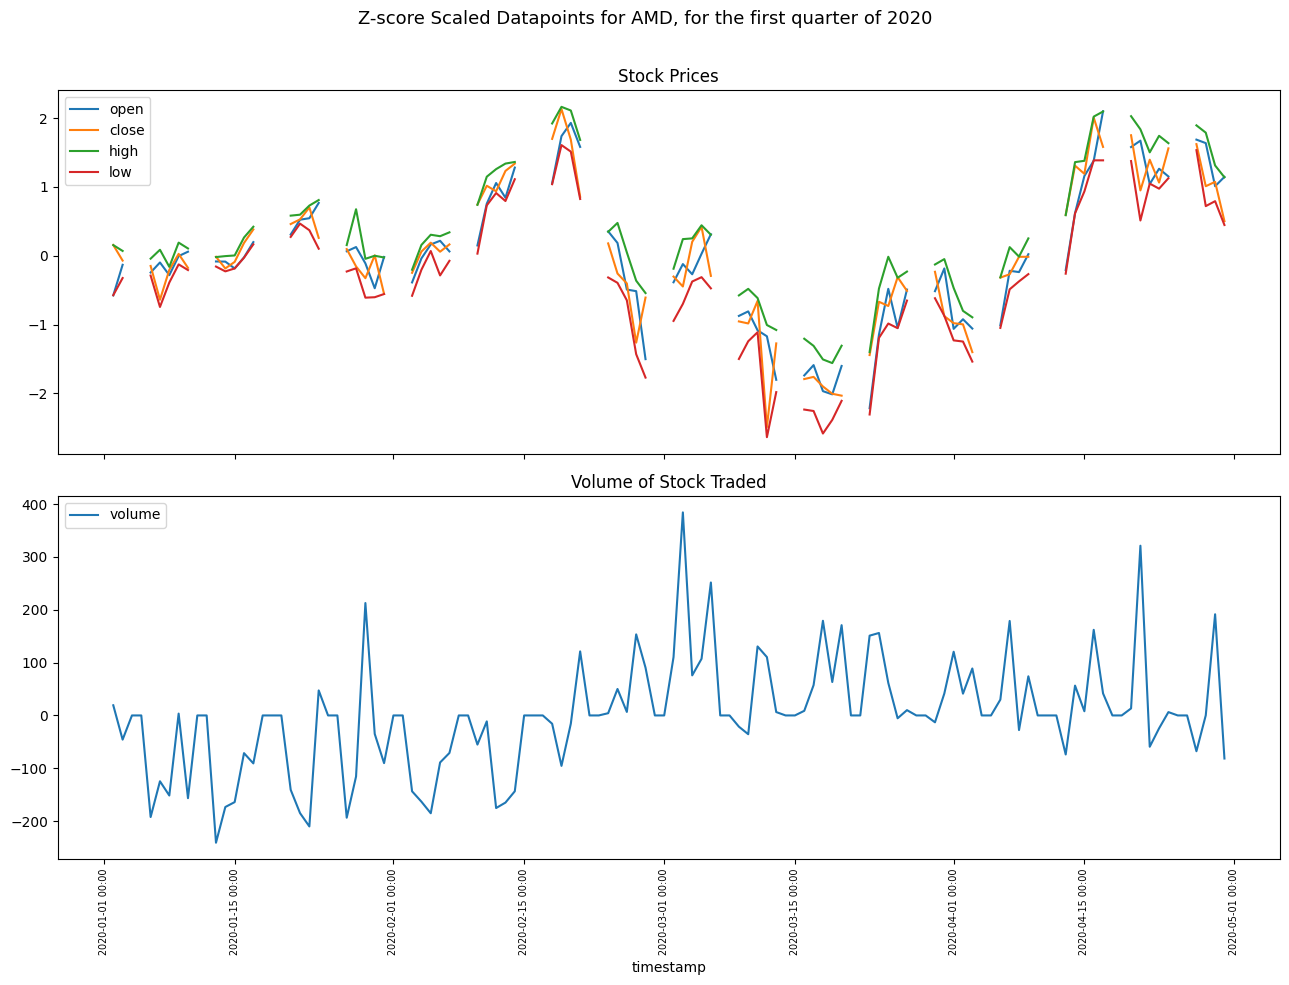

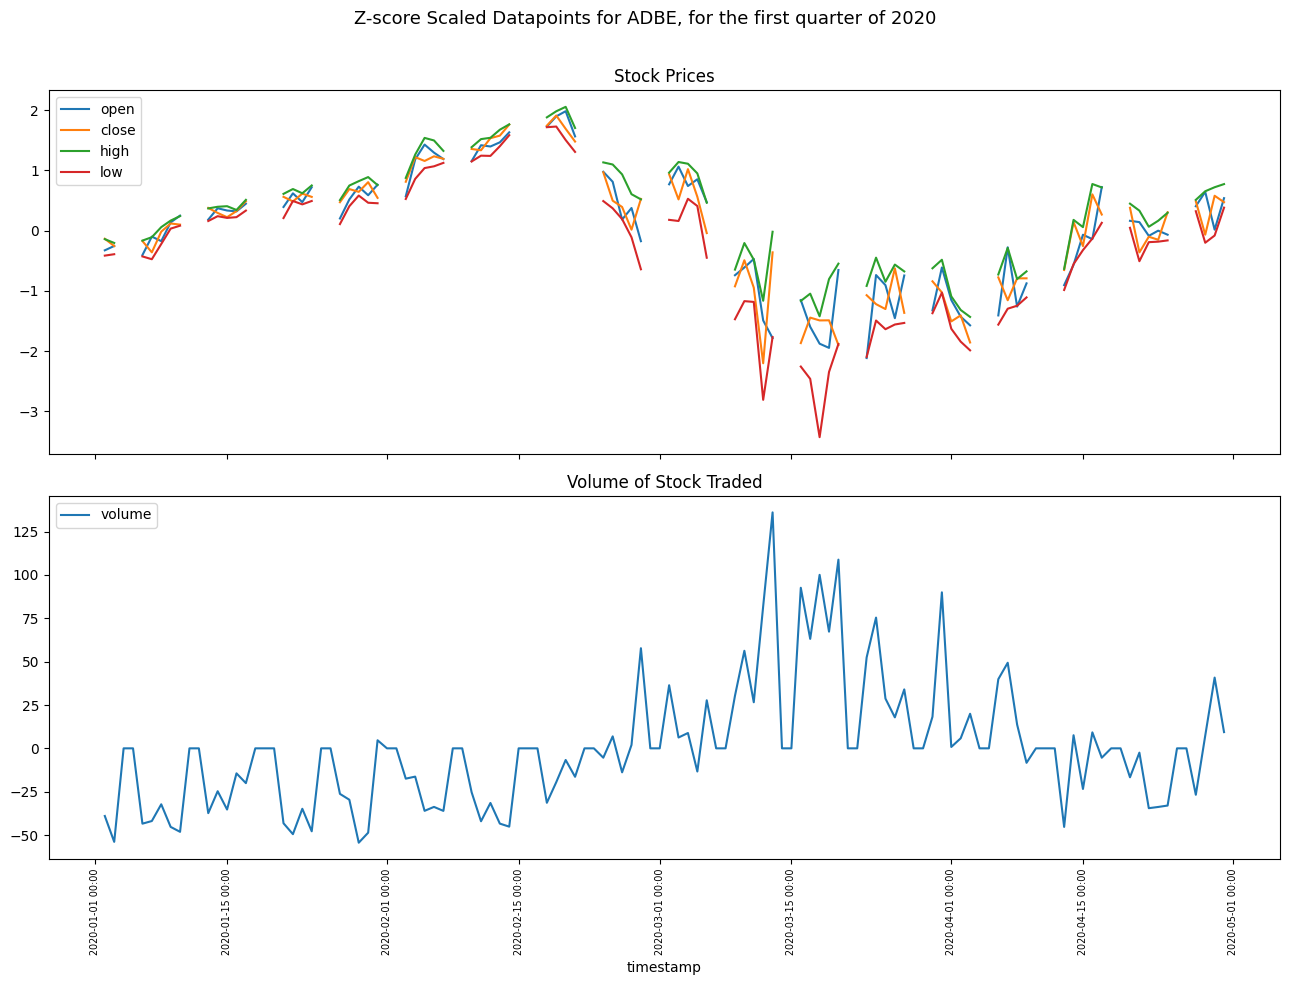

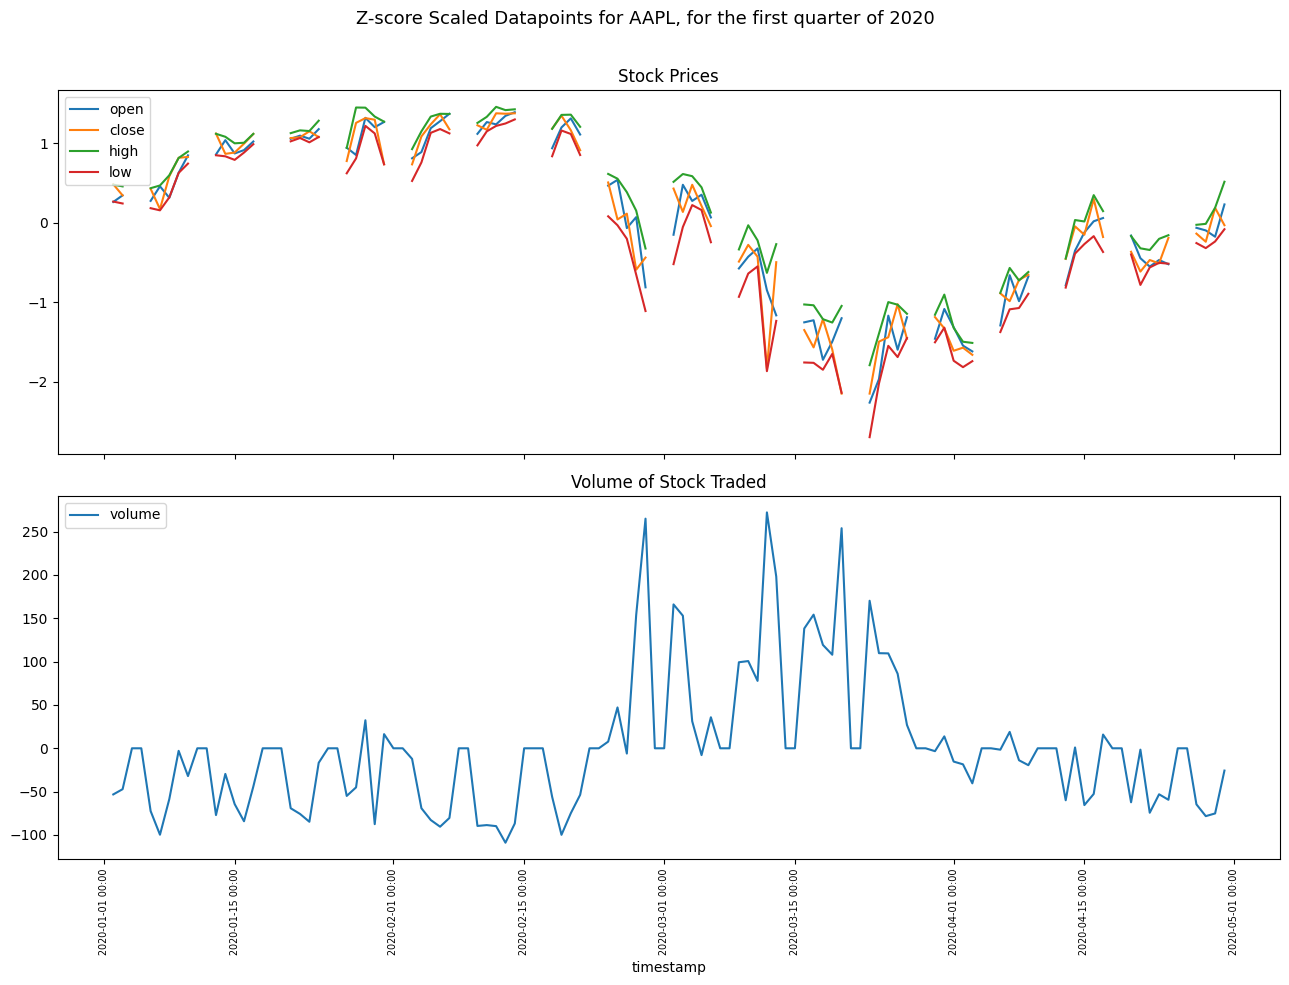

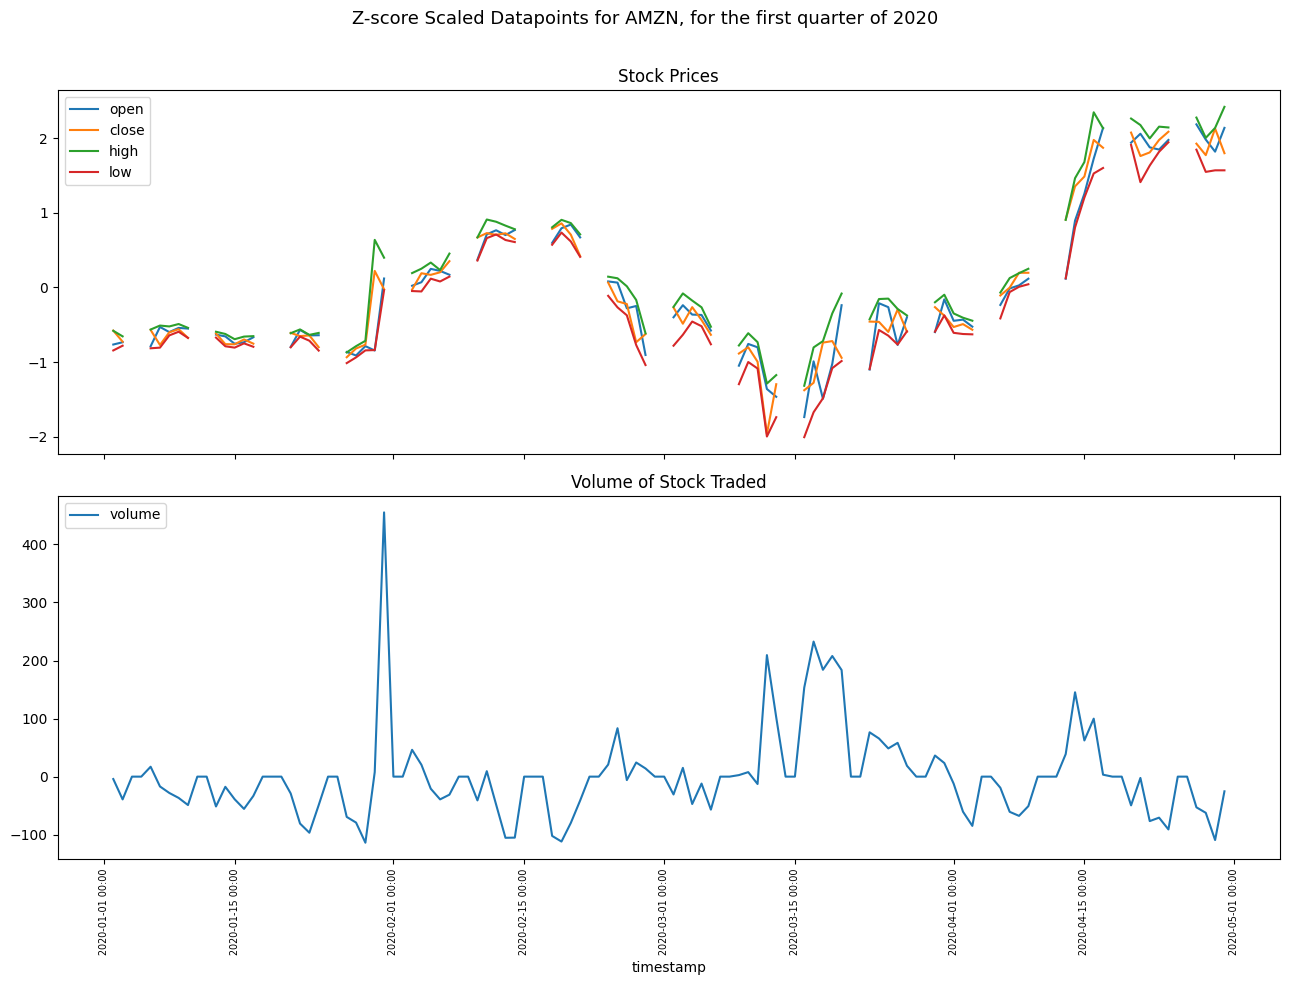

In [15]:
from sklearn.preprocessing import StandardScaler

z_price_scaler = StandardScaler()
z_volume_scaler = StandardScaler()

z_price_scaler.fit(combined_data[price_columns])
z_volume_scaler.fit(combined_data[volume_columns])

for i in chosen_stocks:
  z_company_wise[i][['open', 'close', 'low', 'high']] = z_price_scaler.fit_transform(z_company_wise[i][['open', 'close', 'low', 'high']])
  z_company_wise[i]['volume'] = z_volume_scaler.fit_transform(z_company_wise[i][['volume']])
  visualize_stock_prices_day(z_company_wise[i], f"Z-score Scaled Datapoints for {i}, for the first quarter of 2020")

## 2) Methodology for choosing the Scaling Method for various Scenarios

- For high-frequency trading (intra-day-trading), price and volume can fluctuate rapidly, in such cases Z-score would be more better than MaxMin, as it scales on the basis of mean and standard deviation and can capture short term variations better (Z-score better in this case)

- For inter-day or long term, MinMax scaling would be better, since this scaling maintains the relative differences stable for longer time periods (MinMax better in this case)

- If we allow trading simulation to account for buy-ask spreads (related to volume and price) and commissions then Z-score normalization can keep the relative significance of spreads and commissions, while Min-Max scaling cannot account for this information
(Z-score better in this case)

- Z-score normalization makes it easier to compare the relative importance of price and volume changes across different assets.

### **Seeing that the advantages of using Z-score Normalization outweigh for the application which we plan to target (see below), we will proceed with Z-score normalization**

## 3) Final Assumption Decisions
- ### **We will perform High Frequency Trading (Intra-day) where we trade after a said time of $m$ minutes (for example once every 10 minutes)**
- ### **Using one/some/all (we can try all one-by-one) stocks from the Tech basket (which is why DELL, CSCO, ADBE, AAPL, AMZN, AMD were chosen)**
  - We will predict AAPL stock price only using AAPL closing price, AAPL all parameters (close, open, high, low, volume) and also another example (see Q9) where we consider correlated stocks AAPL and AMD  
- ### **After a quick research online, we assume buy-ask spread and commissions for each trade as the following**
  - The commission per trade is **1 USD** (it is lower for HFT than daily since the frequency of trade is higher in this case) and the buy ask spread is **5 cents** (average values used for high frequency trading in NYSE as per the internet)


## 4) PyTorch Module LSTM  
[Reference Implementation Followed](https://www.kaggle.com/code/rodsaldanha/stock-prediction-pytorch?scriptVersionId=35329420&cellId=11) : Credits to Ron Saldanha (Kaggle)

In [16]:
import torch
import torch.nn as nn

# the torch implementation of LSTM : reference used https://www.kaggle.com/code/rodsaldanha/stock-prediction-pytorch?scriptVersionId=35329420&cellId=11

class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

## Strategy to combine various company stock data together
- We shall make use of inner joins on the key for example in the bottom case we take common keys of datetime for both stocks to prepare the dataset

In [17]:
df1 = get_subset_of_dataset('AAPL', start_date='2020-01-06 00:00:00', end_date='2020-01-06 9:00:00')
df1.set_index('datetime', inplace=True)

In [18]:
df2 = get_subset_of_dataset('AMZN', start_date='2020-01-06 00:00:00', end_date='2020-01-06 9:00:00')
df2.set_index('datetime', inplace=True)

In [19]:
df1.head()

open     high      low    close  volume
datetime                                                       
2020-01-06 04:00:00  72.6834  72.7031  72.3808  72.3808    5368
2020-01-06 04:01:00  72.3808  72.3808  72.3808  72.3808     732
2020-01-06 04:02:00  72.5235  72.5235  72.5210  72.5210    1200
2020-01-06 04:05:00  72.5210  72.5653  72.5210  72.5653    2000
2020-01-06 04:06:00  72.5087  72.5776  72.5087  72.5776    1996

In [20]:
df2.head()

open     high      low    close  volume
datetime                                                       
2020-01-06 04:00:00  1859.70  1859.70  1859.70  1859.70     294
2020-01-06 04:14:00  1853.39  1853.39  1853.39  1853.39     304
2020-01-06 04:37:00  1854.00  1854.00  1854.00  1854.00     302
2020-01-06 04:40:00  1854.18  1854.18  1854.18  1854.18     241
2020-01-06 04:57:00  1856.18  1856.18  1856.18  1856.18     200

In [21]:
df1 = df1.merge(df2, how='inner', on='datetime') # merge the two dataframes using inner joins to combine two company data

In [22]:
df1.head()

open_x   high_x    low_x  close_x  volume_x   open_y  \
datetime                                                                     
2020-01-06 04:00:00  72.6834  72.7031  72.3808  72.3808      5368  1859.70   
2020-01-06 04:37:00  72.3857  72.3857  72.3857  72.3857       672  1854.00   
2020-01-06 04:40:00  72.3710  72.3710  72.3685  72.3685      2356  1854.18   
2020-01-06 05:10:00  72.6268  72.6268  72.6268  72.6268      2400  1858.00   
2020-01-06 06:13:00  72.4153  72.4448  72.4153  72.4448      5252  1857.77   

                      high_y    low_y  close_y  volume_y  
datetime                                                  
2020-01-06 04:00:00  1859.70  1859.70  1859.70       294  
2020-01-06 04:37:00  1854.00  1854.00  1854.00       302  
2020-01-06 04:40:00  1854.18  1854.18  1854.18       241  
2020-01-06 05:10:00  1858.00  1858.00  1858.00       100  
2020-01-06 06:13:00  1857.77  1857.77  1857.77       290

Thus we can combine in such a way that the stock price which we want to predict is right in front or in the first column of the dataframe

## Strategy to create variable window dataset for LSTM
- Input : k windowed vector $(x_{t-k}, ... x_{t-2}, x_{t-1})$
- Output : next time step $y = x_t$

In [23]:
df = z_company_wise['AAPL'][['close', 'open', 'high', 'low', 'volume']]
df.head()

close      open      high       low    volume
datetime                                                             
2020-01-02 04:00:00  0.265159  0.264029  0.260058  0.269162 -0.263041
2020-01-02 04:06:00  0.283657  0.274907  0.278596  0.280017 -0.311308
2020-01-02 04:08:00  0.282198  0.282159  0.277134  0.287253 -0.312726
2020-01-02 04:09:00  0.289464  0.289057  0.284416  0.294137 -0.308446
2020-01-02 04:10:00  0.284011  0.283972  0.278951  0.289062 -0.308962

In [24]:
df_np = df.to_numpy()
df_np[:5, :]

array([[ 0.26515918,  0.26402944,  0.2600582 ,  0.26916212, -0.26304127],
       [ 0.28365679,  0.27490713,  0.27859647,  0.28001674, -0.31130818],
       [ 0.28219762,  0.28215892,  0.27713409,  0.28725316, -0.31272628],
       [ 0.28946401,  0.28905697,  0.28441645,  0.29413657, -0.3084462 ],
       [ 0.28401053,  0.28397187,  0.27895099,  0.28906226, -0.30896187]])

In [25]:
data = []
window_size = 4
for index in range(len(df_np) - window_size):
  # generate a k-size windowed input
  data.append(df_np[index : index + window_size])
data = np.array(data)
x_train = data[:1,:-1,:] # input data
y_train = data[:1,-1,0].reshape(-1, 1) # output data we predict the first column generally, here it is closing price

In [26]:
x_train

array([[[ 0.26515918,  0.26402944,  0.2600582 ,  0.26916212,
         -0.26304127],
        [ 0.28365679,  0.27490713,  0.27859647,  0.28001674,
         -0.31130818],
        [ 0.28219762,  0.28215892,  0.27713409,  0.28725316,
         -0.31272628]]])

In [27]:
y_train

array([[0.28946401]])

## 5) Flexible Dataloader for training the LSTM

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    # we will use this class to store our timeseries data (this extends nn's native dataset class)
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'target': self.targets[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample

class LSTMTrainDataLoader():
  def __init__(self, companies, start_timestamp, end_timestamp):
    # takes the set of companies we should consider while creating dataset
    # also takes the start timestamp and end timestamp
    self.companies = companies
    self.z_company_wise = {}
    # we perform z-score based normalization as done in Q2
    # two seperate scalers, one for prices and the other for volume
    self.z_price_scaler = StandardScaler()
    self.z_volume_scaler = StandardScaler()

    for i in companies:
      z_company_wise[i] = get_subset_of_dataset(i, start_date=start_timestamp, end_date=end_timestamp)
      z_company_wise[i].set_index('datetime', inplace=True)

    combined_data = pd.concat(list(z_company_wise.values()), axis=0, ignore_index=True)
    price_columns = ['open', 'high', 'low', 'close']
    volume_columns = ['volume']

    # fit the scaler on concatenated data
    z_price_scaler.fit(combined_data[price_columns])
    z_volume_scaler.fit(combined_data[volume_columns])

    # transform the scaled data
    for i in companies:
      z_company_wise[i][['open', 'close', 'low', 'high']] = z_price_scaler.fit_transform(z_company_wise[i][['open', 'close', 'low', 'high']])
      z_company_wise[i]['volume'] = z_volume_scaler.fit_transform(z_company_wise[i][['volume']])


  def generate_dataset(self, company, other_companies_to_include = [], input_rows = ['close'], train_ratio=0.7, validation_ratio=0.15, test_ratio=0.15, window_size=20, batch_size=32, shuffle=False):
    # first column name in input_rows should be the stock which we want to predict, generally close
    # company : the main company whose stock price we wish to predict
    # only take the input rows
    # window_size : this decides the number of past inputs to be included in the window
    # batch_size : this is to decide the size of each batch of the dataloader
    # shuffle : this is to decide that the dataset must be shuffled or not
    df = z_company_wise[company][input_rows]

    # if we have some other company which we wish to include as in the case of Q9
    # for multiple stock price as input to pre
    if len(other_companies_to_include) > 0:
      for comp in other_companies_to_include:
        new_df = z_company_wise[comp][input_rows]
        # perform inner join as per discussed strategy
        df = df.merge(new_df, how='inner', on='datetime')

    df_np = df.to_numpy()
    print(df_np.shape)
    data = []

    # perform the windowed dataset generation
    for index in range(len(df_np) - window_size):
        data.append(df_np[index : index + window_size])

    data = np.array(data)

    # identify the splits for test, train and validation dataset
    # by default we perform 70 : 15 : 15 split
    test_set_size = int(np.round(test_ratio*data.shape[0]))
    validation_set_size = int(np.round(validation_ratio*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size) - (validation_set_size)

    # divide the dataset into test, train, validation
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,0].reshape(-1, 1)

    x_test = data[train_set_size: train_set_size + validation_set_size,:-1,:]
    y_test = data[train_set_size: train_set_size + validation_set_size,-1,0].reshape(-1, 1)

    x_valid = data[train_set_size + validation_set_size : ,:-1, :]
    y_valid = data[train_set_size + validation_set_size : ,-1,0].reshape(-1, 1)

    # convert to torch tensors
    self.x_train = torch.from_numpy(x_train).type(torch.Tensor)
    self.x_test = torch.from_numpy(x_test).type(torch.Tensor)
    self.y_train = torch.from_numpy(y_train).type(torch.Tensor)
    self.y_test = torch.from_numpy(y_test).type(torch.Tensor)
    self.x_valid = torch.from_numpy(x_valid).type(torch.Tensor)
    self.y_valid = torch.from_numpy(y_valid).type(torch.Tensor)

    # create torch datasets
    self.train_data = TimeSeriesDataset(self.x_train, self.y_train)
    self.test_data = TimeSeriesDataset(self.x_test, self.y_test)
    self.valid_data = TimeSeriesDataset(self.x_valid, self.y_valid)

    # print shapes for easier debugging
    print("X : train_shape:",x_train.shape, "test_shape:", x_test.shape, "valid_shape:", x_valid.shape)
    print("Y : train_shape", y_train.shape, "test_shape:", y_test.shape, "valid_shape:", y_valid.shape)

    # generate dataloader using torch's DataLoader class with shuffle and batch size as decided
    self.train_dataloader = DataLoader(self.train_data, batch_size=batch_size, shuffle=shuffle)
    self.test_dataloader = DataLoader(self.test_data, batch_size=batch_size, shuffle=shuffle)
    self.valid_dataloader = DataLoader(self.valid_data, batch_size=batch_size, shuffle=shuffle)
    print("Dataloader Created Successfully")

### Some Examples

In [29]:
dataloader = LSTMTrainDataLoader(['AAPL'], '2019-01-01 00:00:00', '2019-01-06 23:59:59')
dataloader.generate_dataset('AAPL', [], ['close', 'open'])

(2492, 2)
X : train_shape: (1730, 19, 2) test_shape: (371, 19, 2) valid_shape: (371, 19, 2)
Y : train_shape (1730, 1) test_shape: (371, 1) valid_shape: (371, 1)
Dataloader Created Successfully


In [30]:
dataloader = LSTMTrainDataLoader(['AAPL', 'AMZN'], '2019-01-01 00:00:00', '2019-01-06 23:59:59')
dataloader.generate_dataset('AAPL', [], ['close', 'open', 'high', 'low'])

(2492, 4)
X : train_shape: (1730, 19, 4) test_shape: (371, 19, 4) valid_shape: (371, 19, 4)
Y : train_shape (1730, 1) test_shape: (371, 1) valid_shape: (371, 1)
Dataloader Created Successfully


In [31]:
dataloader = LSTMTrainDataLoader(['AAPL', 'AMZN'], '2019-01-01 00:00:00', '2019-01-06 23:59:59')
dataloader.generate_dataset('AAPL', ['AMZN'], ['close'])

(1678, 2)
X : train_shape: (1160, 19, 2) test_shape: (249, 19, 2) valid_shape: (249, 19, 2)
Y : train_shape (1160, 1) test_shape: (249, 1) valid_shape: (249, 1)
Dataloader Created Successfully


In [32]:
dataloader = LSTMTrainDataLoader(['AAPL', 'AMZN'], '2019-01-01 00:00:00', '2019-01-06 23:59:59')
dataloader.generate_dataset('AAPL', ['AMZN'], ['close', 'open', 'high', 'low'])

(1678, 8)
X : train_shape: (1160, 19, 8) test_shape: (249, 19, 8) valid_shape: (249, 19, 8)
Y : train_shape (1160, 1) test_shape: (249, 1) valid_shape: (249, 1)
Dataloader Created Successfully


## 6) Training the LSTM


### Predicting Close Price for Single Company (AAPL) only using its Close Price as input
- We will train the data on the data for a quarter (4 months) and predict it for the next quarter

In [33]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100
batch_size = 64

In [34]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adagrad(model.parameters(), lr=0.005)
model

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [35]:
dataloader = LSTMTrainDataLoader(['AAPL'], '2020-01-01 00:00:00', '2020-04-30 23:59:59')

In [36]:
dataloader.generate_dataset('AAPL', [], ['close'], batch_size=batch_size, shuffle=True, window_size=25)

(65672, 1)
X : train_shape: (45953, 24, 1) test_shape: (9847, 24, 1) valid_shape: (9847, 24, 1)
Y : train_shape (45953, 1) test_shape: (9847, 1) valid_shape: (9847, 1)
Dataloader Created Successfully


In [37]:
import time

def train_model(model, num_epochs, dataloader, patience):
  hist = np.zeros(num_epochs) # to store the training loss to plot it later
  start_time = time.time()
  prev_time = start_time
  best_val_loss = np.inf # to store minimum value of validation loss for early stopping


  train_loader = dataloader.train_dataloader
  valid_loader = dataloader.valid_dataloader

  for t in range(num_epochs):
      train_loss = 0.0 # running sum of train loss
      for batch in train_loader:
        # predict for each training batch
        y_train_pred = model(batch['data'])
        # evaluate loss
        loss = criterion(y_train_pred, batch['target'])
        optimiser.zero_grad()
        # perform back propogation
        loss.backward()
        optimiser.step()
        train_loss += loss.item()
      # evaluate average train loss for the epoch
      train_loss /= len(train_loader)

      # evaluate validation loss
      val_loss = 0.0
      for batch in valid_loader:
        y_val_pred = model(batch['data'])
        loss = criterion(y_val_pred, batch['target'])
        val_loss += loss.item()
      val_loss /= len(train_loader)

      curr_time = time.time()
      print("Epoch ", t, "Train MSE: ", train_loss, "Validation MSE: ", val_loss, "Time taken for Epoch:", curr_time - prev_time)
      prev_time = curr_time
      hist[t] = train_loss

      if val_loss < best_val_loss:
          # check if current val loss is lesser than minimum
          best_val_loss = val_loss
          no_improvement_count = 0
      else:
          no_improvement_count += 1

      if no_improvement_count >= patience:
          # if there is no improvement in val loss for patience epochs, then perform early stopping
          print(f'Early stopping after {patience} epochs of no improvement.')
          break

  training_time = time.time()-start_time
  print("Training time: {}".format(training_time))
  return hist

In [38]:
hist = train_model(model, num_epochs, dataloader, 10)

Epoch  0 Train MSE:  0.013779178373817333 Validation MSE:  8.544916753697316e-05 Time taken for Epoch: 6.792736053466797
Epoch  1 Train MSE:  0.0010676935766556483 Validation MSE:  8.038224589708812e-05 Time taken for Epoch: 7.094648122787476
Epoch  2 Train MSE:  0.0009697990062755373 Validation MSE:  8.19217298746236e-05 Time taken for Epoch: 6.3136749267578125
Epoch  3 Train MSE:  0.0009282449797823667 Validation MSE:  9.676922133832947e-05 Time taken for Epoch: 7.202017307281494
Epoch  4 Train MSE:  0.0008877043701140893 Validation MSE:  7.908099355005758e-05 Time taken for Epoch: 6.552805423736572
Epoch  5 Train MSE:  0.0008614606785661026 Validation MSE:  7.699792222259113e-05 Time taken for Epoch: 6.878511667251587
Epoch  6 Train MSE:  0.0008349758556406884 Validation MSE:  7.414082351405567e-05 Time taken for Epoch: 7.099277496337891
Epoch  7 Train MSE:  0.0008149019940066918 Validation MSE:  6.944907025511147e-05 Time taken for Epoch: 6.969050407409668
Epoch  8 Train MSE:  0.00

In [39]:
torch.save(model, 'single_feature.pt')

In [40]:
import seaborn as sns

def visualize_train_results(model, dataloader, title, ylabel):
  # get the predicted value
  y_train_pred_np = model(dataloader.x_train).detach().numpy()
  bv = np.ones((1, 4))
  # broadcast because our scaler takes a 4 dim vector (corresponding to each price), we ultimately will take one column from here
  y_tp_rshp = y_train_pred_np * bv

  # get the actual value
  y_train_og_np = dataloader.y_train.detach().numpy()
  y_to_rshp = y_train_og_np * bv

  predict = pd.DataFrame(z_price_scaler.inverse_transform(y_tp_rshp))
  original = pd.DataFrame(z_price_scaler.inverse_transform(y_to_rshp))

  sns.set_style("darkgrid")

  fig = plt.figure()
  fig.subplots_adjust(hspace=0.2, wspace=0.2)

  plt.subplot(1, 2, 1)
  # index three because our scaler had closing price at fourth position while training
  ax = sns.lineplot(x = original[3].index, y = original[3], label="Data", color='royalblue')
  ax = sns.lineplot(x = predict[3].index, y = predict[3], label="Training Prediction (LSTM)", color='tomato')
  ax.set_title(title, size = 14, fontweight='bold')
  ax.set_xlabel("Minute", size = 14)
  ax.set_ylabel(ylabel, size = 14)
  ax.set_xticklabels('', size=10)


  plt.subplot(1, 2, 2)
  ax = sns.lineplot(data=hist, color='royalblue')
  ax.set_xlabel("Epoch", size = 14)
  ax.set_ylabel("Loss", size = 14)
  ax.set_title("Training Loss", size = 14, fontweight='bold')
  fig.set_figheight(6)
  fig.set_figwidth(16)

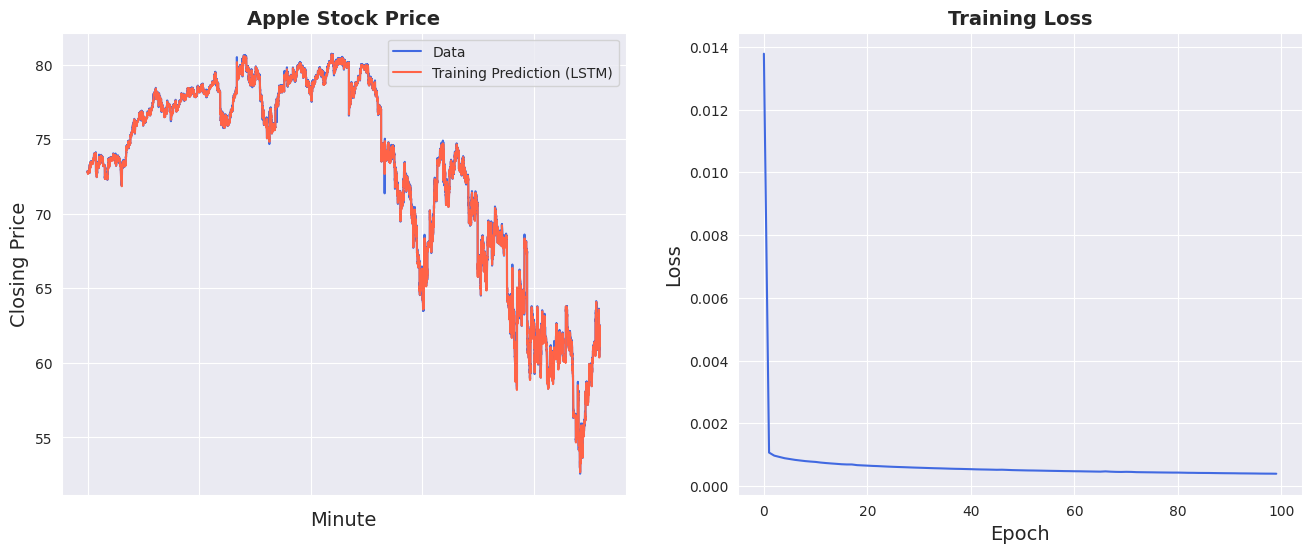

In [41]:
visualize_train_results(model, dataloader, "Apple Stock Price", "Closing Price")

In [42]:
def visualize_test_results(model, dataloader, title, ylabel):
  # perform the same as visualize_test_results() method but using the test data
  y_test_pred = model(dataloader.x_test)
  y_test_pred_np = y_test_pred.detach().numpy()
  bv = np.ones((1, 4))
  y_tp_rshp = y_test_pred_np * bv

  y_test_og_np = dataloader.y_test.detach().numpy()
  y_to_rshp = y_test_og_np * bv

  print(f"Testing MSE Loss : {criterion(y_test_pred, dataloader.y_test)}")

  predict = pd.DataFrame(z_price_scaler.inverse_transform(y_tp_rshp))
  original = pd.DataFrame(z_price_scaler.inverse_transform(y_to_rshp))

  sns.set_style("darkgrid")

  fig = plt.figure(figsize=(20, 10))

  sns.lineplot(x = original[3].index, y = original[3], label="Actual Data", color='royalblue')
  sns.lineplot(x = predict[3].index, y = predict[3], label="Test Prediction (LSTM)", color='tomato')
  plt.title(title, size = 14, fontweight='bold')
  plt.xlabel("Minute", size = 14)
  plt.ylabel(ylabel, size = 14)

  fig.set_figheight(8)
  fig.set_figwidth(18)

Testing MSE Loss : 0.0002836835046764463


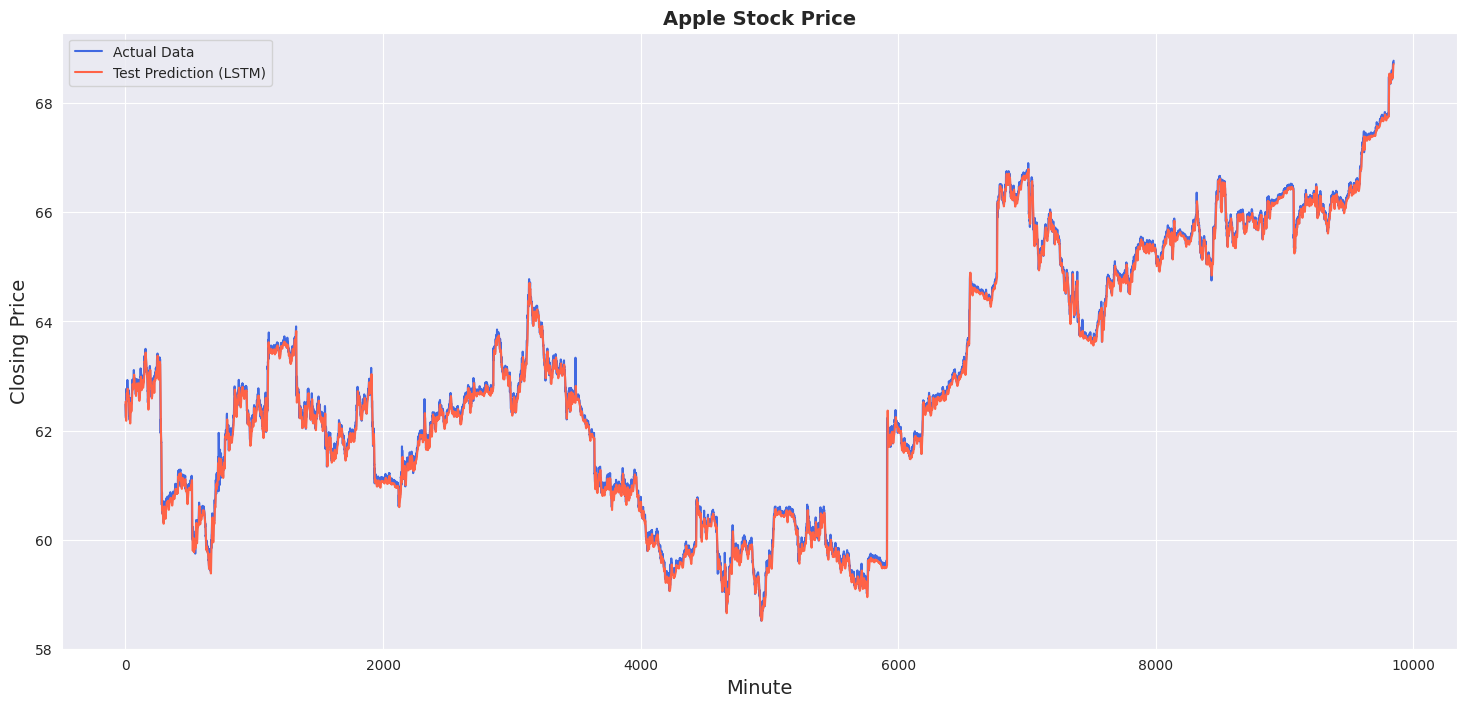

In [43]:
visualize_test_results(model, dataloader, "Apple Stock Price", "Closing Price")

### Class for Prediction Data Loader
- We will predict using the data trained on previous quarter for the next quarter

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class LSTMPredictDataLoader():
  # we will use this class to store the prediction data which the model has not seen
  def __init__(self, companies, start_timestamp, end_timestamp):
    self.companies = companies
    self.z_company_wise = {}
    self.z_price_scaler = StandardScaler()
    self.z_volume_scaler = StandardScaler()

    for i in companies:
      z_company_wise[i] = get_subset_of_dataset(i, start_date=start_timestamp, end_date=end_timestamp)
      z_company_wise[i].set_index('datetime', inplace=True)

    combined_data = pd.concat(list(z_company_wise.values()), axis=0, ignore_index=True)
    price_columns = ['open', 'high', 'low', 'close']
    volume_columns = ['volume']

    z_price_scaler.fit(combined_data[price_columns])
    z_volume_scaler.fit(combined_data[volume_columns])

    for i in companies:
      z_company_wise[i][['open', 'close', 'low', 'high']] = z_price_scaler.fit_transform(z_company_wise[i][['open', 'close', 'low', 'high']])
      z_company_wise[i]['volume'] = z_volume_scaler.fit_transform(z_company_wise[i][['volume']])


  def generate_dataset(self, company, other_companies_to_include = [], input_rows = ['close'], window_size=20):
    # first column name in input_rows should be the stock which we want to predict, generally close
    df = z_company_wise[company][input_rows]

    if len(other_companies_to_include) > 0:
      for comp in other_companies_to_include:
        new_df = z_company_wise[comp][input_rows]
        df = df.merge(new_df, how='inner', on='datetime')

    df_np = df.to_numpy()
    data = []

    for index in range(len(df_np) - window_size):
        data.append(df_np[index : index + window_size])

    data = np.array(data)

    # same as training dataloader, no need of test, val, train split
    # since we only use it for prediction

    x_value = data[:,:-1,:]
    y_value = data[:,-1,0].reshape(-1, 1)

    self.x_value = torch.from_numpy(x_value).type(torch.Tensor)
    self.y_value = torch.from_numpy(y_value).type(torch.Tensor)
    print("Dataloader Created Successfully")
    print("X : value_shape:",x_value.shape)
    print("Y : value_shape", y_value.shape)

In [45]:
from sklearn.metrics import mean_absolute_percentage_error

def predict_for_next_timeframe(predict_dataloader, model, minutes, title, ylabel):
  criterion = mean_absolute_percentage_error
  # use the predict dataloader to perform predictions for the next "minutes" number of minutes
  y_test_pred = model(predict_dataloader.x_value[ : minutes])
  y_test_pred_np = y_test_pred.detach().numpy()
  bv = np.ones((1, 4))
  y_tp_rshp = y_test_pred_np * bv

  y_test_og_np = predict_dataloader.y_value[ : minutes].detach().numpy()
  y_to_rshp = y_test_og_np * bv

  mape = criterion(y_test_pred.detach().numpy(), predict_dataloader.y_value[ : minutes].detach().numpy())

  print(f"Mean Absolute Percentage Error : {mape}")

  predict = pd.DataFrame(z_price_scaler.inverse_transform(y_tp_rshp))
  original = pd.DataFrame(z_price_scaler.inverse_transform(y_to_rshp))

  sns.set_style("darkgrid")

  fig = plt.figure(figsize=(20, 10))

  sns.lineplot(x = original[3].index, y = original[3], label="Actual Data", color='royalblue')
  sns.lineplot(x = predict[3].index, y = predict[3], label="Future Prediction (by LSTM)", color='tomato')
  plt.title(title, size = 14, fontweight='bold')
  plt.xlabel("Minutes into the Future", size = 14)
  plt.ylabel(ylabel, size = 14)

  fig.set_figheight(8)
  fig.set_figwidth(18)

  return mape

In [46]:
# get data for next quarter (next four month)
single_predict_dataloader = LSTMPredictDataLoader(['AAPL'], '2020-05-01 00:00:00', '2020-09-30 23:59:59')
single_predict_dataloader.generate_dataset('AAPL', window_size=25)

Dataloader Created Successfully
X : value_shape: (82226, 24, 1)
Y : value_shape (82226, 1)


### Predicting Close Price for Single Company (AAPL) using all (Open, Close, High, Low, Volume) as inputs
- We will train the data on the data for a quarter (4 months) and predict it for the next quarter

In [47]:
input_dim = 5
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100
batch_size = 64

In [48]:
yr_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adagrad(yr_model.parameters(), lr=0.005)
yr_model

LSTM(
  (lstm): LSTM(5, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [49]:
dataloader = LSTMTrainDataLoader(['AAPL'], '2020-01-01 00:00:00', '2020-04-30 23:59:59')

In [50]:
dataloader.generate_dataset('AAPL', [], ['close', 'open', 'high', 'low', 'volume'], batch_size=batch_size, shuffle=True, window_size=25)

(65672, 5)
X : train_shape: (45953, 24, 5) test_shape: (9847, 24, 5) valid_shape: (9847, 24, 5)
Y : train_shape (45953, 1) test_shape: (9847, 1) valid_shape: (9847, 1)
Dataloader Created Successfully


In [51]:
hist = train_model(yr_model, num_epochs, dataloader, 10)

Epoch  0 Train MSE:  0.010819089106172039 Validation MSE:  8.812139644766789e-05 Time taken for Epoch: 6.8549644947052
Epoch  1 Train MSE:  0.000987549622818778 Validation MSE:  8.14710084861533e-05 Time taken for Epoch: 7.415799617767334
Epoch  2 Train MSE:  0.0008919040480169101 Validation MSE:  9.925362483374205e-05 Time taken for Epoch: 6.6166298389434814
Epoch  3 Train MSE:  0.0008386082436737981 Validation MSE:  7.302532265103981e-05 Time taken for Epoch: 7.291055202484131
Epoch  4 Train MSE:  0.0008032080751922845 Validation MSE:  7.048678621312964e-05 Time taken for Epoch: 6.759557008743286
Epoch  5 Train MSE:  0.0007748512407450358 Validation MSE:  6.964877759252503e-05 Time taken for Epoch: 7.2999584674835205
Epoch  6 Train MSE:  0.0007541959786669422 Validation MSE:  6.7853626826848e-05 Time taken for Epoch: 6.681509971618652
Epoch  7 Train MSE:  0.0007322615646860486 Validation MSE:  6.782112844339837e-05 Time taken for Epoch: 7.258188009262085
Epoch  8 Train MSE:  0.000715

In [52]:
torch.save(yr_model, 'multiple_feature.pt')

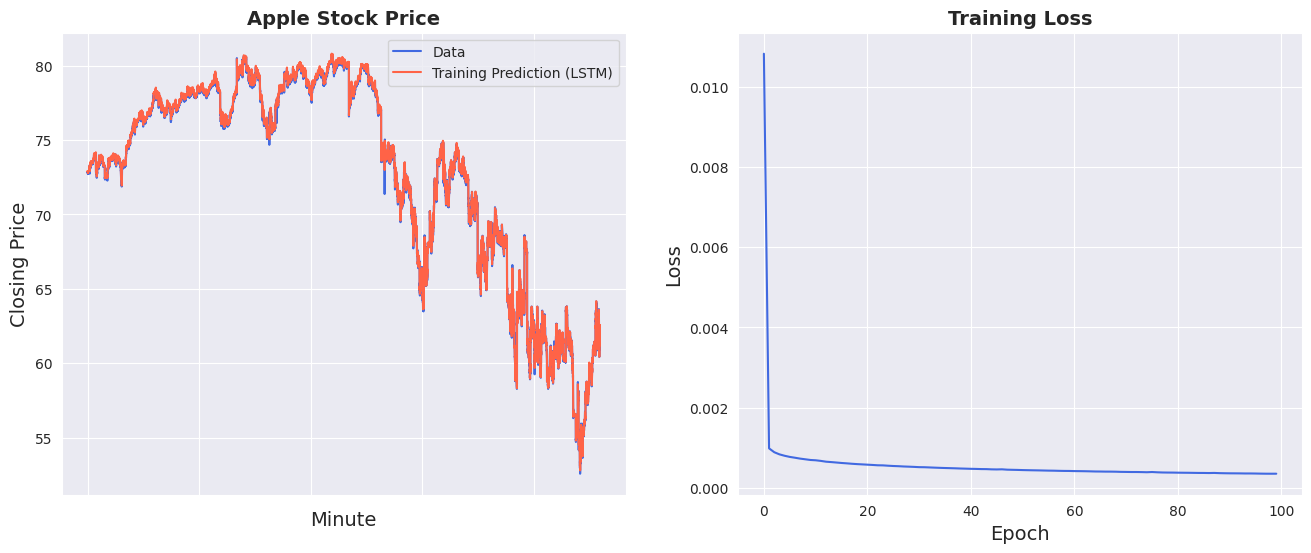

In [53]:
visualize_train_results(yr_model, dataloader, "Apple Stock Price", "Closing Price")

Testing MSE Loss : 0.00020897616923321038


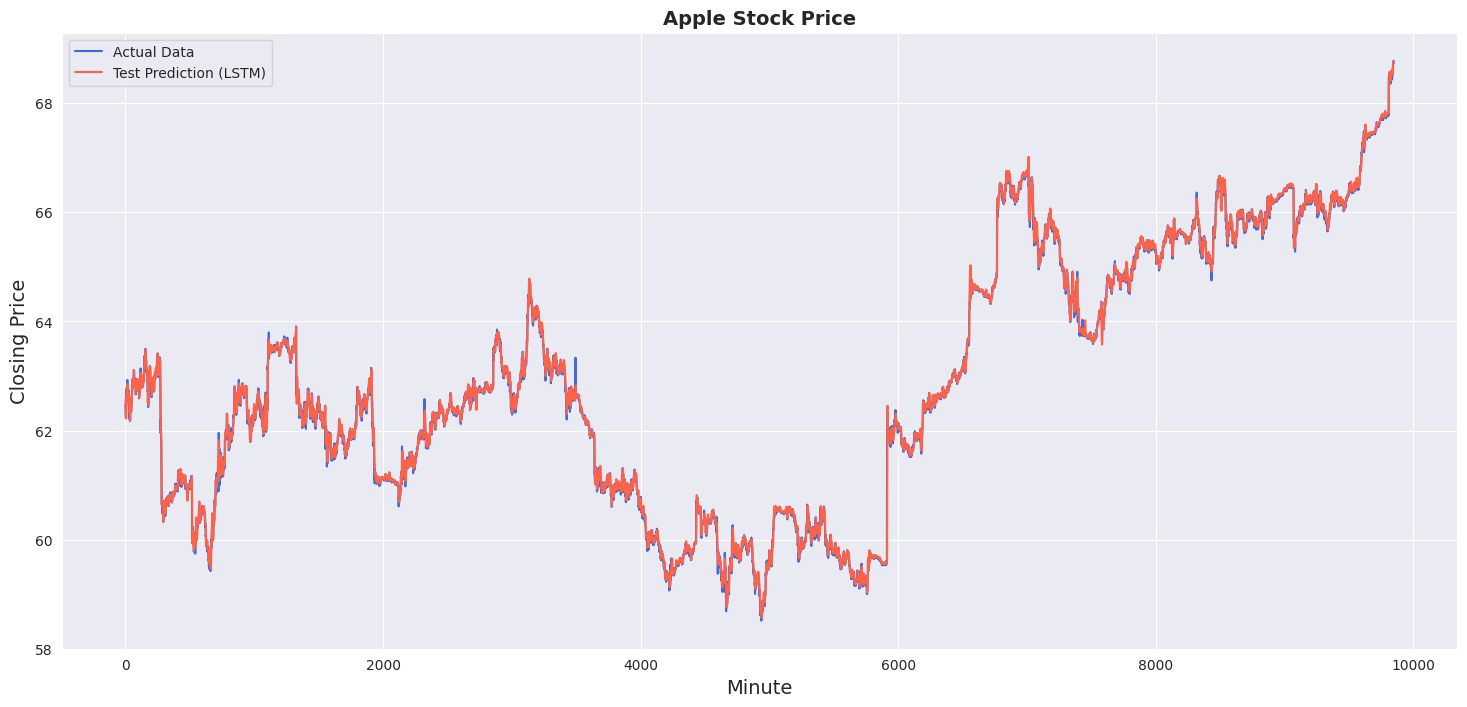

In [54]:
visualize_test_results(yr_model, dataloader, "Apple Stock Price", "Closing Price")

In [55]:
# get data for next quarter (next four month)
multiple_predict_dataloader = LSTMPredictDataLoader(['AAPL'], '2020-05-01 00:00:00', '2020-09-30 23:59:59')
multiple_predict_dataloader.generate_dataset('AAPL', [], input_rows=['close', 'open', 'high', 'low', 'volume'], window_size=25)

Dataloader Created Successfully
X : value_shape: (82226, 24, 5)
Y : value_shape (82226, 1)


### Future Predictions for Single Column Input

Mean Absolute Percentage Error : 0.006104981992393732
Mean Absolute Percentage Error : 0.006821374874562025
Mean Absolute Percentage Error : 0.006427341606467962
Mean Absolute Percentage Error : 0.006231528706848621
Mean Absolute Percentage Error : 0.006363476626574993
Mean Absolute Percentage Error : 0.006788615602999926
Mean Absolute Percentage Error : 0.016048137098550797
Mean Absolute Percentage Error : 0.013990248553454876


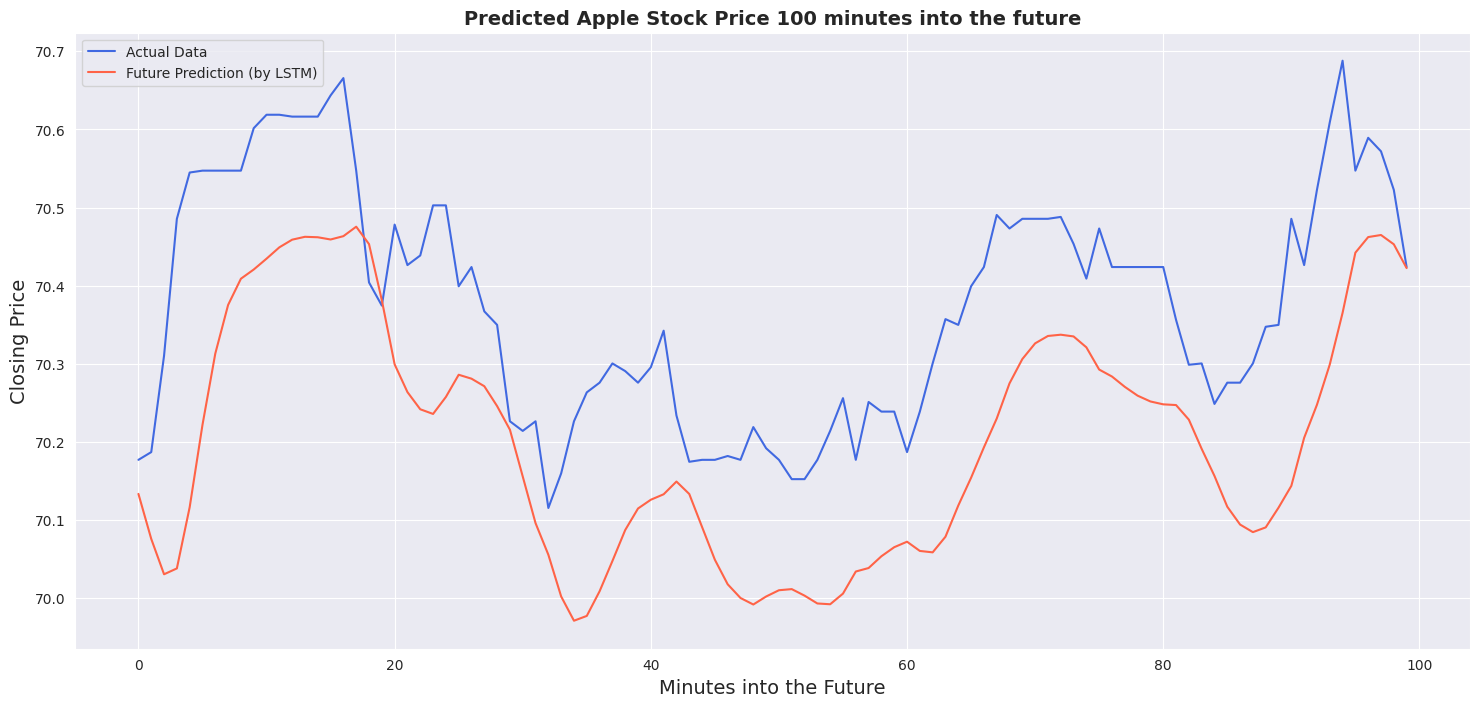

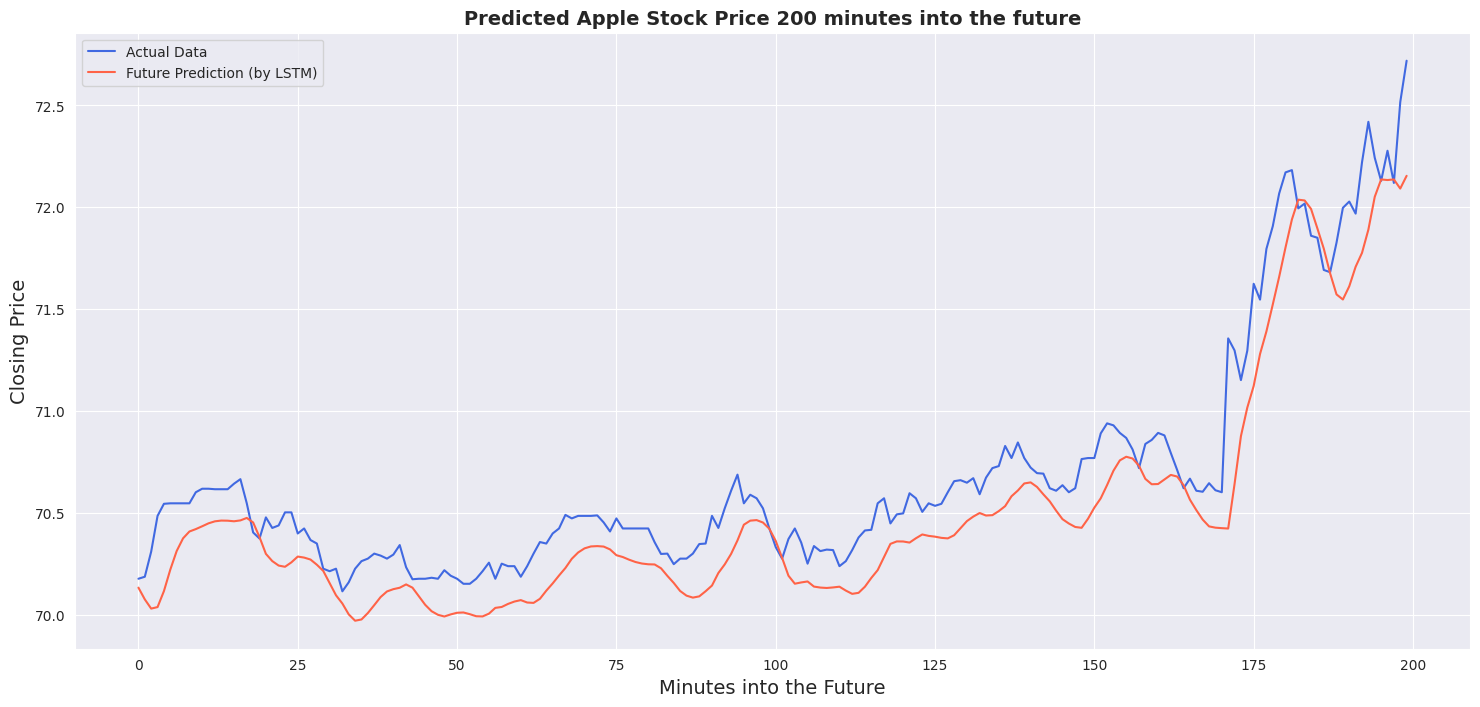

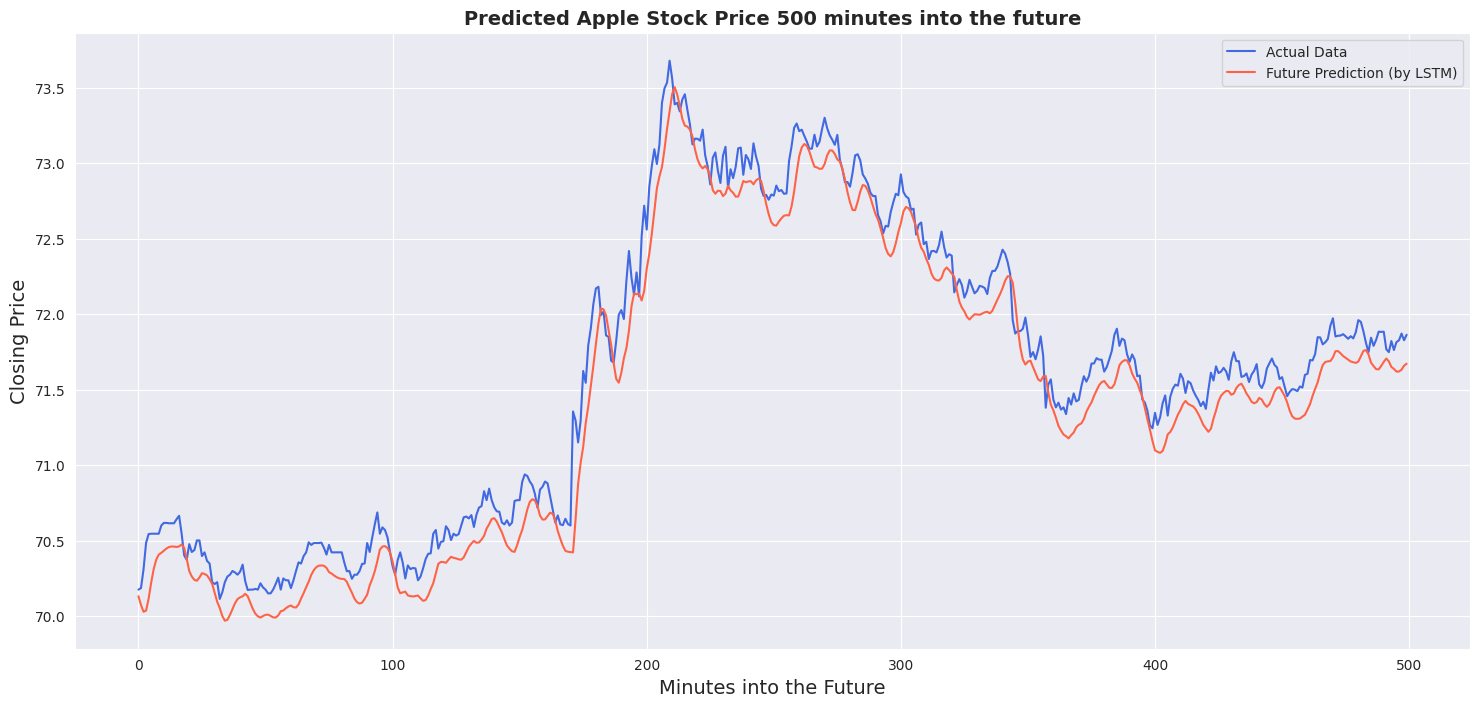

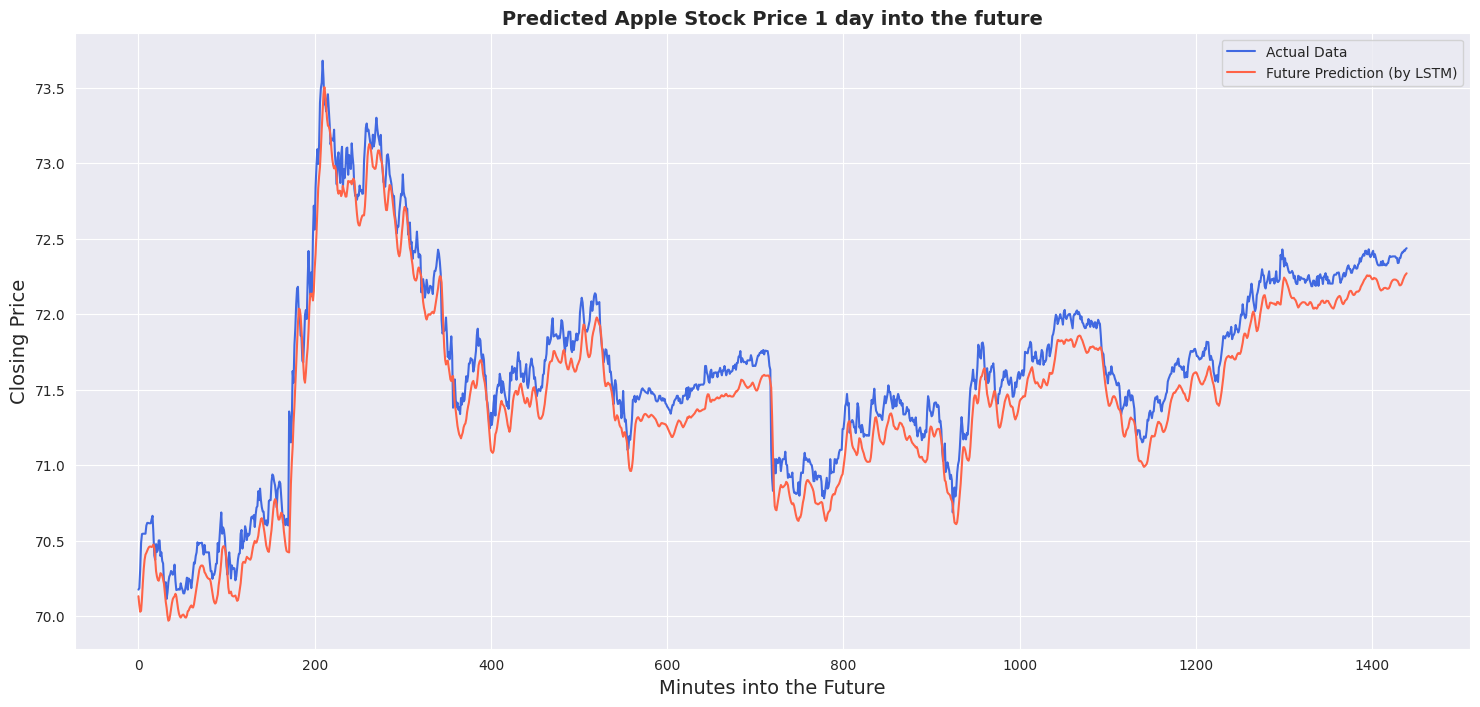

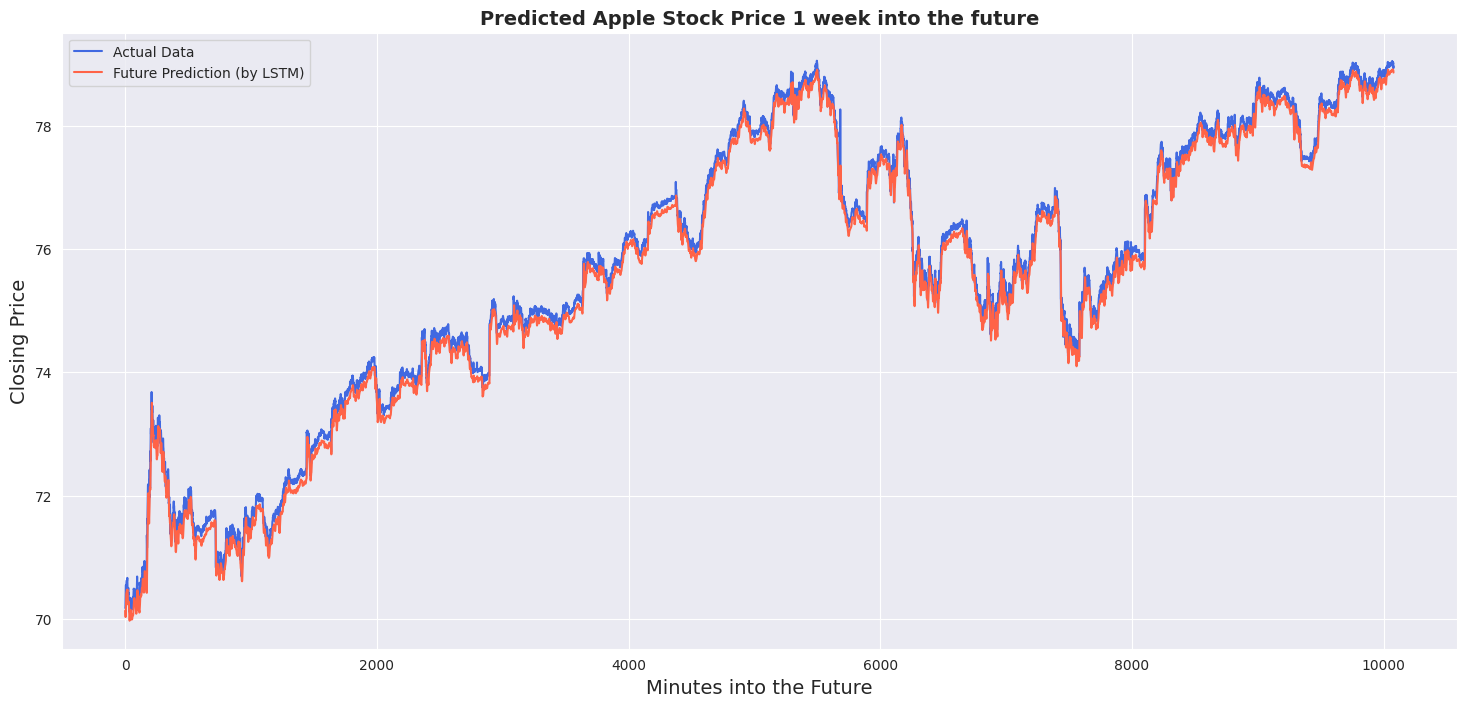

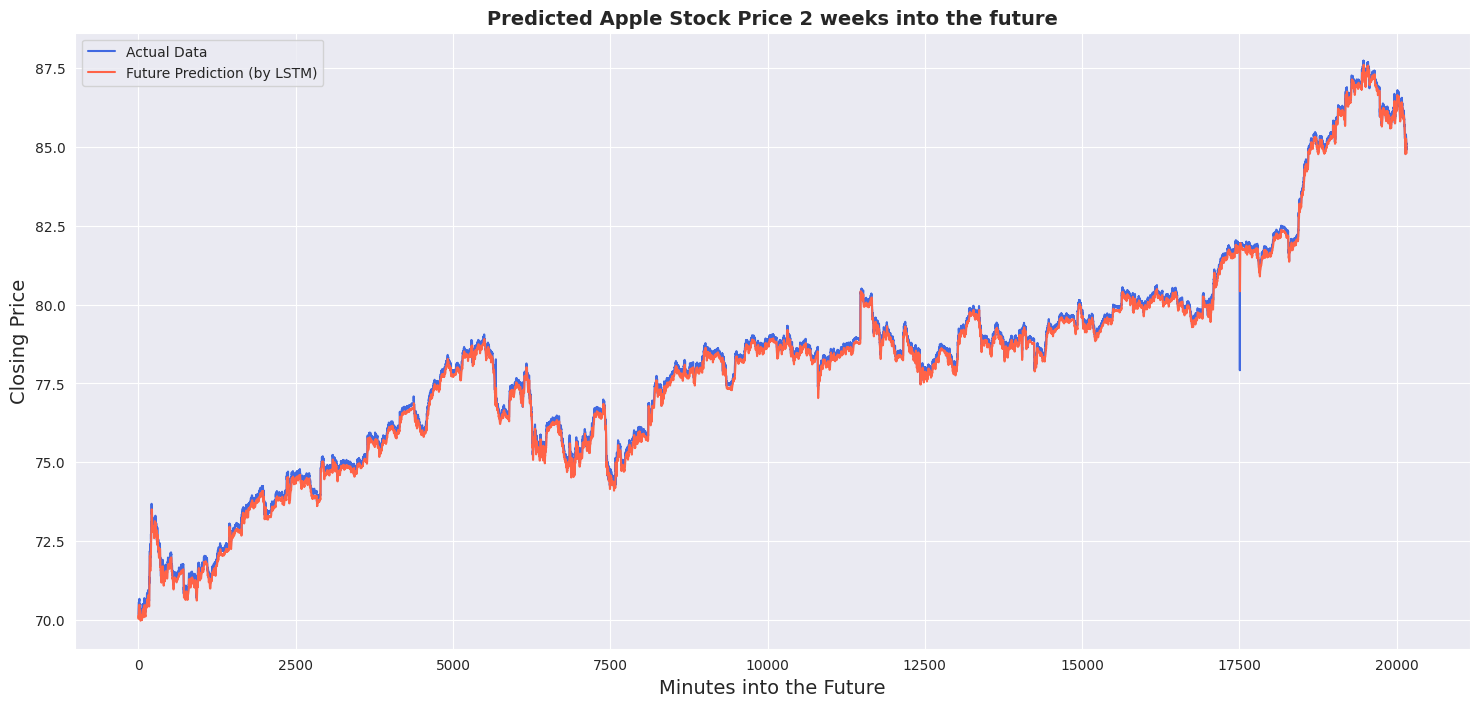

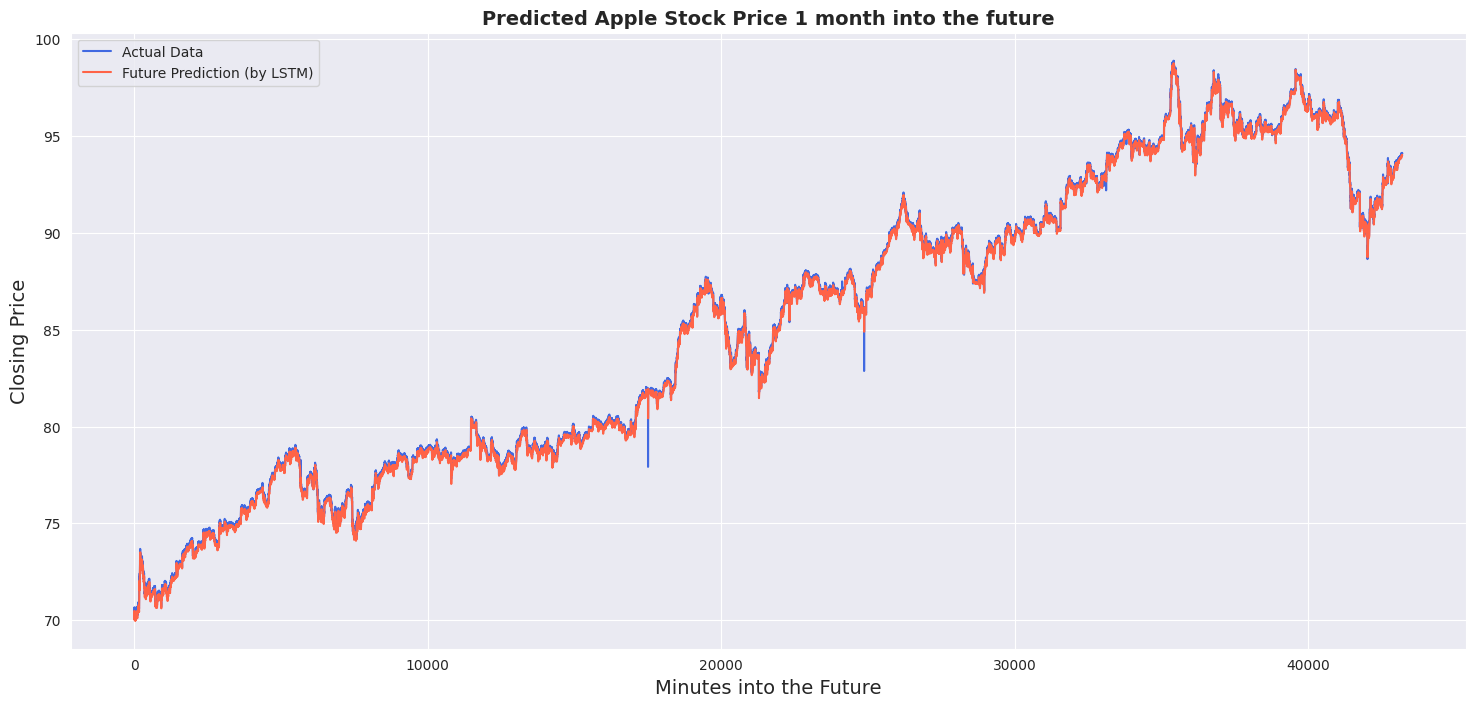

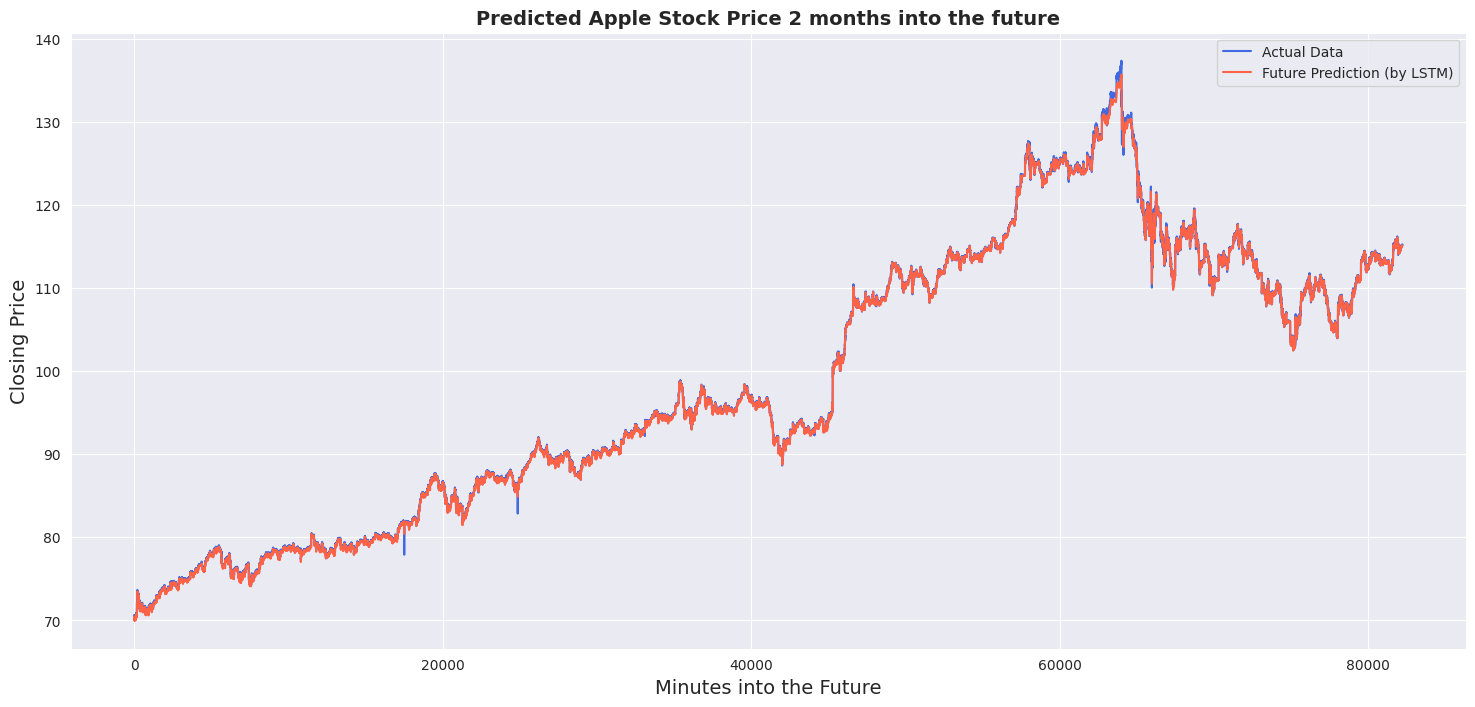

In [56]:
times = [100, 200, 500, 24*60, 7*24*60, 14*24*60, 30*24*60, 60*24*60]
headers = ['100 minutes', '200 minutes', '500 minutes', '1 day', '1 week', '2 weeks', '1 month', '2 months']
single_mape_vec = []
for j, i in enumerate(times):
  single_mape_vec.append(float(predict_for_next_timeframe(single_predict_dataloader, model, i, f"Predicted Apple Stock Price {headers[j]} into the future", "Closing Price")))

### Future Predictions for Multiple Column Input

Mean Absolute Percentage Error : 0.002394012873992324
Mean Absolute Percentage Error : 0.003513121046125889
Mean Absolute Percentage Error : 0.0034245497081428766
Mean Absolute Percentage Error : 0.002576708560809493
Mean Absolute Percentage Error : 0.0023515603970736265
Mean Absolute Percentage Error : 0.0026447249110788107
Mean Absolute Percentage Error : 0.019841386005282402
Mean Absolute Percentage Error : 0.019301313906908035


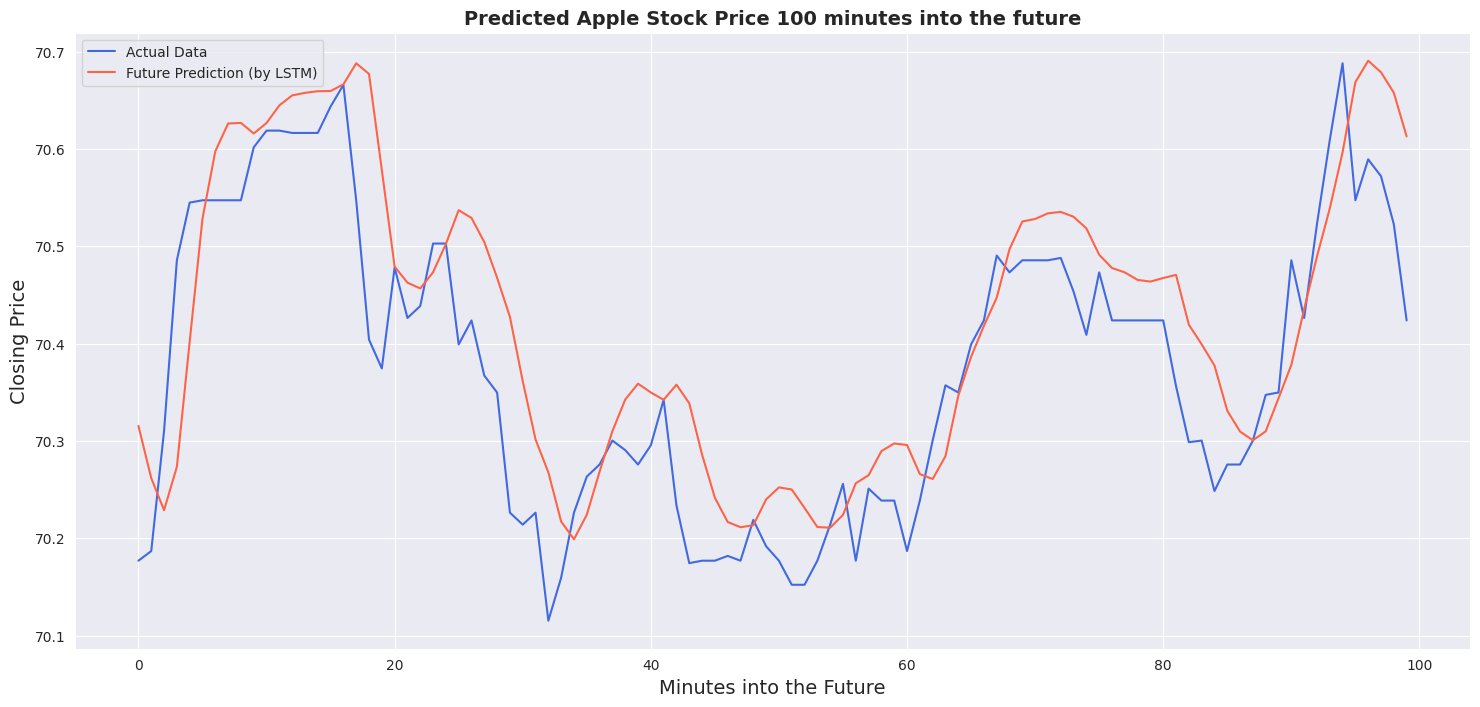

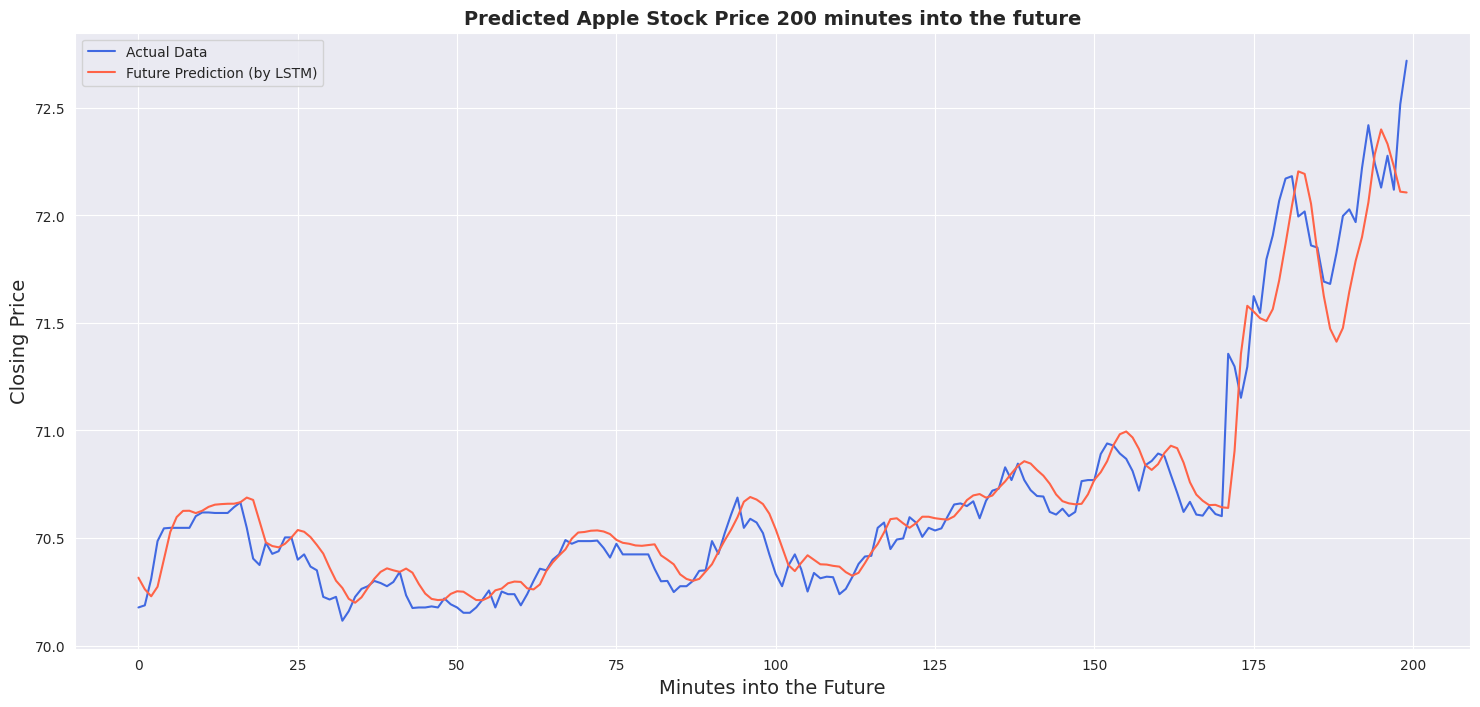

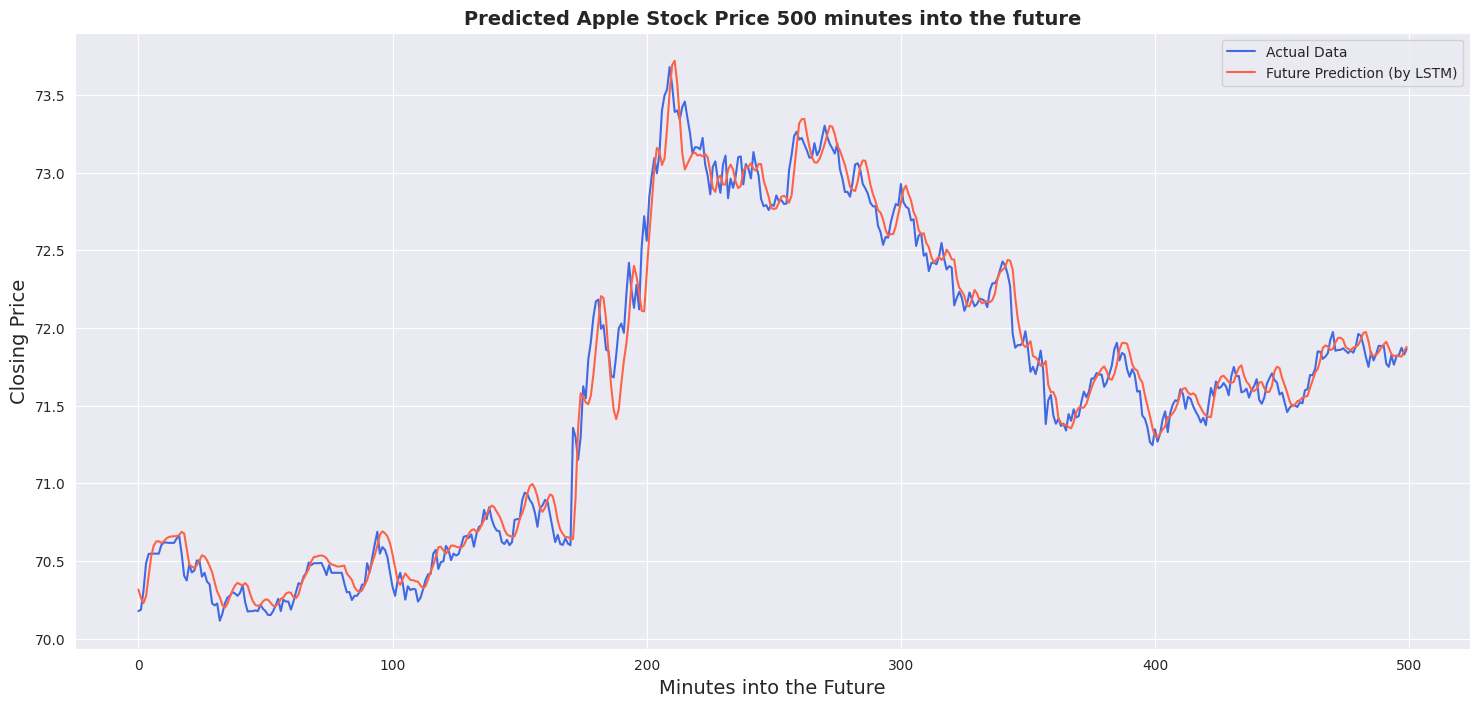

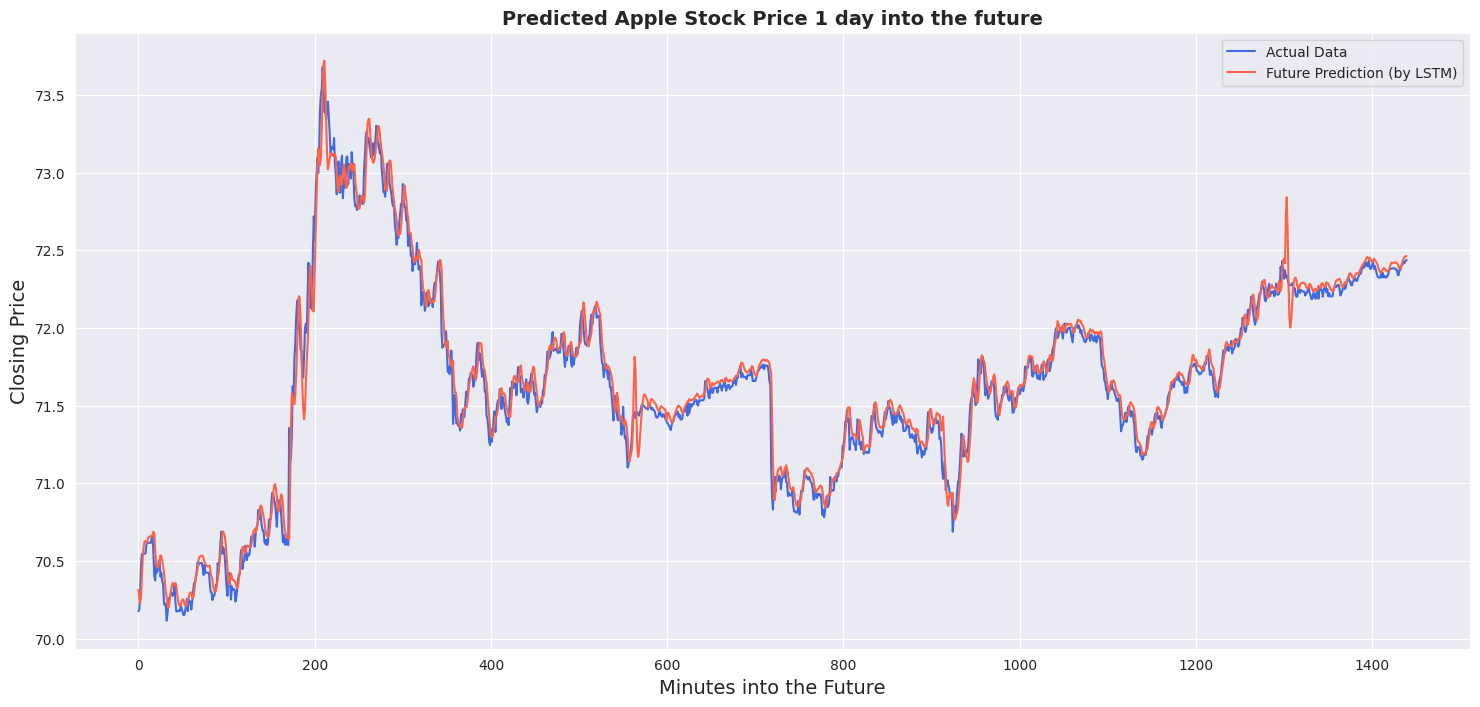

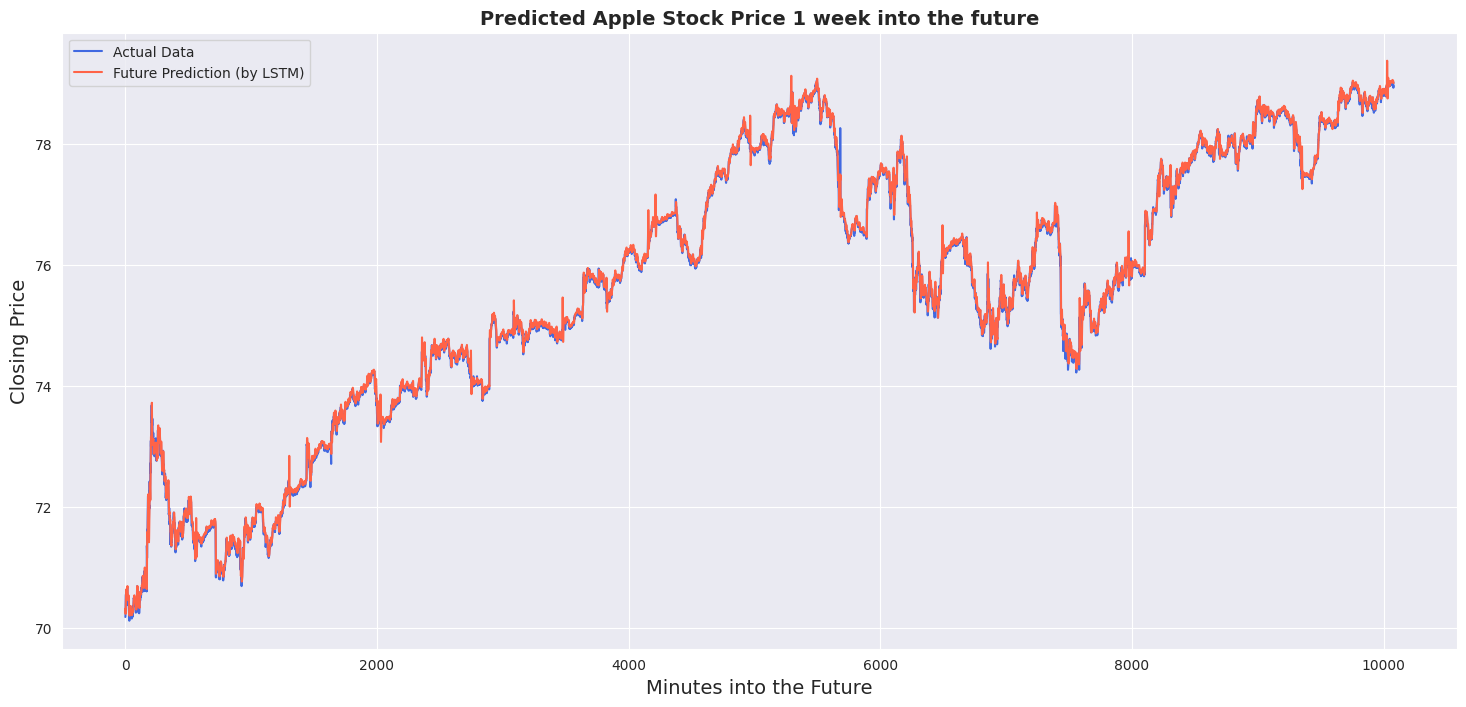

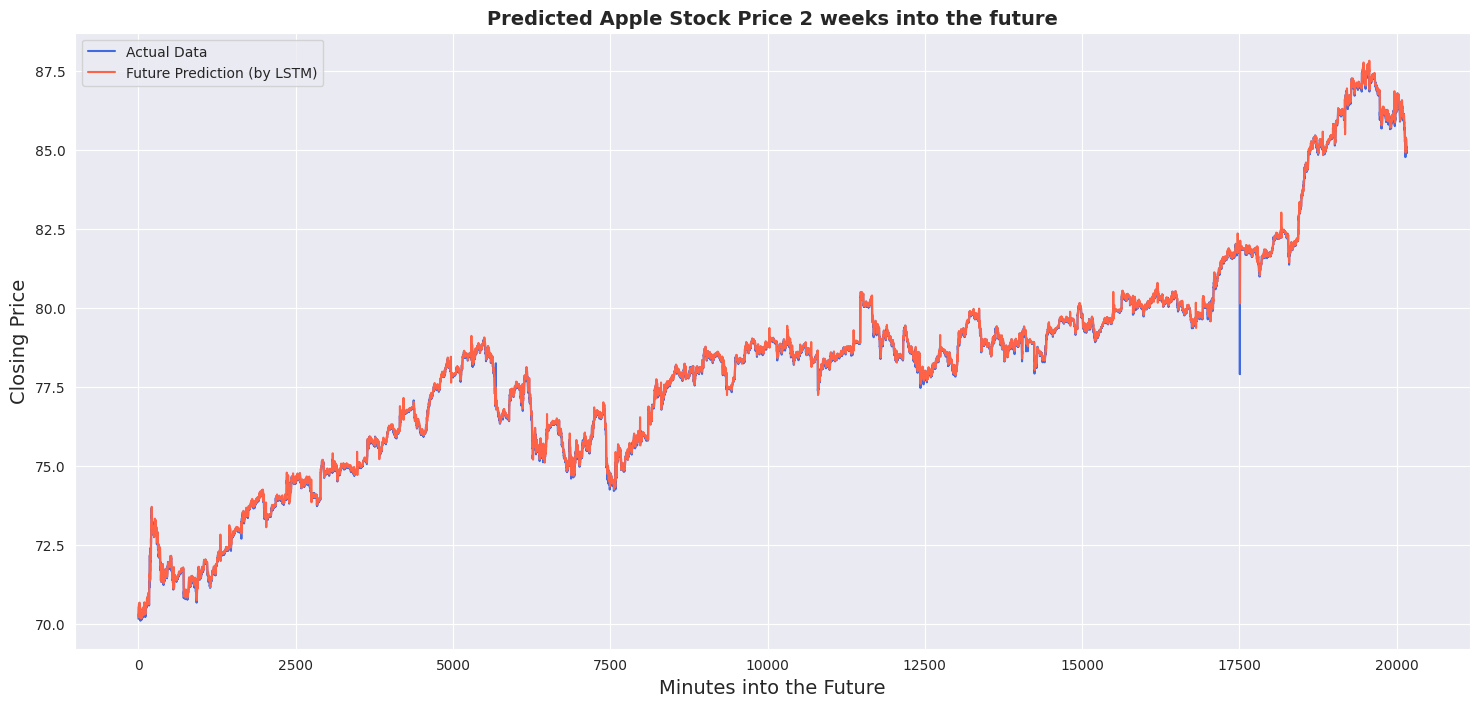

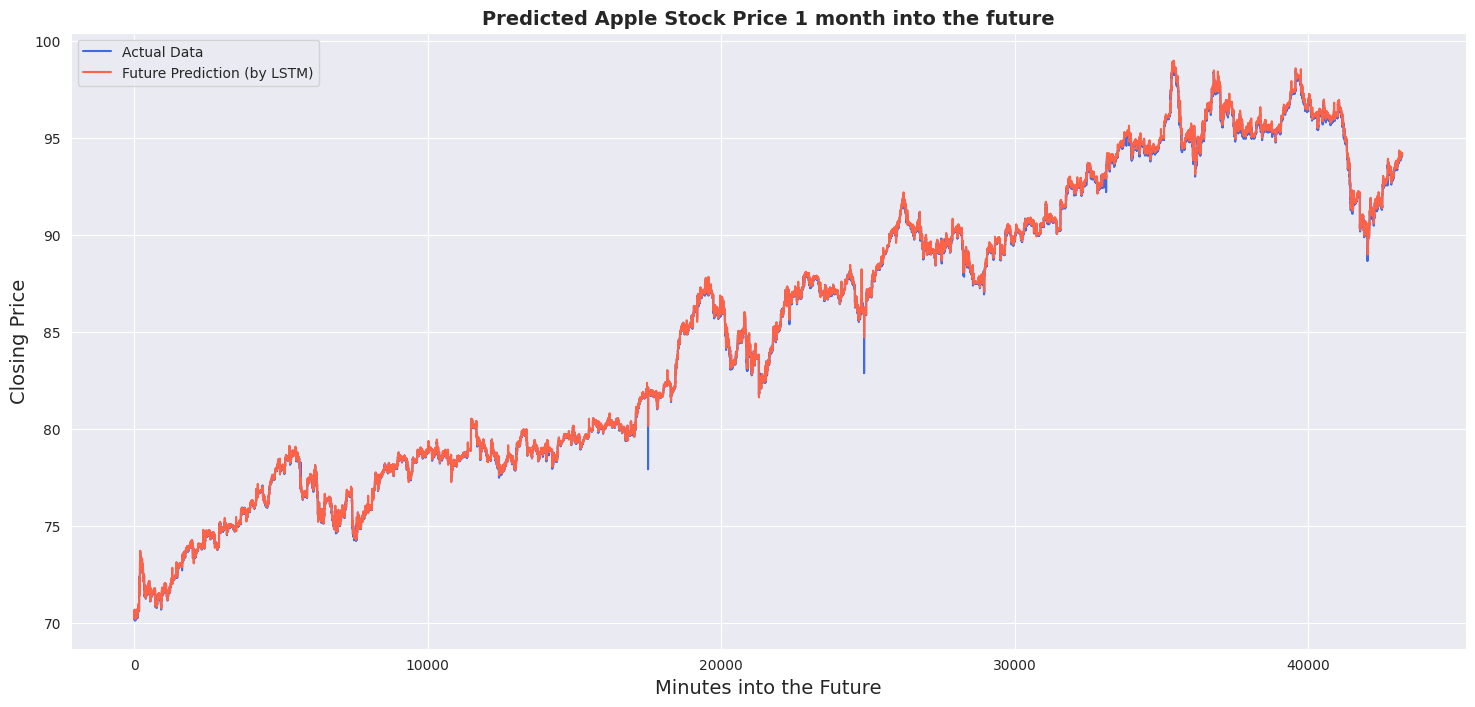

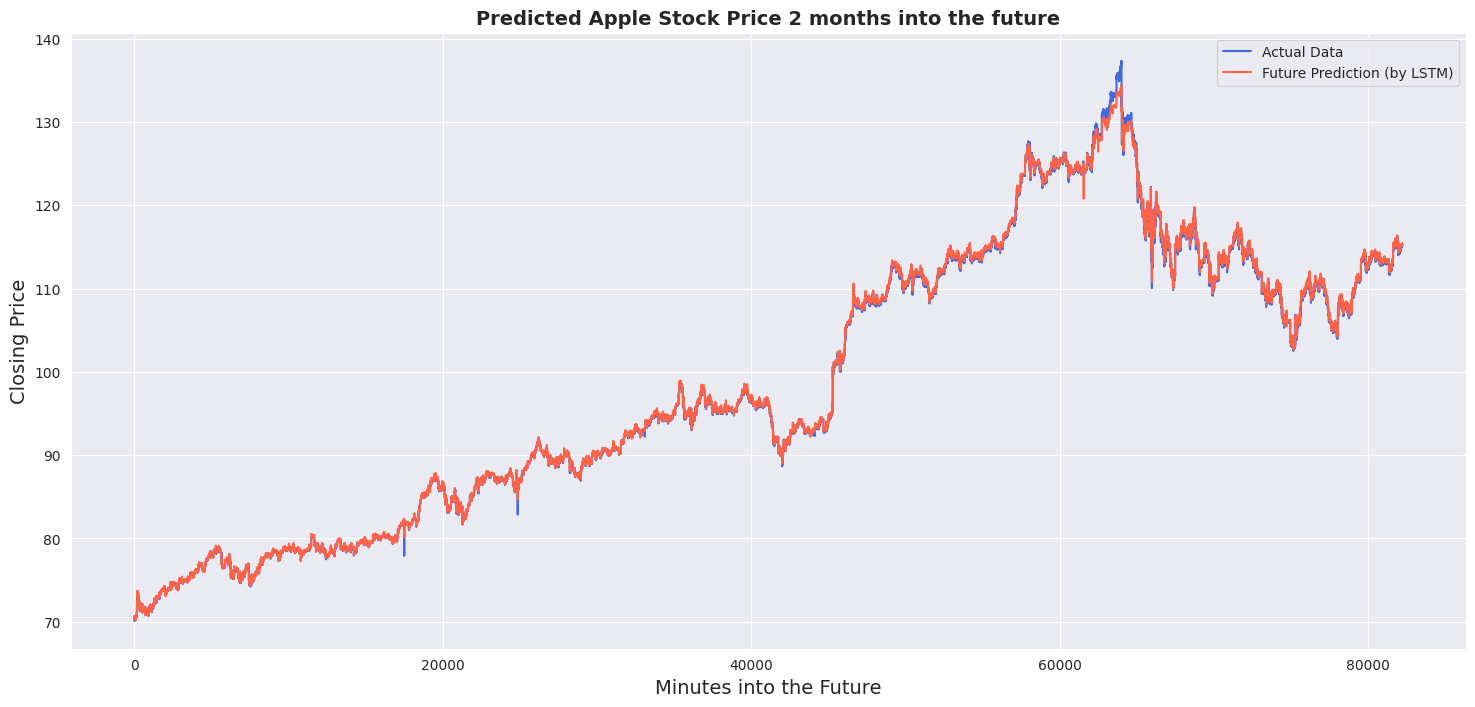

In [57]:
times = [100, 200, 500, 24*60, 7*24*60, 14*24*60, 30*24*60, 60*24*60]
headers = ['100 minutes', '200 minutes', '500 minutes', '1 day', '1 week', '2 weeks', '1 month', '2 months']
multiple_mape_vec = []
for j, i in enumerate(times):
  multiple_mape_vec.append(float(predict_for_next_timeframe(multiple_predict_dataloader, yr_model, i, f"Predicted Apple Stock Price {headers[j]} into the future", "Closing Price")))

## 7) Trading Module

In [58]:
class AlgorithmicTrader():

  def __init__(self, lstm, initial_money, commission_per_trade, buy_ask_spread):
    self.lstm = lstm
    self.curr_money = initial_money
    self.commission_per_trade = commission_per_trade
    self.buy_ask_spread = buy_ask_spread
    self.curr_minute = 0
    self.number_of_stocks = 0

  def get_net_worth(self, price):
    # returns the total money and monetary value of stocks given current price
    return self.curr_money + (price * self.number_of_stocks)

  def buy(self, num_of_stocks, price, debug):
    if(self.curr_money >= price*num_of_stocks + self.commission_per_trade and self.curr_money != 0):
      # check if sufficient money, if so buy the stocks, else do nothing
      self.number_of_stocks += num_of_stocks
      self.curr_money -= (price*num_of_stocks)
      self.curr_money -= self.commission_per_trade
      if debug:
        print(f"Bought : {num_of_stocks} stocks")
    else:
      if debug:
        print("Holding : Did nothing")

  def sell(self, num_of_stocks, price, debug):
    if(self.number_of_stocks >= num_of_stocks and self.number_of_stocks != 0):
      # check if number of stocks to sell, is more than the number of stocks you have
      self.number_of_stocks -= num_of_stocks
      self.curr_money += (price*num_of_stocks)
      self.curr_money -= self.commission_per_trade
      if debug:
        print(f"Sold : {num_of_stocks} stocks")
    else:
      if debug:
        print("Holding : Did nothing")

  def get_max_stocks_buyable(self, price):
    stocks = 0
    # get maximum number of stocks which can be bought for the price given current amount of money
    while(price*stocks + self.commission_per_trade <= self.curr_money):
      stocks += 1
    return stocks - 1

  def reinitialize_after_training(self):
    # set current minute to zero since, to start indexing from zero
    self.curr_minute = 0

  def trade(self, predict_dataloader, trade_after, max_interval, normal_trade_stocks, min_profit_threshold, max_profit_threshold, debug=False):
    start_time = self.curr_minute
    global_max = 0
    curr_iter = 0
    # check if maximum time interval has passed
    while (self.curr_minute - start_time) < max_interval:
      # perform predictions using model
      predict_minute = self.curr_minute + trade_after
      y_test_pred = self.lstm(predict_dataloader.x_value[predict_minute : predict_minute + 1])
      y_test_pred_np = y_test_pred.detach().numpy()
      bv = np.ones((1, 4))
      y_tp_rshp = y_test_pred_np * bv

      y_test_og_np = predict_dataloader.y_value[predict_minute : predict_minute + 1].detach().numpy()
      y_to_rshp = y_test_og_np * bv

      prediction = z_price_scaler.inverse_transform(y_tp_rshp)[0][3]
      current_price = predict_dataloader.y_value[self.curr_minute : self.curr_minute + 1]
      current_price = current_price.detach().numpy()
      bv = np.ones((1, 4))
      current_price = current_price * bv
      current_price = z_price_scaler.inverse_transform(current_price)[0][3]
      # check if the current price is larger than the global maxima since the start
      global_max = max(global_max, current_price)
      # check the value of predicted profit considering buy ask spread and commission per trade
      pred_profit = (prediction - (current_price + self.buy_ask_spread)) * normal_trade_stocks - self.commission_per_trade

      if curr_iter == 0:
         print("Start Net Worth: ", self.get_net_worth(current_price))

      if debug:
        print("---------------------------------------")
        print(f"Current minute {self.curr_minute}")
        print(f"Global maximal price", global_max)
        print("Current price :", current_price)
        print("Current money :", self.curr_money)
        print("Current stocks :", self.number_of_stocks)
        print(f"Net Worth :", self.get_net_worth(current_price))
        print("Predicted Price :", prediction)
        print("Predicted Profit :", pred_profit)
        print("---------------------------------------\n\n")

      if(pred_profit >= max_profit_threshold and prediction > global_max):
        # check if the predicted price is greater than global maxima, and if the profit predicted is greater than max threshold
        if debug:
          print("Did First Option")
        # buy as many stocks you can for the money which you have
        self.buy(self.get_max_stocks_buyable(current_price + self.buy_ask_spread), current_price + self.buy_ask_spread, debug)
      elif(pred_profit >= min_profit_threshold and prediction > global_max):
        # check if the predicted price is greater than global maxima, and if the profit predicted is greater than min threshold
        if debug:
          print("Did Second Option")
        # buy the normal number of stocks which you buy regularly
        self.buy(normal_trade_stocks, current_price + self.buy_ask_spread, debug)
      else:
        # otherwise sell all the stocks that you own
        if debug:
          print("Did Last Option")
        self.sell(self.number_of_stocks, current_price - self.buy_ask_spread, debug)

      self.curr_minute = self.curr_minute + trade_after
      curr_iter += 1
    print("End Net Worth: ", self.get_net_worth(current_price))

In [59]:
class BuyAndHoldTrader():
  # the module which does a normal buy and sell after said time period
  def __init__(self, initial_money, commission_per_trade, buy_ask_spread):
    self.curr_money = initial_money
    self.commission_per_trade = commission_per_trade
    self.buy_ask_spread = buy_ask_spread
    self.curr_minute = 0
    self.number_of_stocks = 0

  def get_net_worth(self, price):
    return self.curr_money + (price * self.number_of_stocks)

  def buy(self, num_of_stocks, price, debug):
    if(self.curr_money >= price*num_of_stocks + self.commission_per_trade and self.curr_money != 0):
      self.number_of_stocks += num_of_stocks
      self.curr_money -= (price*num_of_stocks)
      self.curr_money -= self.commission_per_trade
      if debug:
        print(f"Bought : {num_of_stocks} stocks")
    else:
      if debug:
        print("Holding : Did nothing")

  def sell(self, num_of_stocks, price, debug):
    if(self.number_of_stocks >= num_of_stocks and self.number_of_stocks != 0):
      self.number_of_stocks -= num_of_stocks
      self.curr_money += (price*num_of_stocks)
      self.curr_money -= self.commission_per_trade
      if debug:
        print(f"Sold : {num_of_stocks} stocks")
    else:
      if debug:
        print("Holding : Did nothing")

  def get_max_stocks_buyable(self, price):
    stocks = 0
    while(price*stocks + self.commission_per_trade <= self.curr_money):
      stocks += 1
    return stocks - 1

  def trade(self, predict_dataloader, max_interval, debug=False):
    sell_minute = self.curr_minute + max_interval
    bv = np.ones((1, 4))
    # get price for selling minute
    y_test_og_np = predict_dataloader.y_value[sell_minute : sell_minute + 1].detach().numpy()
    y_to_rshp = y_test_og_np * bv

    sell_price = z_price_scaler.inverse_transform(y_to_rshp)[0][3]
    # get current price
    current_price = predict_dataloader.y_value[self.curr_minute : self.curr_minute + 1]
    current_price = current_price.detach().numpy()
    bv = np.ones((1, 4))
    current_price = current_price * bv
    current_price = z_price_scaler.inverse_transform(current_price)[0][3]

    print("Start Net Worth: ", self.get_net_worth(current_price))
    # buy as many stocks with the money for current price
    self.buy(self.get_max_stocks_buyable(current_price + self.buy_ask_spread), current_price + self.buy_ask_spread, debug)
    # sell all the stocks for the selling price
    self.sell(self.number_of_stocks, sell_price - self.buy_ask_spread, debug)
    print("End Net Worth: ", self.get_net_worth(sell_price))

    self.curr_minute = sell_minute

### With no commission and buy-ask spread

### The Single Input Feature LSTM

In [60]:
algo_trader = AlgorithmicTrader(model, 10000, 0, 0)

In [61]:
algo_trader.trade(single_predict_dataloader, 10, 1*24*60, 5, 0.3, 0.5, False)

Start Net Worth:  10000.0
End Net Worth:  10503.507648853301


### The Multiple Input Feature LSTM

In [62]:
algo_trader_m = AlgorithmicTrader(yr_model, 10000, 0, 0)

In [63]:
algo_trader_m.trade(multiple_predict_dataloader, 10, 1*24*60, 5, 0.3, 0.5, False)

Start Net Worth:  10000.0
End Net Worth:  10537.556193640034


### Simple Buy and Hold Strategy

In [64]:
normal_trader = BuyAndHoldTrader(10000, 0, 0)

In [65]:
normal_trader.trade(single_predict_dataloader, 1*24*60, True)

Start Net Worth:  10000.0
Bought : 142 stocks
Sold : 142 stocks
End Net Worth:  10321.1066081974


### With commission and buy-ask spread

Assuming that the commission per trade is 1 USD and the buy ask spread is 5 cents (average values used for high frequency trading in NYSE as per the internet) as discussed above in Q3

### The Single Input Feature LSTM

In [66]:
algo_trader = AlgorithmicTrader(model, 10000, 1, 0.05)

In [67]:
algo_trader.trade(single_predict_dataloader, 10, 1*24*60, 5, 0.3, 0.5, False)

Start Net Worth:  10000.0
End Net Worth:  10329.372387466017


### The Multiple Input Feature LSTM

In [68]:
algo_trader_m = AlgorithmicTrader(yr_model, 10000, 1, 0.05)

In [69]:
algo_trader_m.trade(multiple_predict_dataloader, 10, 1*24*60, 5, 0.3, 0.5, False)

Start Net Worth:  10000.0
End Net Worth:  10379.95240768247


### Simple Buy and Hold Strategy

In [70]:
normal_trader = BuyAndHoldTrader(10000, 1, 0.05)

In [71]:
normal_trader.trade(single_predict_dataloader, 1*24*60, True)

Start Net Worth:  10000.0
Bought : 142 stocks
Sold : 142 stocks
End Net Worth:  10304.9066081974


## 8) Testing the Trading Module

### 8a) Plotting Prediction Error from time last trained

### Prediction comparison for single input vs multiple inputs to the LSTM

In [72]:
def visualize_mape(headers, *mape_vecs):
    x = np.array(range(len(headers)))
    plt.figure(figsize=(14, 5))
    plt.bar(x, mape_vecs[0], label='single input (close)', color='blue', alpha=0.7, width=0.1)
    plt.bar(x + 0.1, mape_vecs[1], label='multiple input (close, open, high, low, volume)', color='red', alpha=0.7, width=0.1)
    # Adding labels and title
    plt.xticks(x, headers)
    plt.xlabel('Minutes into the Future')
    plt.ylabel('Price Prediction Error (MAPE)')
    plt.title('Comparison of various methods')
    plt.legend()

    # Adjusting the layout for better visibility
    plt.tight_layout()

    # Show the plot
    plt.show()

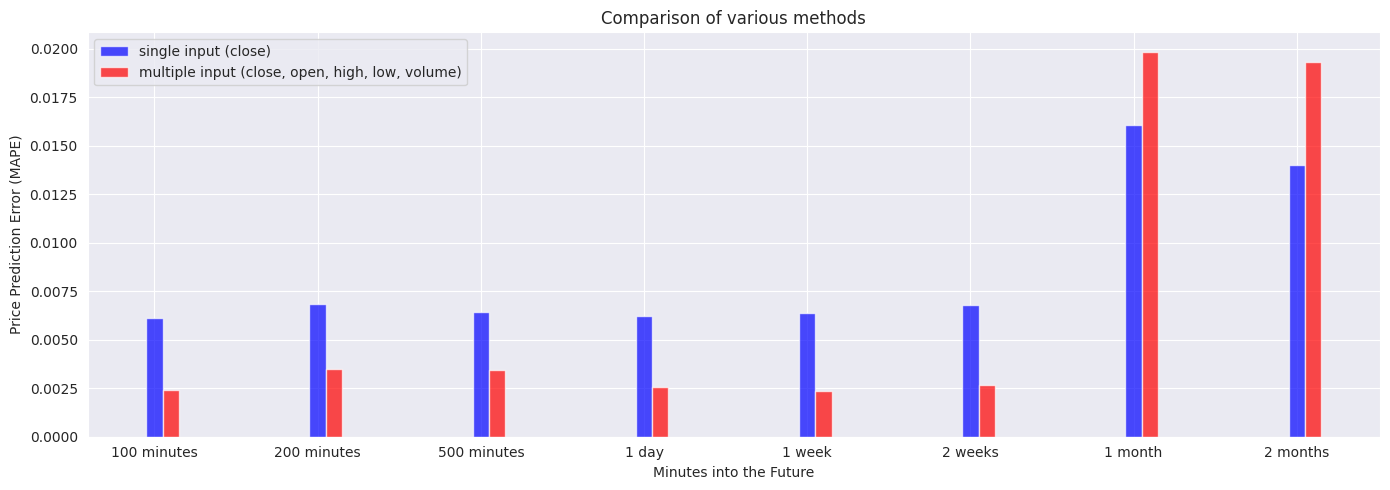

In [73]:
visualize_mape(headers, single_mape_vec, multiple_mape_vec)

Thus we see that the prediction error is less when we include more number of inputs, and the LSTM performs better and have lesser MAPE for more inputs, but becomes worse as the time from not being trained increases to greater than a month

We see that the error is minimal for short durations of time (upto 1-2 weeks), but becomes progressively larger as the time duration increases upto a month and so on

### To test the training module on a long duration on later years we shall follow the following strategy. We will perform the test for a duration of one year (2021)

- The buy and hold trader will just buy maximum possible stocks, wait for one year and sell the stocks

- We saw from the MAPEs evaluated that LSTM starts to perform poorly as the timeframe exceeds more 2 months, hence we shall perform retraining on the passed quarter once every 4 months

- To maximize retention of stock price knowledge, algorithmic trader will train on every four months data and predict for the next 4 months and use the LSTM to predict prices



### Buy and Hold Trader

In [ ]:
# get data for next year
bh_predict_dataloader = LSTMPredictDataLoader(['AAPL'], '2021-01-01 00:00:00', '2022-01-31 23:59:59')
bh_predict_dataloader.generate_dataset('AAPL', window_size=25)

Dataloader Created Successfully
X : value_shape: (224358, 24, 1)
Y : value_shape (224358, 1)


In [ ]:
normal_trader = BuyAndHoldTrader(10000, 0, 0)
normal_trader.trade(bh_predict_dataloader, 224357, True)

Start Net Worth:  10000.0
Bought : 75 stocks
Sold : 75 stocks
End Net Worth:  13091.880530932862


In [ ]:
cnormal_trader = BuyAndHoldTrader(10000, 1, 0.05)
cnormal_trader.trade(bh_predict_dataloader, 224357, True)

Start Net Worth:  10000.0
Bought : 75 stocks
Sold : 75 stocks
End Net Worth:  13082.380530932858


### Algorithmic Trader

In [ ]:
# get training dataloaders in quarters
at_dataloader_1 = LSTMTrainDataLoader(['AAPL'], '2020-09-01 00:00:00', '2020-12-31 23:59:59')
at_dataloader_1.generate_dataset('AAPL', [], ['close', 'open', 'high', 'low', 'volume'], batch_size=batch_size, shuffle=True, window_size=25)
at_dataloader_2 = LSTMTrainDataLoader(['AAPL'], '2021-01-01 00:00:00', '2021-04-30 23:59:59')
at_dataloader_2.generate_dataset('AAPL', [], ['close', 'open', 'high', 'low', 'volume'], batch_size=batch_size, shuffle=True, window_size=25)
at_dataloader_3 = LSTMTrainDataLoader(['AAPL'], '2021-05-01 00:00:00', '2021-08-30 23:59:59')
at_dataloader_3.generate_dataset('AAPL', [], ['close', 'open', 'high', 'low', 'volume'], batch_size=batch_size, shuffle=True, window_size=25)

(75142, 5)
X : train_shape: (52581, 24, 5) test_shape: (11268, 24, 5) valid_shape: (11268, 24, 5)
Y : train_shape (52581, 1) test_shape: (11268, 1) valid_shape: (11268, 1)
Dataloader Created Successfully
(71207, 5)
X : train_shape: (49828, 24, 5) test_shape: (10677, 24, 5) valid_shape: (10677, 24, 5)
Y : train_shape (49828, 1) test_shape: (10677, 1) valid_shape: (10677, 1)
Dataloader Created Successfully
(66342, 5)
X : train_shape: (46421, 24, 5) test_shape: (9948, 24, 5) valid_shape: (9948, 24, 5)
Y : train_shape (46421, 1) test_shape: (9948, 1) valid_shape: (9948, 1)
Dataloader Created Successfully


In [ ]:
at_predict_dataloader_1 = LSTMPredictDataLoader(['AAPL'], '2021-01-01 00:00:00', '2021-04-30 23:59:59')
at_predict_dataloader_1.generate_dataset('AAPL', [], input_rows=['close', 'open', 'high', 'low', 'volume'], window_size=25)
at_predict_dataloader_2 = LSTMPredictDataLoader(['AAPL'], '2021-05-01 00:00:00', '2021-08-30 23:59:59')
at_predict_dataloader_2.generate_dataset('AAPL', [], input_rows=['close', 'open', 'high', 'low', 'volume'], window_size=25)
at_predict_dataloader_3 = LSTMPredictDataLoader(['AAPL'], '2021-09-01 00:00:00', '2021-12-31 23:59:59')
at_predict_dataloader_3.generate_dataset('AAPL', [], input_rows=['close', 'open', 'high', 'low', 'volume'], window_size=25)

Dataloader Created Successfully
X : value_shape: (71182, 24, 5)
Y : value_shape (71182, 1)
Dataloader Created Successfully
X : value_shape: (66317, 24, 5)
Y : value_shape (66317, 1)
Dataloader Created Successfully
X : value_shape: (68771, 24, 5)
Y : value_shape (68771, 1)


In [ ]:
input_dim = 5
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100
batch_size = 64

In [ ]:
at_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adagrad(at_model.parameters(), lr=0.005)
at_model

LSTM(
  (lstm): LSTM(5, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
algo_trader = AlgorithmicTrader(at_model, 10000, 0, 0)
calgo_trader = AlgorithmicTrader(at_model, 10000, 1, 0.05)

In [ ]:
hist = train_model(at_model, num_epochs, at_dataloader_1, 10)

Epoch  0 Train MSE:  0.009070491988847481 Validation MSE:  0.000381713775281144 Time taken for Epoch: 4.8658363819122314
Epoch  1 Train MSE:  0.0011792801488165396 Validation MSE:  0.0002623987612509964 Time taken for Epoch: 4.858092546463013
Epoch  2 Train MSE:  0.0010864829463352293 Validation MSE:  0.0002278533016477084 Time taken for Epoch: 5.9765331745147705
Epoch  3 Train MSE:  0.0010321786897109682 Validation MSE:  0.00020768642891481645 Time taken for Epoch: 4.792353868484497
Epoch  4 Train MSE:  0.000993140148099624 Validation MSE:  0.00018721435394238934 Time taken for Epoch: 5.922513008117676
Epoch  5 Train MSE:  0.0009623502569754355 Validation MSE:  0.0002996817375210379 Time taken for Epoch: 4.768824100494385
Epoch  6 Train MSE:  0.000934277445521464 Validation MSE:  0.00021099275480950173 Time taken for Epoch: 4.841482162475586
Epoch  7 Train MSE:  0.0009114045906532103 Validation MSE:  0.00017346205576317306 Time taken for Epoch: 5.932449102401733
Epoch  8 Train MSE:  0

In [ ]:
algo_trader.trade(at_predict_dataloader_1, 10, 71180, 5, 0.3, 0.5, False)
calgo_trader.trade(at_predict_dataloader_1, 10, 71180, 5, 0.3, 0.5, False)

Start Net Worth:  10000.0
End Net Worth:  11437.768771461604
Start Net Worth:  10000.0
End Net Worth:  11024.939403333703


In [ ]:
hist = train_model(at_model, num_epochs, at_dataloader_2, 10)

Epoch  0 Train MSE:  0.0004787102836174191 Validation MSE:  5.774689599070925e-05 Time taken for Epoch: 5.4699413776397705
Epoch  1 Train MSE:  0.0004723290945497426 Validation MSE:  5.814899502600638e-05 Time taken for Epoch: 5.2099244594573975
Epoch  2 Train MSE:  0.0004679440206109692 Validation MSE:  5.5599913264227854e-05 Time taken for Epoch: 4.656888008117676
Epoch  3 Train MSE:  0.0004627435383870654 Validation MSE:  6.050002158821808e-05 Time taken for Epoch: 5.80205225944519
Epoch  4 Train MSE:  0.00046042080296166733 Validation MSE:  5.6510395049123486e-05 Time taken for Epoch: 4.714840650558472
Epoch  5 Train MSE:  0.00045482083591013857 Validation MSE:  5.438132826146217e-05 Time taken for Epoch: 5.098423719406128
Epoch  6 Train MSE:  0.00045224194152381414 Validation MSE:  5.7437419316752916e-05 Time taken for Epoch: 5.285566329956055
Epoch  7 Train MSE:  0.00044910664652348395 Validation MSE:  5.494208326523637e-05 Time taken for Epoch: 4.667673587799072
Epoch  8 Train M

In [ ]:
algo_trader.reinitialize_after_training()
calgo_trader.reinitialize_after_training()

In [ ]:
algo_trader.trade(at_predict_dataloader_2, 10, 66310, 5, 0.3, 0.5, False)
calgo_trader.trade(at_predict_dataloader_2, 10, 66310, 5, 0.3, 0.5, False)

Start Net Worth:  11437.768771461604
End Net Worth:  14842.123066225406
Start Net Worth:  11024.939403333703
End Net Worth:  12575.541056509031


In [ ]:
hist = train_model(at_model, num_epochs, at_dataloader_3, 10)

Epoch  0 Train MSE:  6.231275886147818e-05 Validation MSE:  1.5276093973091723e-05 Time taken for Epoch: 4.566396236419678
Epoch  1 Train MSE:  6.187662571898249e-05 Validation MSE:  1.458674100317932e-05 Time taken for Epoch: 4.312010765075684
Epoch  2 Train MSE:  6.174514659425628e-05 Validation MSE:  1.4563368755717763e-05 Time taken for Epoch: 5.3747735023498535
Epoch  3 Train MSE:  6.164401523568382e-05 Validation MSE:  1.5676846627929964e-05 Time taken for Epoch: 4.28536319732666
Epoch  4 Train MSE:  6.147082991602291e-05 Validation MSE:  1.4847579363295129e-05 Time taken for Epoch: 4.4017627239227295
Epoch  5 Train MSE:  6.146775722199715e-05 Validation MSE:  1.445143132980226e-05 Time taken for Epoch: 5.425621509552002
Epoch  6 Train MSE:  6.173439697321111e-05 Validation MSE:  1.836353883284501e-05 Time taken for Epoch: 4.414352893829346
Epoch  7 Train MSE:  6.138210983533773e-05 Validation MSE:  1.4786009969436384e-05 Time taken for Epoch: 4.3443098068237305
Epoch  8 Train MS

In [ ]:
algo_trader.reinitialize_after_training()
calgo_trader.reinitialize_after_training()

In [ ]:
algo_trader.trade(at_predict_dataloader_3, 10, 68770, 5, 0.3, 0.5, False)
calgo_trader.trade(at_predict_dataloader_3, 10, 68770, 5, 0.3, 0.5, False)

Start Net Worth:  14842.123066225406
End Net Worth:  18380.584076367446
Start Net Worth:  12575.541056509031
End Net Worth:  14268.192608895608


### Thus the net-worth after performing the four possible trading methods can be ordered as follows
### $net-worth_{algo-without-charges} \ge net-worth_{algo-with-charges} \ge net-worth_{buy-hold-without-charges} \ge net-worth_{buy-hold-with-charges}$

## 8b) Thus from the above analysis, we can conclude the following
- Trading with commission and buy ask spreads is not as profitable as without having them
- However, we see that it is still profitable to trade using the LSTM based trading strategy since we are generating sufficiently large profits even though it is a form of high frequency trading and the number of trades will be large.

## 8c) Thus from the above analysis, we can conclude the following
- The algorithmic trading which makes use of LSTM trained on the data of the previous quarter (4 months) performs exceedingly better than the regular buy and hold strategy, even in the presence of commission and buy ask spread

# Advanced (Bonus)

## 9a) Using multiple stock prices (AMD + AAPL) to predict the prices of AAPL
- We will provide all the inputs (close, open, high, low and volume) and use same parameters as in Q6 to allow comparison

In [ ]:
ms_dataloader = LSTMTrainDataLoader(['AAPL', 'AMD'], '2020-01-01 00:00:00', '2020-06-30 23:59:59')
ms_dataloader.generate_dataset('AAPL', ['AMD'], ['close', 'open', 'high', 'low', 'volume'], batch_size=batch_size, shuffle=True, window_size=25)

(86597, 10)
X : train_shape: (60600, 24, 10) test_shape: (12986, 24, 10) valid_shape: (12986, 24, 10)
Y : train_shape (60600, 1) test_shape: (12986, 1) valid_shape: (12986, 1)
Dataloader Created Successfully


In [ ]:
input_dim = 10
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100
batch_size = 64

In [ ]:
ms_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adagrad(ms_model.parameters(), lr=0.005)
ms_model

LSTM(
  (lstm): LSTM(10, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
hist = train_model(ms_model, num_epochs, ms_dataloader, 10)

Epoch  0 Train MSE:  0.00854681764467233 Validation MSE:  0.08357220790580057 Time taken for Epoch: 8.258846759796143
Epoch  1 Train MSE:  0.0005828075981199832 Validation MSE:  0.07843873700974735 Time taken for Epoch: 6.733619451522827
Epoch  2 Train MSE:  0.0005127079207249774 Validation MSE:  0.07587486684888822 Time taken for Epoch: 5.833446264266968
Epoch  3 Train MSE:  0.00048056367160005 Validation MSE:  0.07437726136182908 Time taken for Epoch: 6.838636159896851
Epoch  4 Train MSE:  0.0004574288661268893 Validation MSE:  0.0721219130403263 Time taken for Epoch: 5.802598476409912
Epoch  5 Train MSE:  0.00043862237183941647 Validation MSE:  0.07072077937022937 Time taken for Epoch: 6.948051452636719
Epoch  6 Train MSE:  0.0004259263665284794 Validation MSE:  0.06911791337077695 Time taken for Epoch: 5.821424961090088
Epoch  7 Train MSE:  0.0004143773013410068 Validation MSE:  0.0682667612777718 Time taken for Epoch: 6.8148181438446045
Epoch  8 Train MSE:  0.0004024249818149601 V

In [ ]:
torch.save(ms_model, 'multiple_stock_multiple_feature.pt')

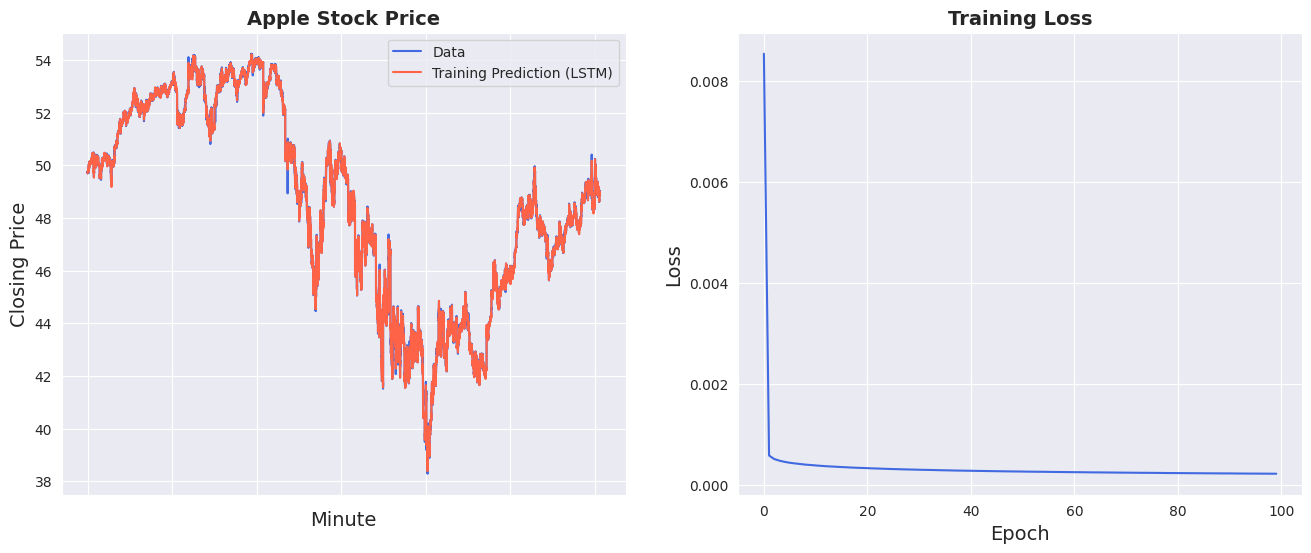

In [ ]:
visualize_train_results(ms_model, ms_dataloader, "Apple Stock Price", "Closing Price")

Testing MSE Loss : 0.00010800767631735653


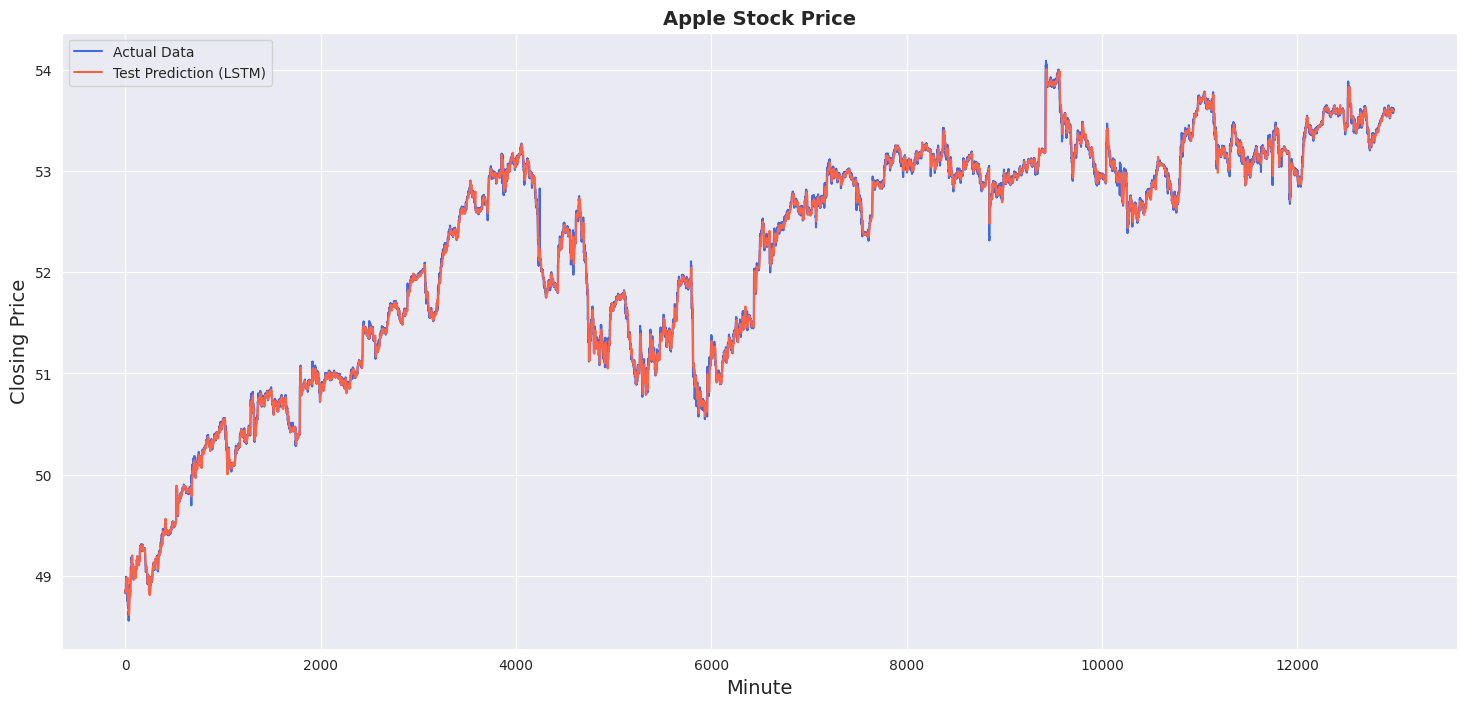

In [ ]:
visualize_test_results(ms_model, ms_dataloader, "Apple Stock Price", "Closing Price")

In [ ]:
# get data for next quarter (next four month)
ms_predict_dataloader = LSTMPredictDataLoader(['AAPL', 'AMD'], '2020-07-01 00:00:00', '2020-12-31 23:59:59')
ms_predict_dataloader.generate_dataset('AAPL', ['AMD'], input_rows=['close', 'open', 'high', 'low', 'volume'], window_size=25)

Dataloader Created Successfully
X : value_shape: (85928, 24, 10)
Y : value_shape (85928, 1)


### Future Predictions for Multiple Stock Analysis (AMD + AAPL)

Mean Absolute Percentage Error : 0.002312193624675274
Mean Absolute Percentage Error : 0.0025182527024298906
Mean Absolute Percentage Error : 0.0020651165395975113
Mean Absolute Percentage Error : 0.0022008356172591448
Mean Absolute Percentage Error : 0.003733015386387706
Mean Absolute Percentage Error : 0.05483998358249664
Mean Absolute Percentage Error : 0.1276506930589676
Mean Absolute Percentage Error : 0.18349595367908478


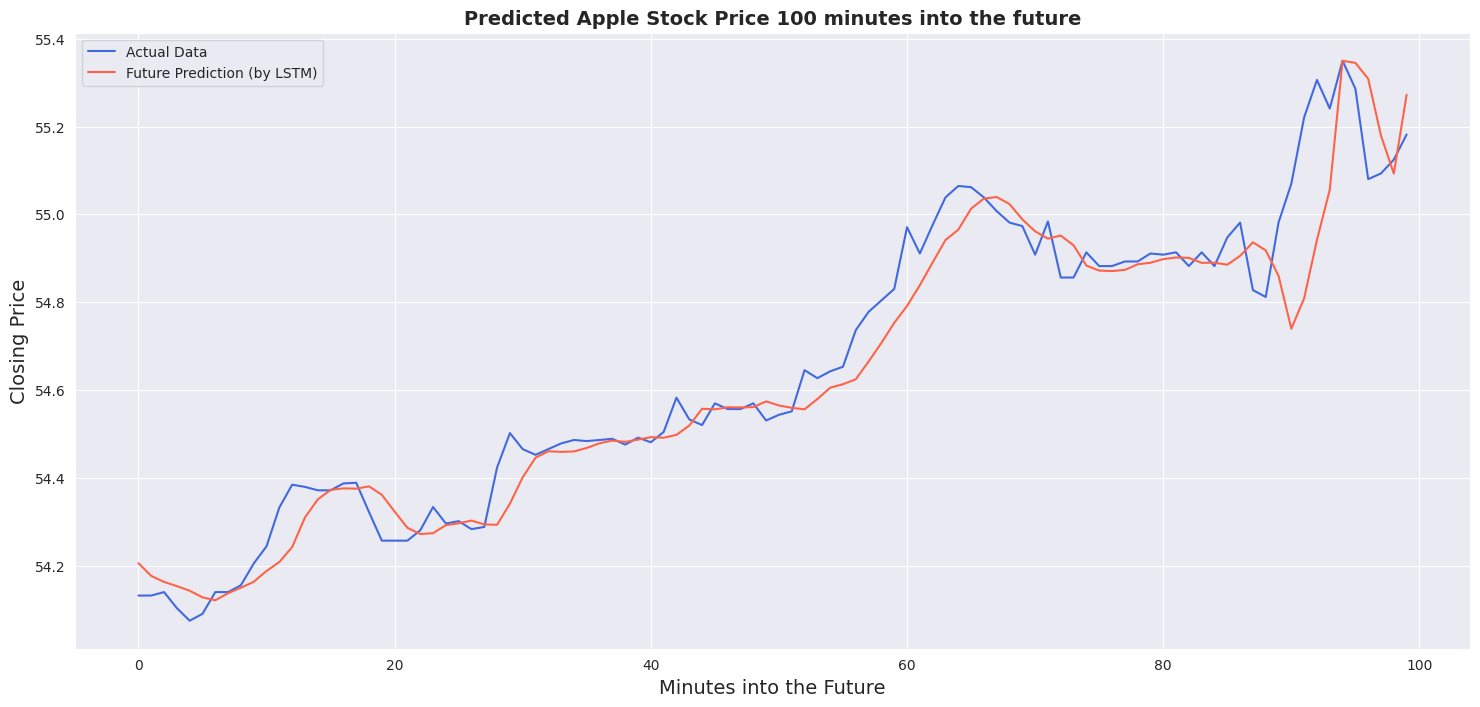

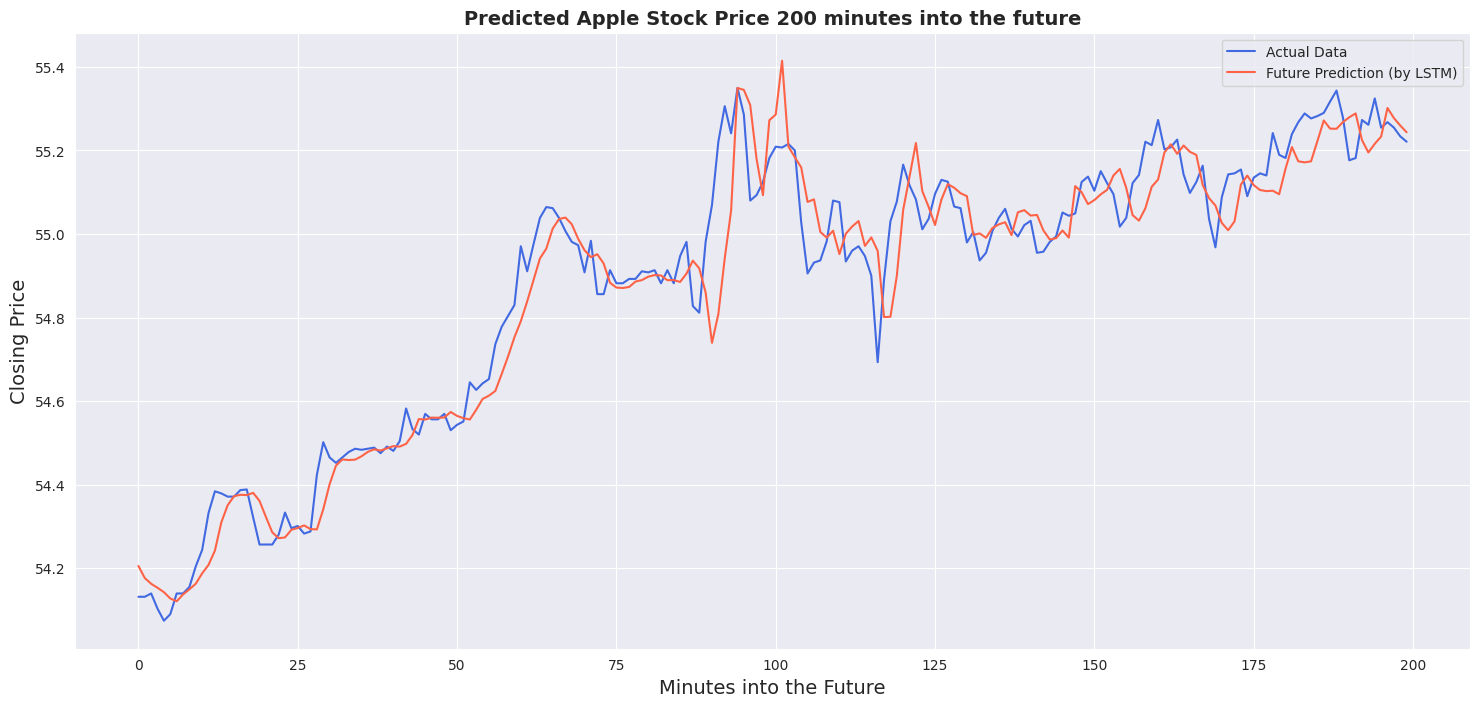

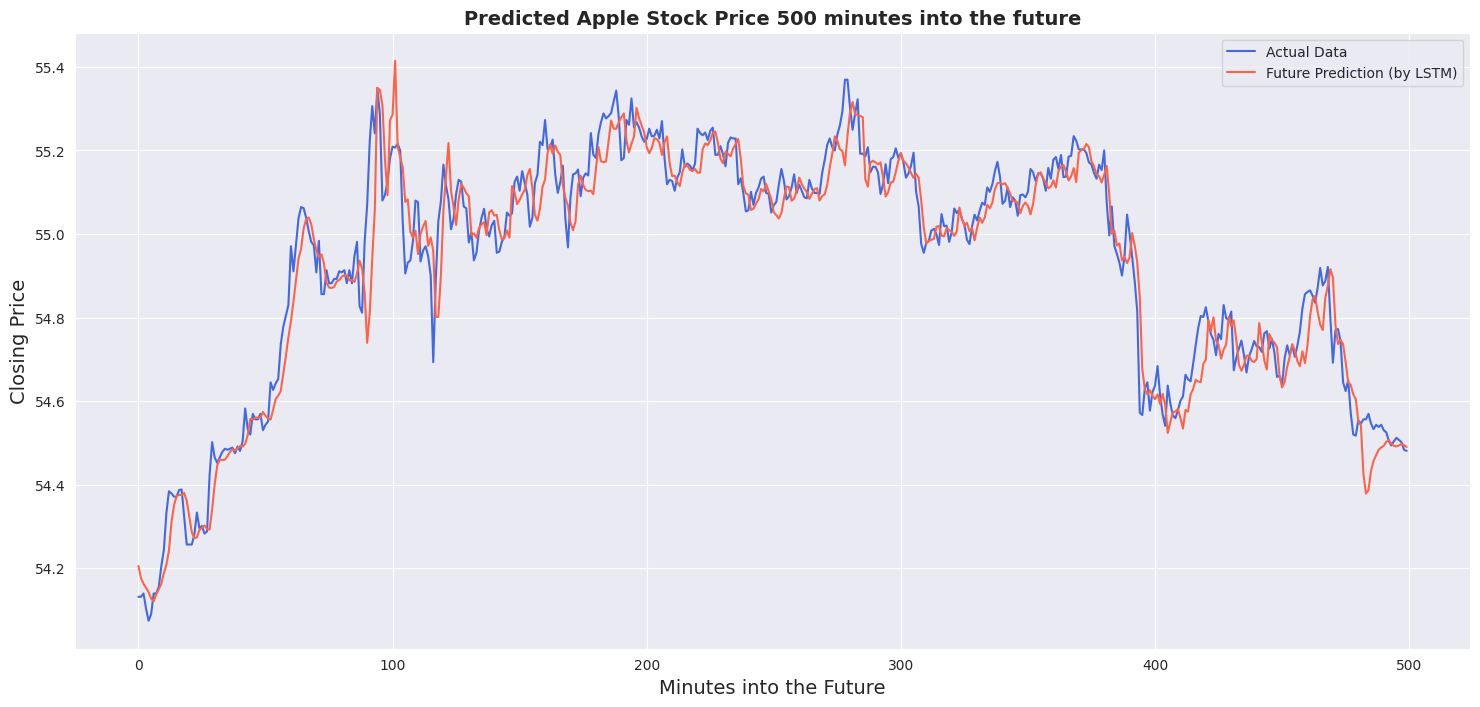

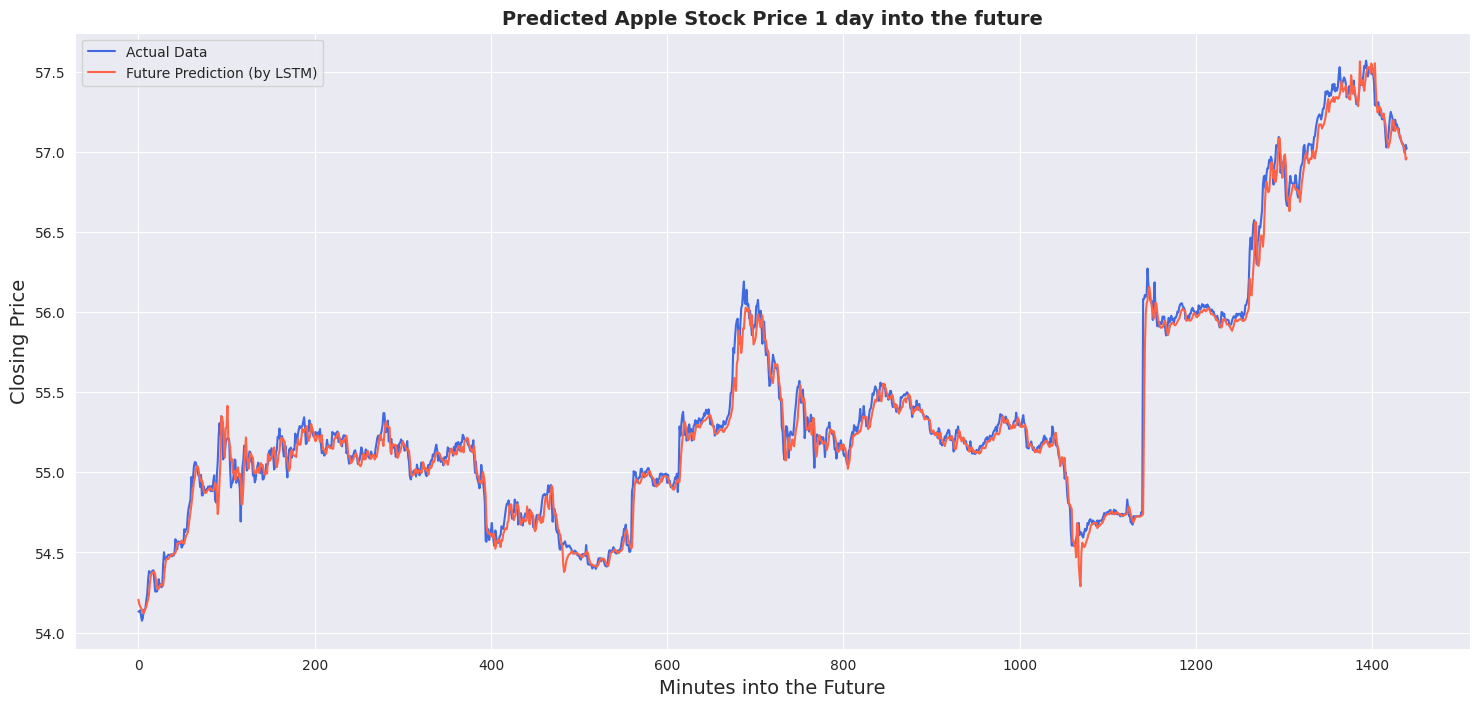

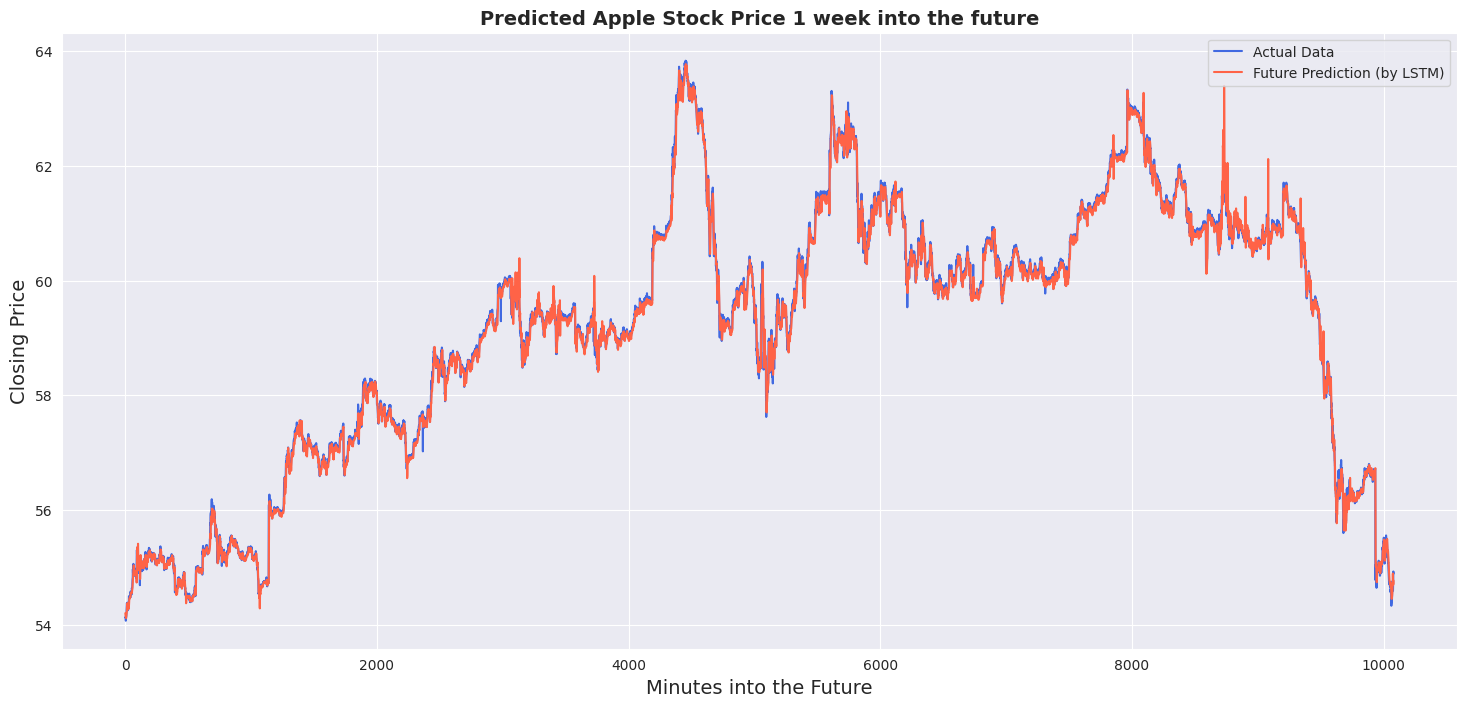

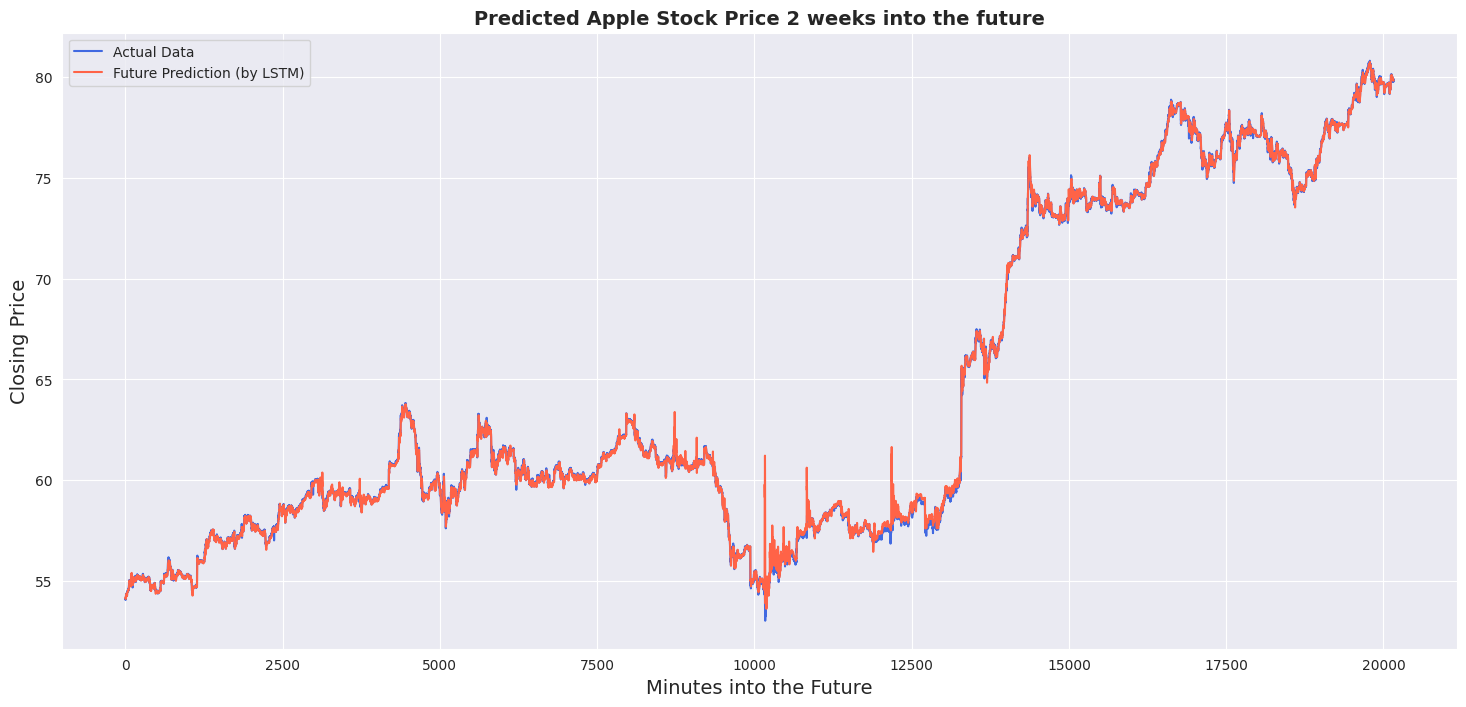

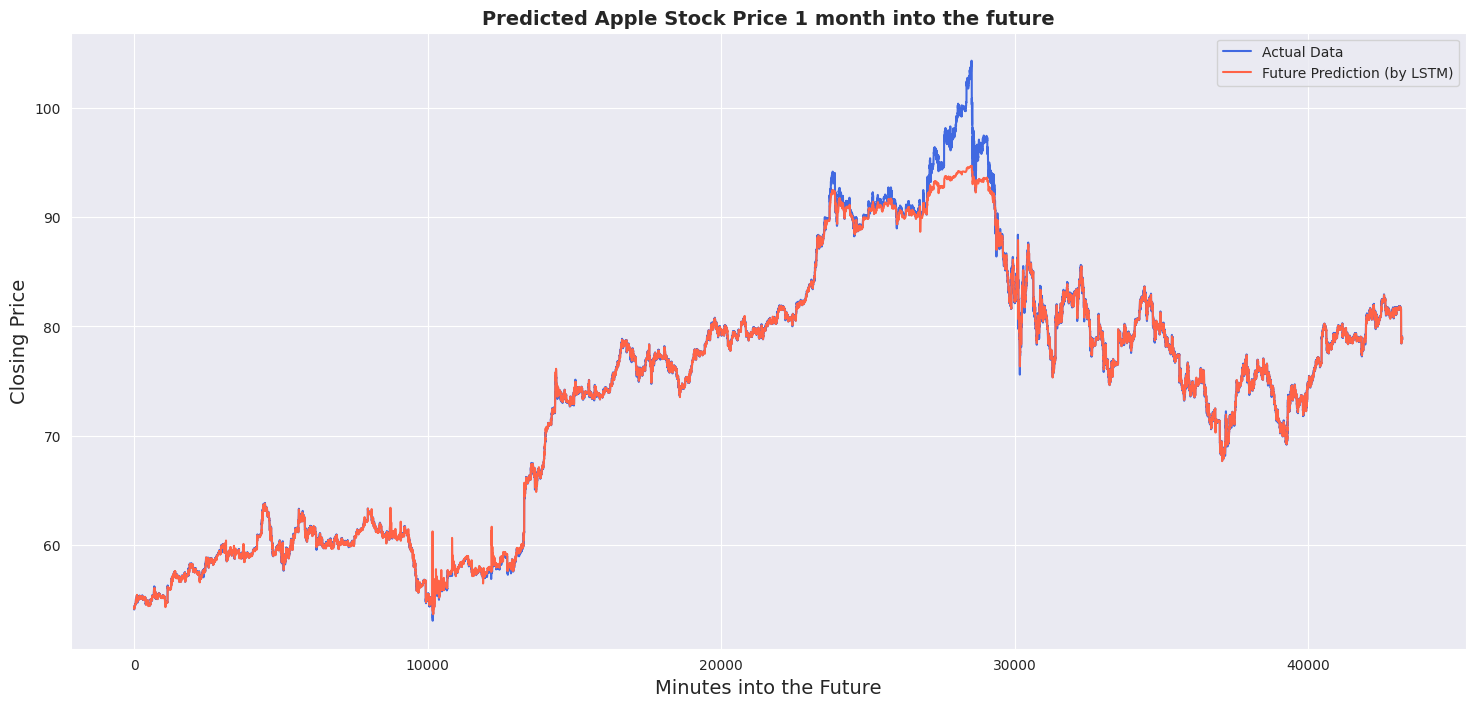

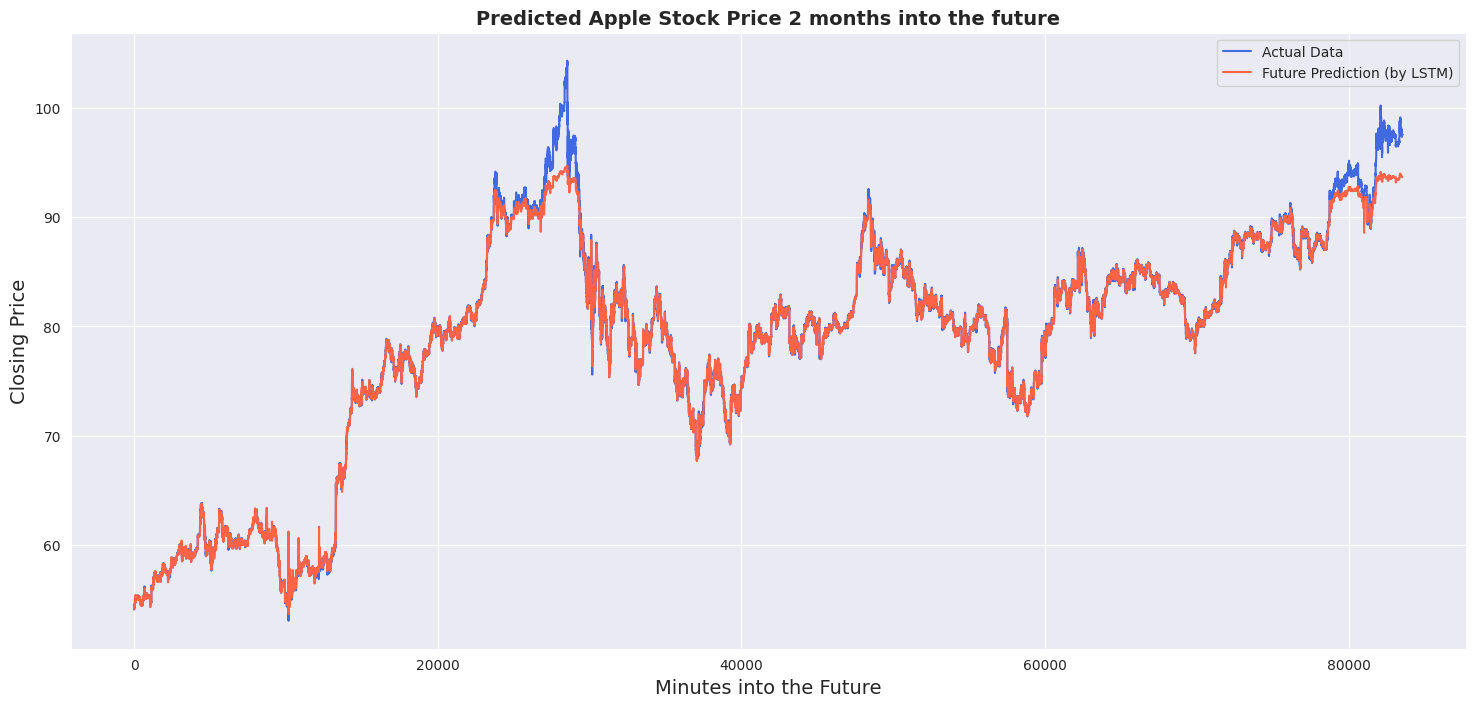

In [ ]:
times = [100, 200, 500, 24*60, 7*24*60, 14*24*60, 30*24*60, 58*24*60]
headers = ['100 minutes', '200 minutes', '500 minutes', '1 day', '1 week', '2 weeks', '1 month', '2 months']
ms_mape_vec = []
for j, i in enumerate(times):
  ms_mape_vec.append(float(predict_for_next_timeframe(ms_predict_dataloader, ms_model, i, f"Predicted Apple Stock Price {headers[j]} into the future", "Closing Price")))

### Comparisons with other methods done so far

In [ ]:
def visualize_mape(headers, *mape_vecs):
    x = np.array(range(len(headers)))
    plt.figure(figsize=(14, 5))
    plt.bar(x, mape_vecs[0], label='single input (close)', color='blue', alpha=0.7, width=0.1)
    plt.bar(x + 0.1, mape_vecs[1], label='multiple input (close, open, high, low, volume)', color='red', alpha=0.7, width=0.1)
    plt.bar(x + 0.2, mape_vecs[2], label='multiple stock (AMD + AAPL), multiple input (close, open, high, low, volume)', color='green', alpha=0.7, width=0.1)

    # Adding labels and title
    plt.xticks(x, headers)
    plt.xlabel('Minutes into the Future')
    plt.ylabel('Price Prediction Error (MAPE)')
    plt.title('Comparison of various methods')
    plt.legend()

    # Adjusting the layout for better visibility
    plt.tight_layout()

    # Show the plot
    plt.show()

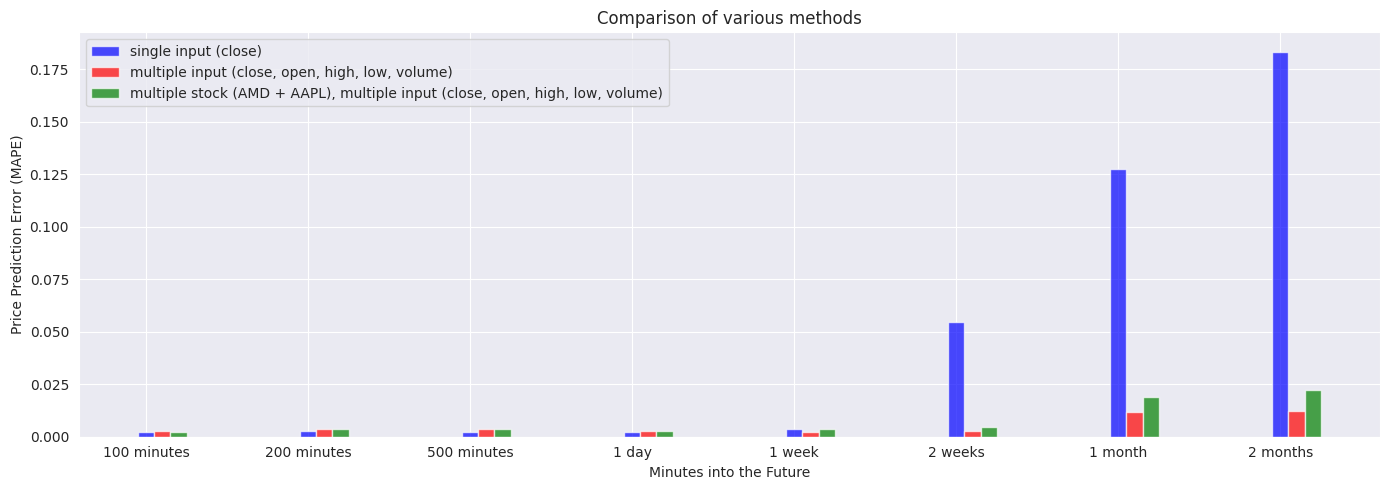

In [ ]:
visualize_mape(headers, ms_mape_vec, single_mape_vec, multiple_mape_vec)

### 9a) Inferences
- Thus we can infer that adding more than one stock leads to much more reduced error as compared to just a single input (closing price) and performs better (blue vs green)
- It is not as effective as just using the only single multiple input prices of the stock (red vs green)

#### This may be because of the loss of some data, which occurs when we try to join the two stock price data during pre-processing to synchronize the two stock prices. However the correlation of the two stocks allows it to predict much better than a single input

## 9b) Adding Day, Week and Time as inputs to see if improvement in predictions

We create a modified dataloader for training the LSTM in this case to check if adding these features improves prediction

### Strategy used to add new date time columns to the dataframe

In [ ]:
df = z_company_wise['AAPL'][['close', 'open', 'high', 'low', 'volume']]
df.head()

close      open      high       low    volume
datetime                                                             
2020-07-01 04:00:00 -2.320537 -2.317483 -2.321329 -2.316607 -0.303631
2020-07-01 04:01:00 -2.320537 -2.320557 -2.324401 -2.316607 -0.305462
2020-07-01 04:12:00 -2.309880 -2.309900 -2.313748 -2.305945 -0.301442
2020-07-01 04:13:00 -2.309880 -2.309900 -2.313748 -2.305945 -0.305462
2020-07-01 04:34:00 -2.317933 -2.317953 -2.321798 -2.314001 -0.305462

In [ ]:
df1 = df.copy()
df1.loc[:, 'day'] = df.index.day
df1.loc[:, 'week'] = df.index.isocalendar().week
df1.loc[:, 'min'] = df.index.minute
df1.loc[:, 'hour'] = df.index.hour
df1.head()

close      open      high       low    volume  day  \
datetime                                                                     
2020-07-01 04:00:00 -2.320537 -2.317483 -2.321329 -2.316607 -0.303631    1   
2020-07-01 04:01:00 -2.320537 -2.320557 -2.324401 -2.316607 -0.305462    1   
2020-07-01 04:12:00 -2.309880 -2.309900 -2.313748 -2.305945 -0.301442    1   
2020-07-01 04:13:00 -2.309880 -2.309900 -2.313748 -2.305945 -0.305462    1   
2020-07-01 04:34:00 -2.317933 -2.317953 -2.321798 -2.314001 -0.305462    1   

                     week  min  hour  
datetime                              
2020-07-01 04:00:00    27    0     4  
2020-07-01 04:01:00    27    1     4  
2020-07-01 04:12:00    27   12     4  
2020-07-01 04:13:00    27   13     4  
2020-07-01 04:34:00    27   34     4

In [ ]:
# we perform normalization
df1['day'] = df1['day'] / 31
df1['week'] = df1['week'] / 52
df1['min'] = df1['min'] / 60
df1['hour'] = df1['hour'] / 24
df1.head()

close      open      high       low    volume  \
datetime                                                                
2020-07-01 04:00:00 -2.320537 -2.317483 -2.321329 -2.316607 -0.303631   
2020-07-01 04:01:00 -2.320537 -2.320557 -2.324401 -2.316607 -0.305462   
2020-07-01 04:12:00 -2.309880 -2.309900 -2.313748 -2.305945 -0.301442   
2020-07-01 04:13:00 -2.309880 -2.309900 -2.313748 -2.305945 -0.305462   
2020-07-01 04:34:00 -2.317933 -2.317953 -2.321798 -2.314001 -0.305462   

                          day      week       min      hour  
datetime                                                     
2020-07-01 04:00:00  0.032258  0.519231  0.000000  0.166667  
2020-07-01 04:01:00  0.032258  0.519231  0.016667  0.166667  
2020-07-01 04:12:00  0.032258  0.519231  0.200000  0.166667  
2020-07-01 04:13:00  0.032258  0.519231  0.216667  0.166667  
2020-07-01 04:34:00  0.032258  0.519231  0.566667  0.166667

In [ ]:
df1.to_numpy().astype(float)[:5]

array([[-2.3205372 , -2.31748333, -2.32132866, -2.31660654, -0.30363117,
         0.03225806,  0.51923077,  0.        ,  0.16666667],
       [-2.3205372 , -2.32055688, -2.32440103, -2.31660654, -0.30546228,
         0.03225806,  0.51923077,  0.01666667,  0.16666667],
       [-2.30988017, -2.30989999, -2.31374822, -2.30594501, -0.30144235,
         0.03225806,  0.51923077,  0.2       ,  0.16666667],
       [-2.30988017, -2.30989999, -2.31374822, -2.30594501, -0.30546228,
         0.03225806,  0.51923077,  0.21666667,  0.16666667],
       [-2.31793279, -2.3179525 , -2.32179765, -2.31400103, -0.30546228,
         0.03225806,  0.51923077,  0.56666667,  0.16666667]])

### Modified Dataloader to include Date/Time columns

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'target': self.targets[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample

class LSTMTrainDataLoaderWithTime():
  def __init__(self, companies, start_timestamp, end_timestamp):
    self.companies = companies
    self.z_company_wise = {}
    self.z_price_scaler = StandardScaler()
    self.z_volume_scaler = StandardScaler()

    for i in companies:
      z_company_wise[i] = get_subset_of_dataset(i, start_date=start_timestamp, end_date=end_timestamp)
      z_company_wise[i].set_index('datetime', inplace=True)

    combined_data = pd.concat(list(z_company_wise.values()), axis=0, ignore_index=True)
    price_columns = ['open', 'high', 'low', 'close']
    volume_columns = ['volume']

    z_price_scaler.fit(combined_data[price_columns])
    z_volume_scaler.fit(combined_data[volume_columns])

    for i in companies:
      z_company_wise[i][['open', 'close', 'low', 'high']] = z_price_scaler.fit_transform(z_company_wise[i][['open', 'close', 'low', 'high']])
      z_company_wise[i]['volume'] = z_volume_scaler.fit_transform(z_company_wise[i][['volume']])


  def generate_dataset(self, company, other_companies_to_include = [], input_rows = ['close'], train_ratio=0.7, validation_ratio=0.15, test_ratio=0.15, window_size=20, batch_size=32, shuffle=False):
    # first column name in input_rows should be the stock which we want to predict, generally close
    df1 = z_company_wise[company][input_rows]

    if len(other_companies_to_include) > 0:
      for comp in other_companies_to_include:
        new_df = z_company_wise[comp][input_rows]
        df1 = df1.merge(new_df, how='inner', on='datetime')

    df = df1.copy()

    df.loc[:, 'day'] = df.index.day
    df.loc[:, 'week'] = df.index.isocalendar().week
    df.loc[:, 'min'] = df.index.minute
    df.loc[:, 'hour'] = df.index.hour
    df['day'] = df['day'] / 31
    df['week'] = df['week'] / 52
    df['min'] = df['min'] / 60
    df['hour'] = df['hour'] / 24

    df_np = df.to_numpy().astype(float)
    print(df_np.shape)
    data = []

    for index in range(len(df_np) - window_size):
        data.append(df_np[index : index + window_size])

    data = np.array(data)
    test_set_size = int(np.round(test_ratio*data.shape[0]))
    validation_set_size = int(np.round(validation_ratio*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size) - (validation_set_size)

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,0].reshape(-1, 1)

    x_test = data[train_set_size: train_set_size + validation_set_size,:-1,:]
    y_test = data[train_set_size: train_set_size + validation_set_size,-1,0].reshape(-1, 1)

    x_valid = data[train_set_size + validation_set_size : ,:-1, :]
    y_valid = data[train_set_size + validation_set_size : ,-1,0].reshape(-1, 1)

    self.x_train = torch.from_numpy(x_train).type(torch.Tensor)
    self.x_test = torch.from_numpy(x_test).type(torch.Tensor)
    self.y_train = torch.from_numpy(y_train).type(torch.Tensor)
    self.y_test = torch.from_numpy(y_test).type(torch.Tensor)
    self.x_valid = torch.from_numpy(x_valid).type(torch.Tensor)
    self.y_valid = torch.from_numpy(y_valid).type(torch.Tensor)

    self.train_data = TimeSeriesDataset(self.x_train, self.y_train)
    self.test_data = TimeSeriesDataset(self.x_test, self.y_test)
    self.valid_data = TimeSeriesDataset(self.x_valid, self.y_valid)

    print("X : train_shape:",x_train.shape, "test_shape:", x_test.shape, "valid_shape:", x_valid.shape)
    print("Y : train_shape", y_train.shape, "test_shape:", y_test.shape, "valid_shape:", y_valid.shape)

    self.train_dataloader = DataLoader(self.train_data, batch_size=batch_size, shuffle=shuffle)
    self.test_dataloader = DataLoader(self.test_data, batch_size=batch_size, shuffle=shuffle)
    self.valid_dataloader = DataLoader(self.valid_data, batch_size=batch_size, shuffle=shuffle)
    print("Dataloader Created Successfully")

### Modified Predict Dataloader

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class LSTMPredictDataLoaderWithTime():

  def __init__(self, companies, start_timestamp, end_timestamp):
    self.companies = companies
    self.z_company_wise = {}
    self.z_price_scaler = StandardScaler()
    self.z_volume_scaler = StandardScaler()

    for i in companies:
      z_company_wise[i] = get_subset_of_dataset(i, start_date=start_timestamp, end_date=end_timestamp)
      z_company_wise[i].set_index('datetime', inplace=True)

    combined_data = pd.concat(list(z_company_wise.values()), axis=0, ignore_index=True)
    price_columns = ['open', 'high', 'low', 'close']
    volume_columns = ['volume']

    z_price_scaler.fit(combined_data[price_columns])
    z_volume_scaler.fit(combined_data[volume_columns])

    for i in companies:
      z_company_wise[i][['open', 'close', 'low', 'high']] = z_price_scaler.fit_transform(z_company_wise[i][['open', 'close', 'low', 'high']])
      z_company_wise[i]['volume'] = z_volume_scaler.fit_transform(z_company_wise[i][['volume']])


  def generate_dataset(self, company, other_companies_to_include = [], input_rows = ['close'], window_size=20):
    # first column name in input_rows should be the stock which we want to predict, generally close
    df1 = z_company_wise[company][input_rows]

    if len(other_companies_to_include) > 0:
      for comp in other_companies_to_include:
        new_df = z_company_wise[comp][input_rows]
        df1 = df1.merge(new_df, how='inner', on='datetime')

    df = df1.copy()

    df.loc[:, 'day'] = df.index.day
    df.loc[:, 'week'] = df.index.isocalendar().week
    df.loc[:, 'min'] = df.index.minute
    df.loc[:, 'hour'] = df.index.hour
    df['day'] = df['day'] / 31
    df['week'] = df['week'] / 52
    df['min'] = df['min'] / 60
    df['hour'] = df['hour'] / 24

    df_np = df.to_numpy().astype(float)
    data = []

    for index in range(len(df_np) - window_size):
        data.append(df_np[index : index + window_size])

    data = np.array(data)

    x_value = data[:,:-1,:]
    y_value = data[:,-1,0].reshape(-1, 1)

    self.x_value = torch.from_numpy(x_value).type(torch.Tensor)
    self.y_value = torch.from_numpy(y_value).type(torch.Tensor)
    print("Dataloader Created Successfully")
    print("X : value_shape:",x_value.shape)
    print("Y : value_shape", y_value.shape)

### Predicting Close Price for Single Company (AAPL) only using its Multiple columns as input and also added new Date/Time columns
- We will train the data on the data for a quarter (4 months) and predict it for the next quarter

In [ ]:
dt_dataloader = LSTMTrainDataLoaderWithTime(['AAPL'], '2020-01-01 00:00:00', '2020-04-30 23:59:59')

In [ ]:
dt_dataloader.generate_dataset('AAPL', [], ['close', 'open', 'high', 'low', 'volume'], batch_size=batch_size, shuffle=True, window_size=25)

(65672, 9)
X : train_shape: (45953, 24, 9) test_shape: (9847, 24, 9) valid_shape: (9847, 24, 9)
Y : train_shape (45953, 1) test_shape: (9847, 1) valid_shape: (9847, 1)
Dataloader Created Successfully


In [ ]:
input_dim = 9
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100
batch_size = 64

In [ ]:
dt_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adagrad(dt_model.parameters(), lr=0.005)
dt_model

LSTM(
  (lstm): LSTM(9, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
hist = train_model(dt_model, num_epochs, dt_dataloader, 10)

Epoch  0 Train MSE:  0.012040427213242298 Validation MSE:  0.0001623499685570064 Time taken for Epoch: 5.986796617507935
Epoch  1 Train MSE:  0.0009935417786364927 Validation MSE:  0.0001134333859414111 Time taken for Epoch: 7.9868340492248535
Epoch  2 Train MSE:  0.000901295620201982 Validation MSE:  0.0009782379357110558 Time taken for Epoch: 6.750884056091309
Epoch  3 Train MSE:  0.000840363696614871 Validation MSE:  0.00029291153169121794 Time taken for Epoch: 10.293738603591919
Epoch  4 Train MSE:  0.000800924505649027 Validation MSE:  7.683797967338466e-05 Time taken for Epoch: 7.0840582847595215
Epoch  5 Train MSE:  0.0007710139638813685 Validation MSE:  7.062719189526282e-05 Time taken for Epoch: 4.004336595535278
Epoch  6 Train MSE:  0.000747186611846908 Validation MSE:  9.469870042045482e-05 Time taken for Epoch: 6.501880168914795
Epoch  7 Train MSE:  0.0007291909553996587 Validation MSE:  6.61797871917126e-05 Time taken for Epoch: 4.328976631164551
Epoch  8 Train MSE:  0.000

In [ ]:
torch.save(dt_model, 'multiple_feature_with_datetime.pt')

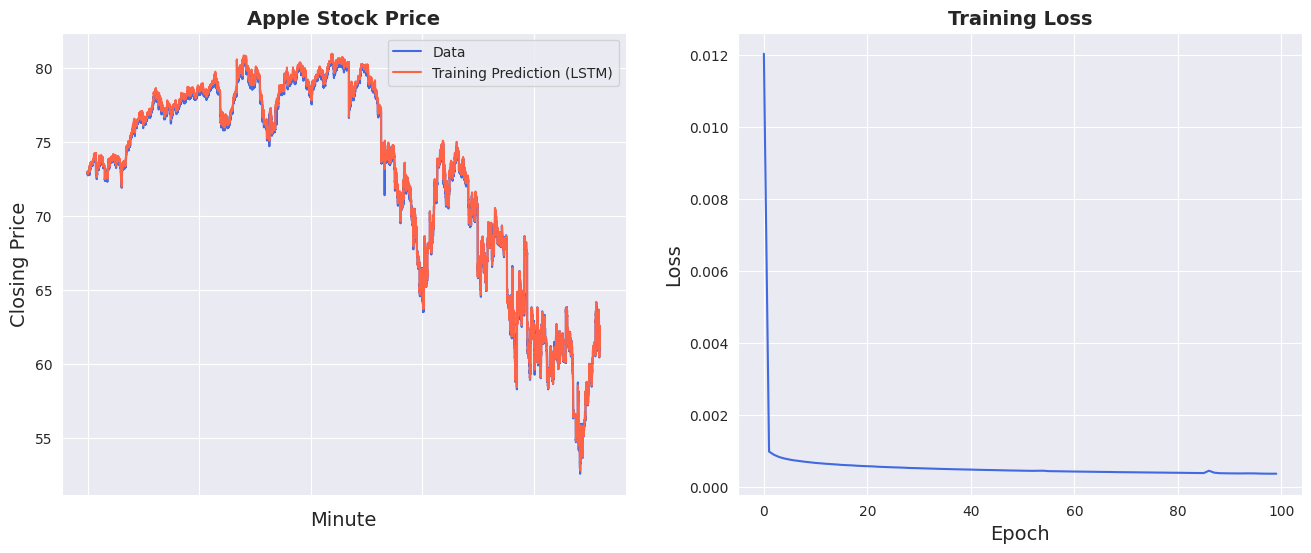

In [ ]:
visualize_train_results(dt_model, dt_dataloader, "Apple Stock Price", "Closing Price")

Testing MSE Loss : 0.00028312241192907095


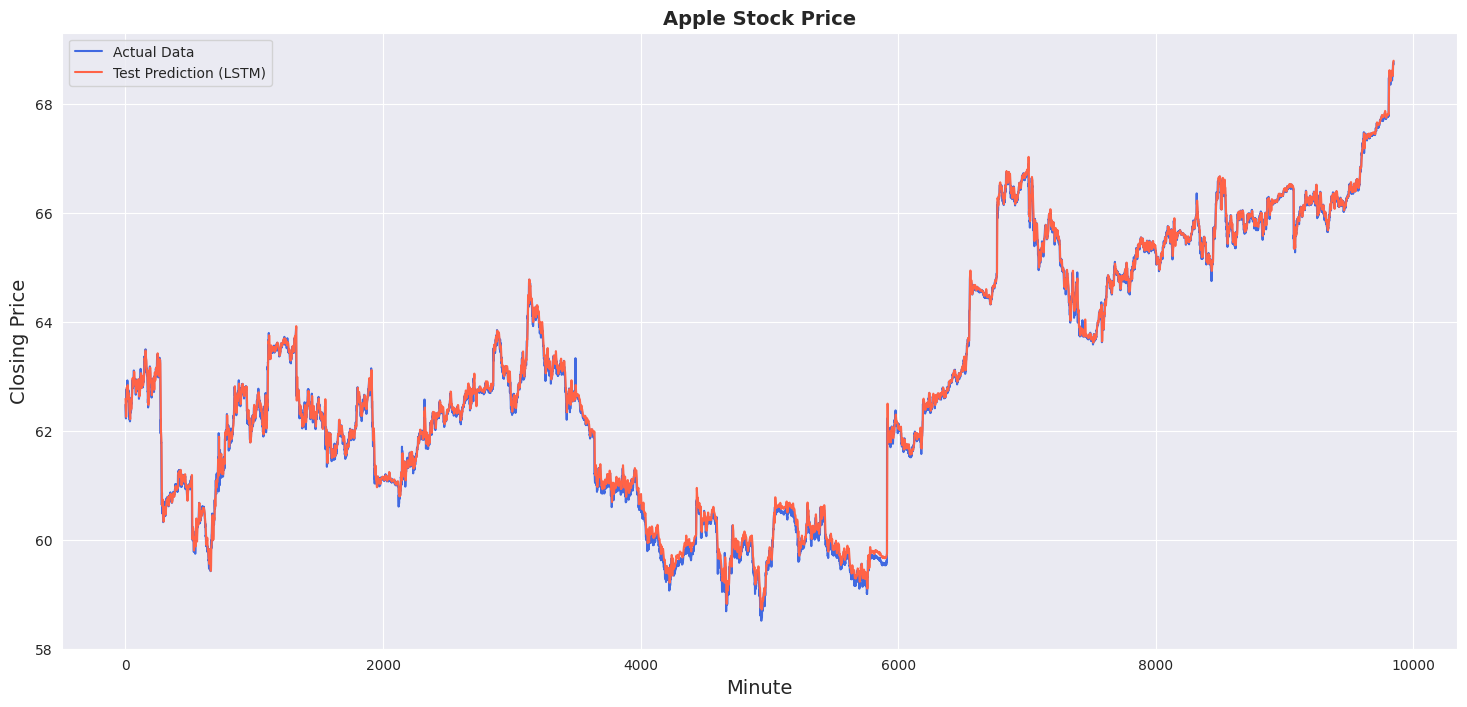

In [ ]:
visualize_test_results(dt_model, dt_dataloader, "Apple Stock Price", "Closing Price")

In [ ]:
# get data for next quarter (next four month)
dt_predict_dataloader = LSTMPredictDataLoaderWithTime(['AAPL'], '2020-05-01 00:00:00', '2020-09-01 23:59:59')
dt_predict_dataloader.generate_dataset('AAPL', [], input_rows=['close', 'open', 'high', 'low', 'volume'], window_size=25)

Dataloader Created Successfully
X : value_shape: (63688, 24, 9)
Y : value_shape (63688, 1)


Mean Absolute Percentage Error : 0.008762471377849579
Mean Absolute Percentage Error : 0.008994748815894127
Mean Absolute Percentage Error : 0.009487907402217388
Mean Absolute Percentage Error : 0.008878816850483418
Mean Absolute Percentage Error : 0.005094199441373348
Mean Absolute Percentage Error : 0.006293136160820723
Mean Absolute Percentage Error : 0.19902177155017853
Mean Absolute Percentage Error : 0.1807771474123001


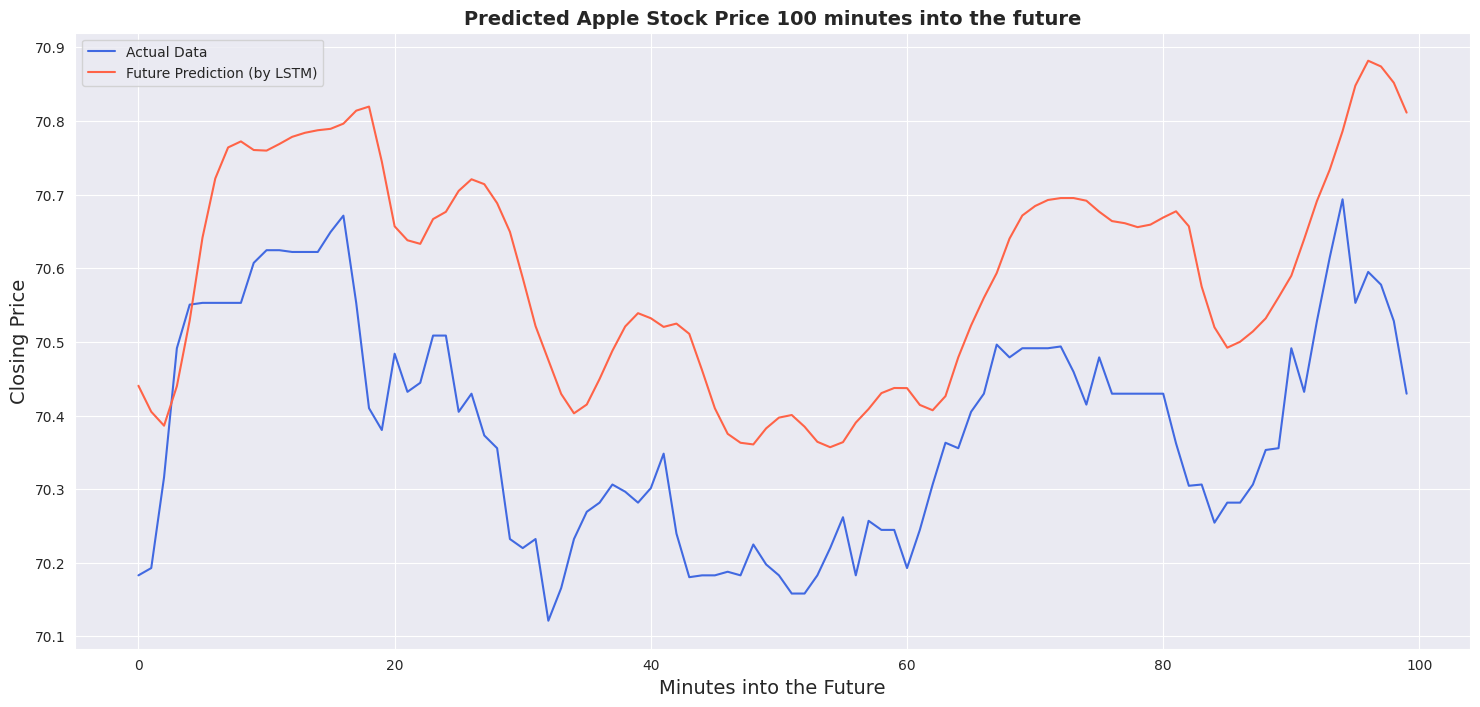

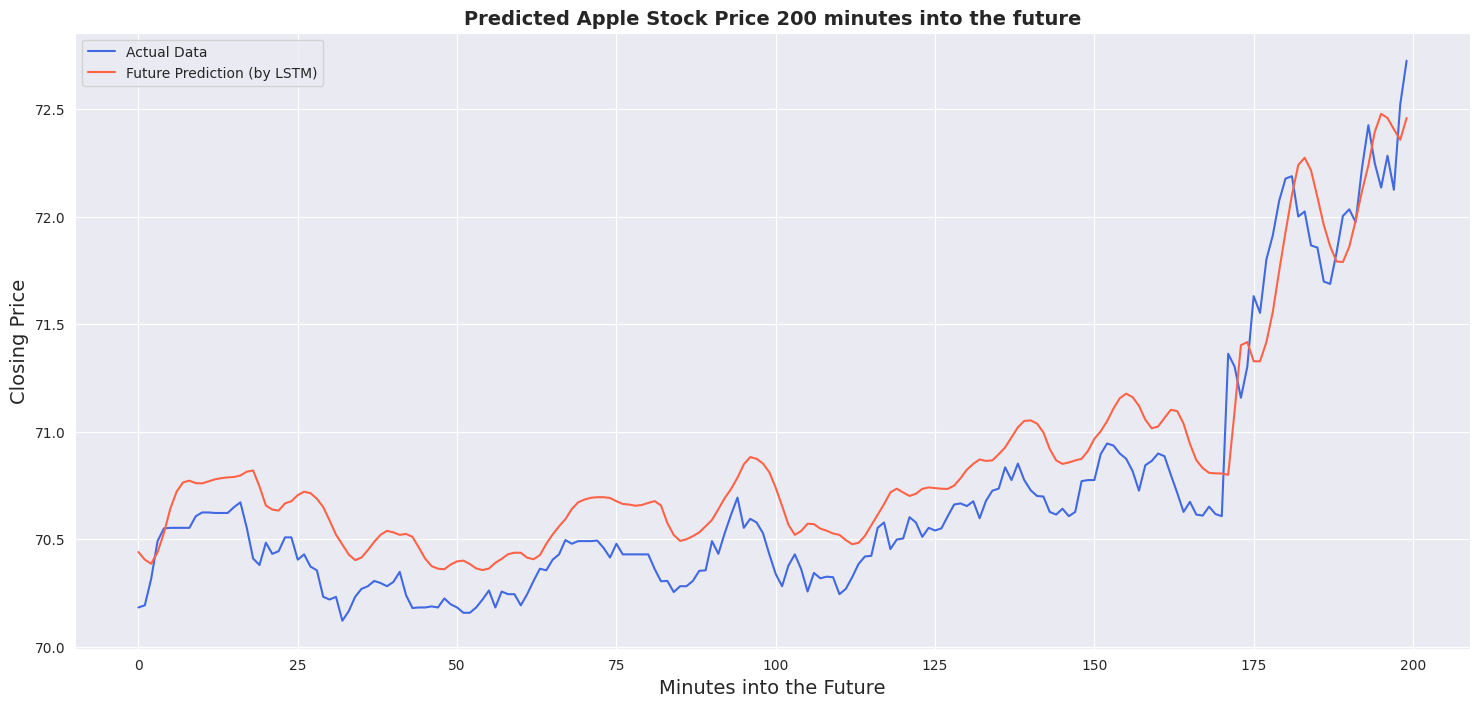

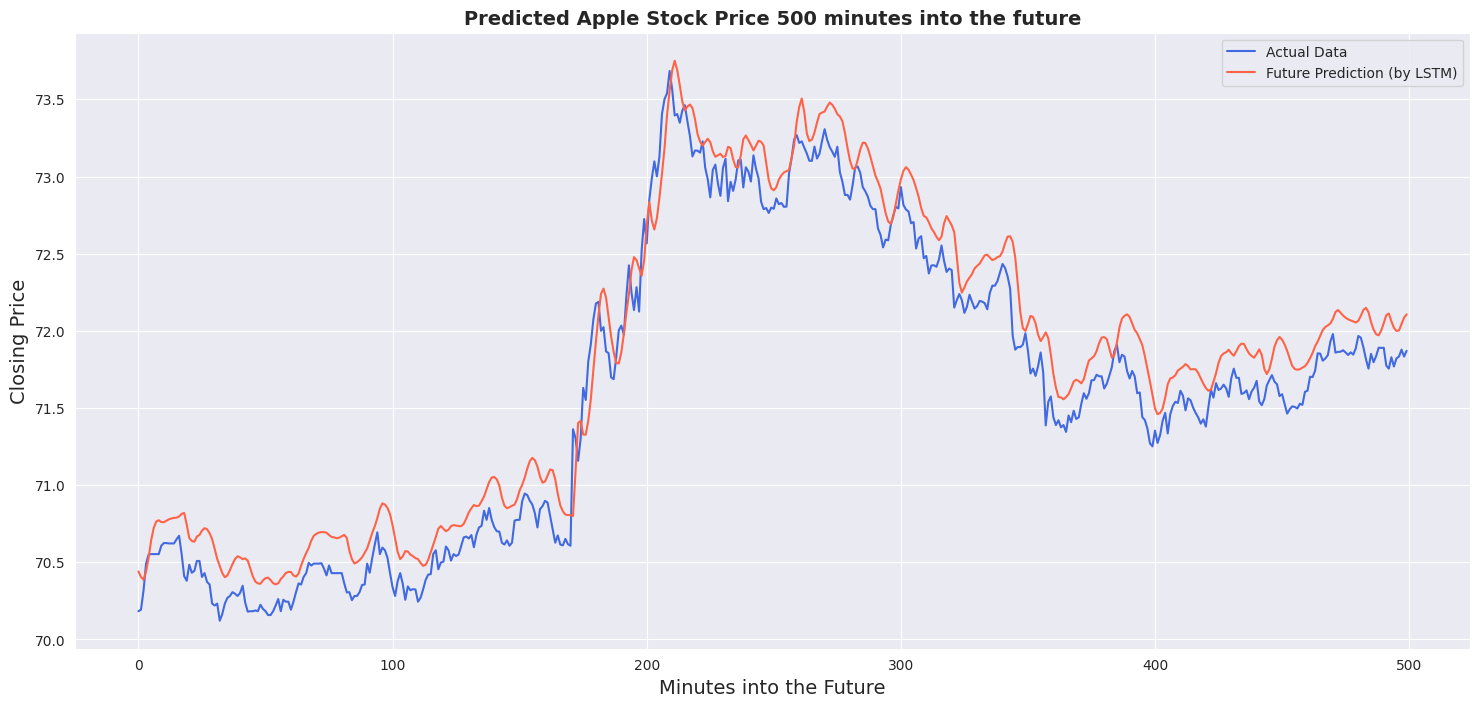

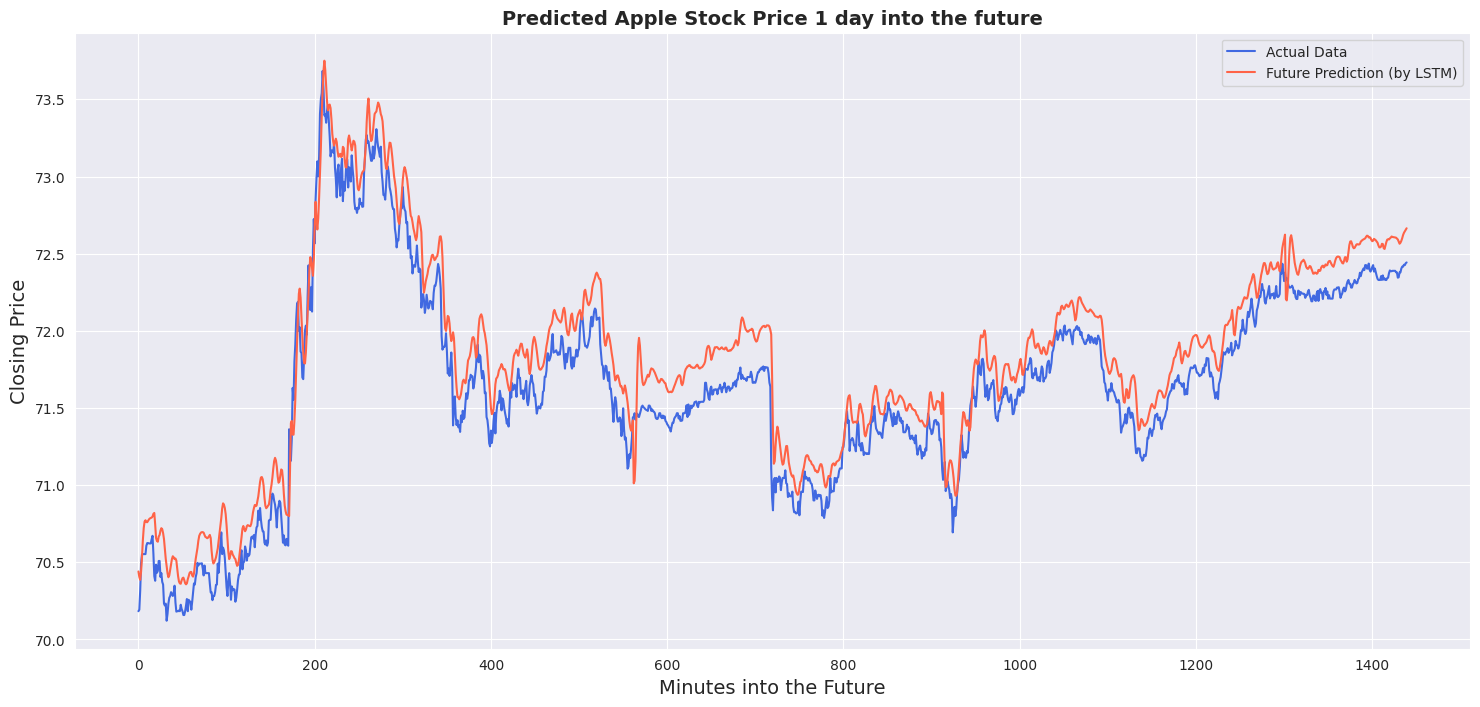

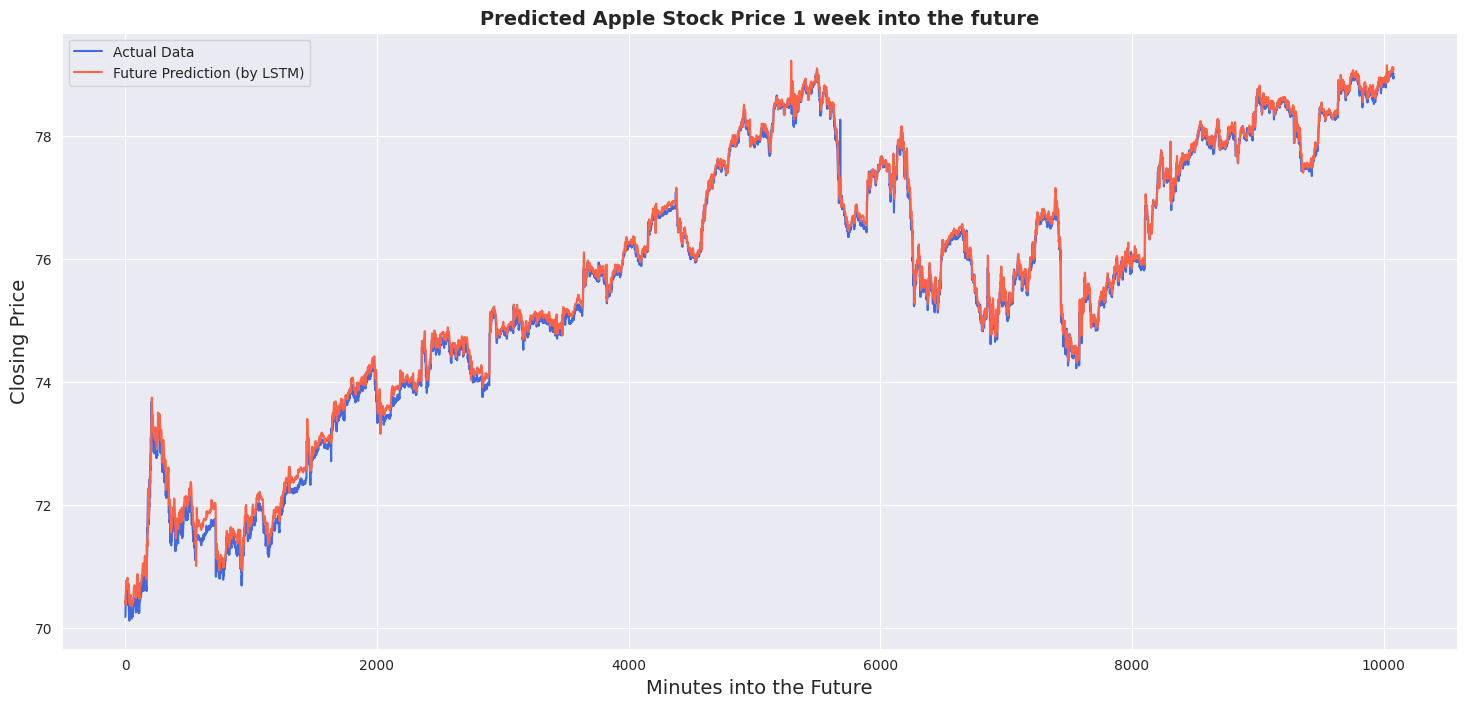

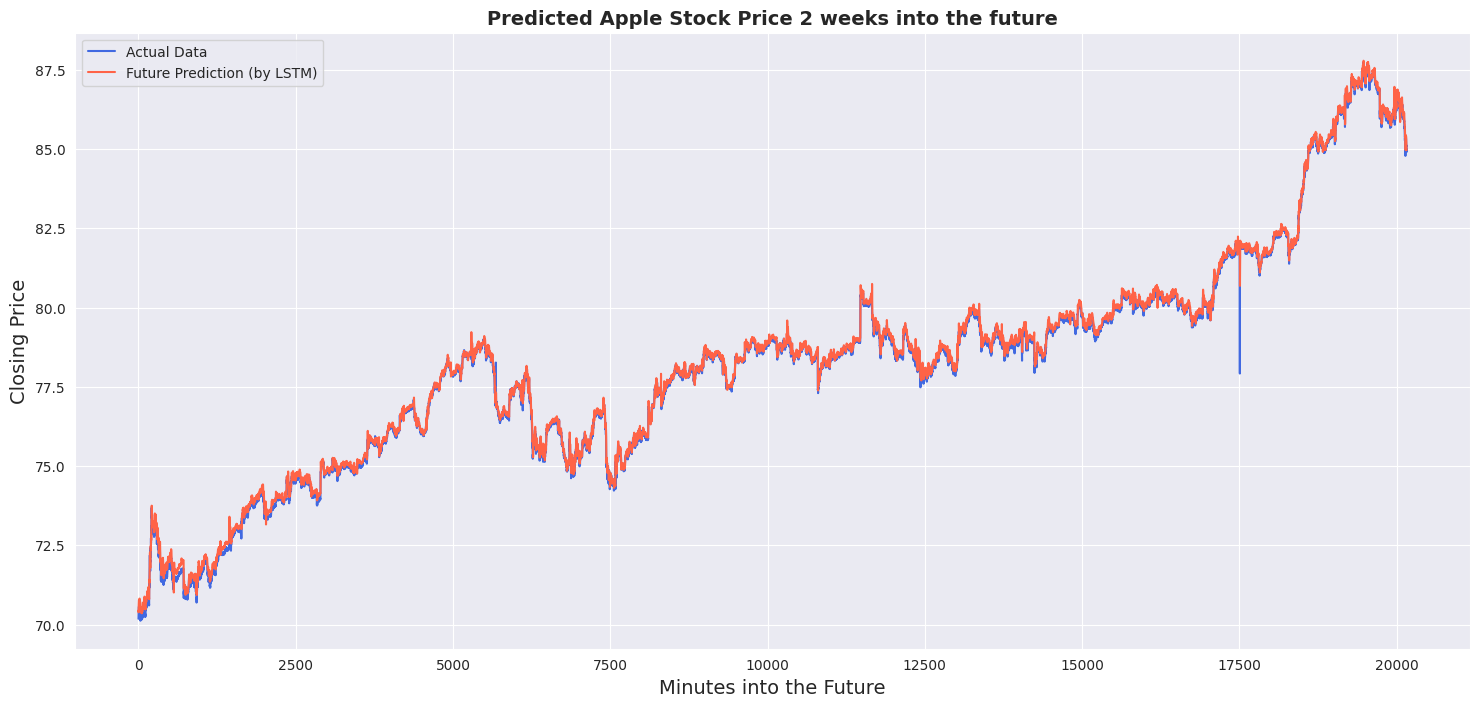

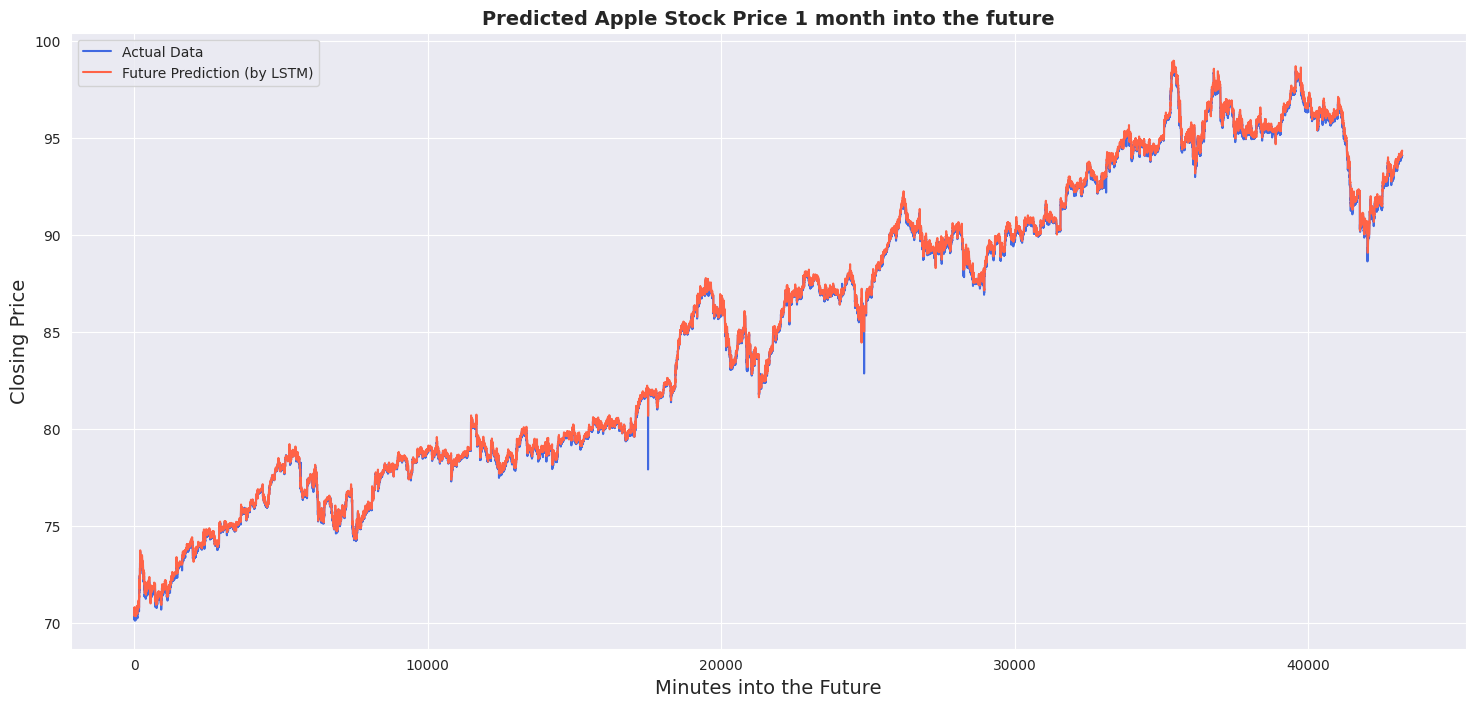

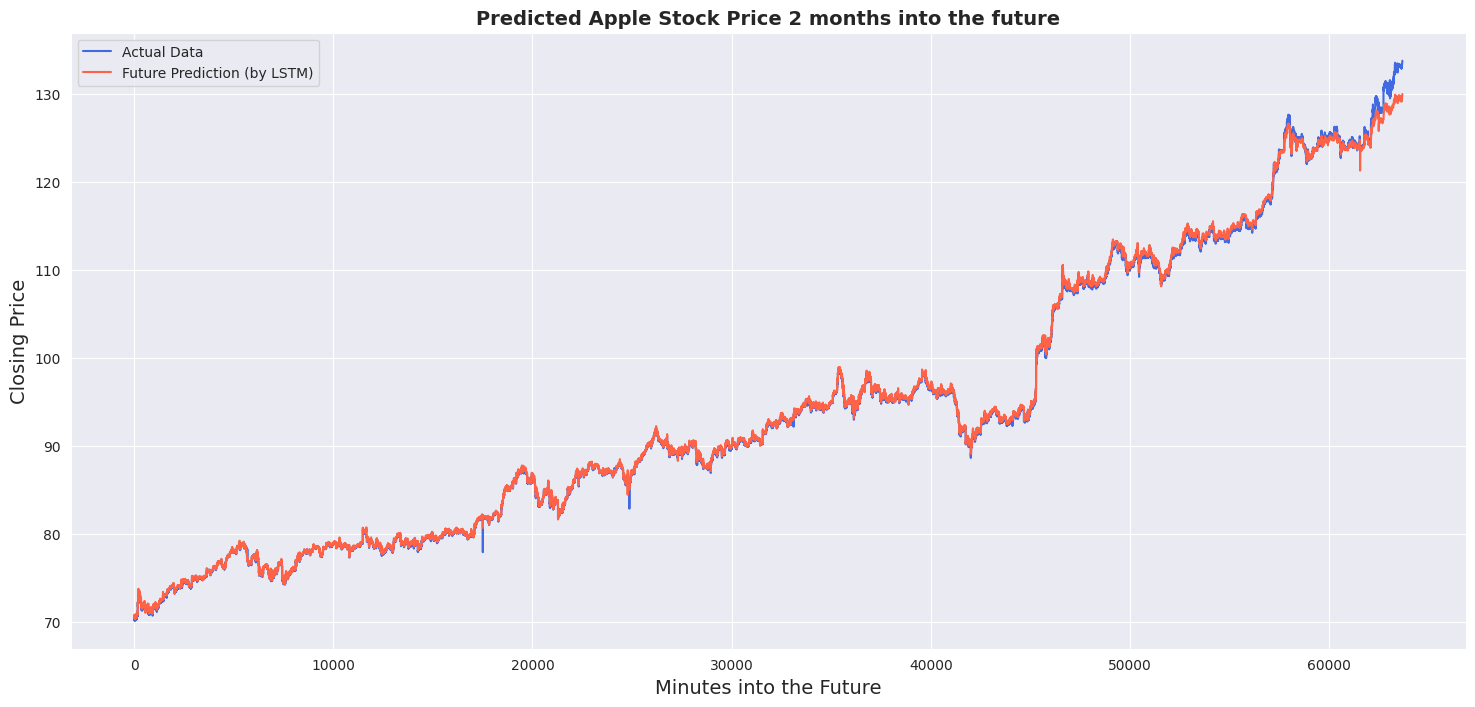

In [ ]:
times = [100, 200, 500, 24*60, 7*24*60, 14*24*60, 30*24*60, 58*24*60]
headers = ['100 minutes', '200 minutes', '500 minutes', '1 day', '1 week', '2 weeks', '1 month', '2 months']
dt_mape_vec = []
for j, i in enumerate(times):
  dt_mape_vec.append(float(predict_for_next_timeframe(dt_predict_dataloader, dt_model, i, f"Predicted Apple Stock Price {headers[j]} into the future", "Closing Price")))

### Comparisons with other methods done so far

In [ ]:
def visualize_mape(headers, *mape_vecs):
    x = np.array(range(len(headers)))
    plt.figure(figsize=(14, 5))
    plt.bar(x, mape_vecs[0], label='single input (close)', color='blue', alpha=0.7, width=0.1)
    plt.bar(x + 0.1, mape_vecs[1], label='multiple input (close, open, high, low, volume)', color='red', alpha=0.7, width=0.1)
    plt.bar(x + 0.2, mape_vecs[2], label='multiple stock (AMD + AAPL), multiple input (close, open, high, low, volume)', color='green', alpha=0.7, width=0.1)
    plt.bar(x + 0.3, mape_vecs[3], label='multiple input (close, open, high, low, volume), with datetime data', color='orange', alpha=0.7, width=0.1)

    # Adding labels and title
    plt.xticks(x, headers)
    plt.xlabel('Minutes into the Future')
    plt.ylabel('Price Prediction Error (MAPE)')
    plt.title('Comparison of various methods')
    plt.legend()

    # Adjusting the layout for better visibility
    plt.tight_layout()

    # Show the plot
    plt.show()

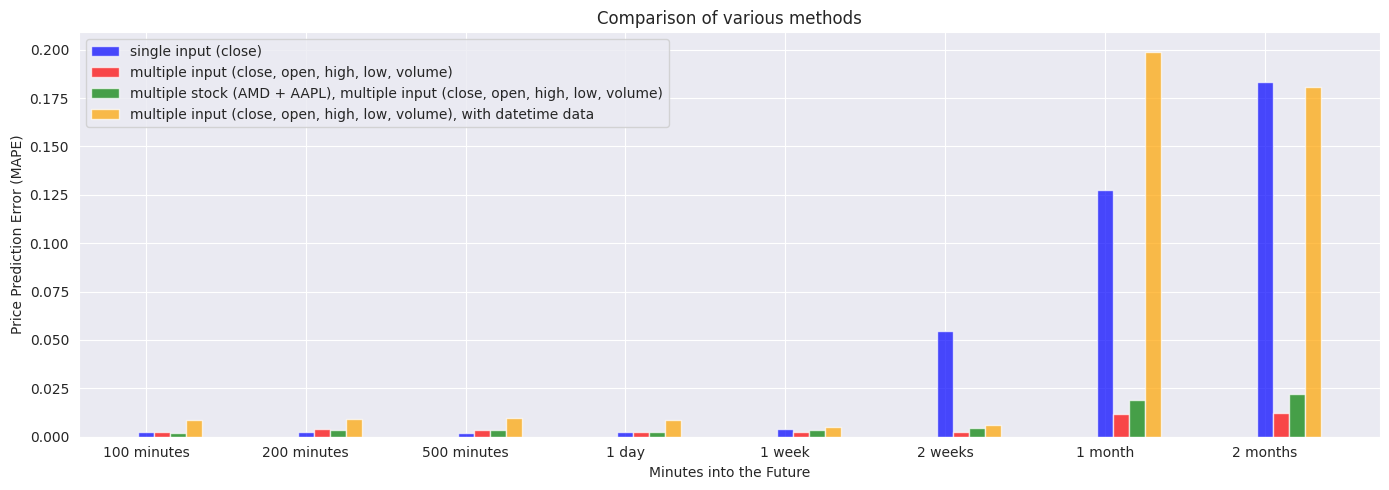

In [ ]:
visualize_mape(headers, ms_mape_vec, single_mape_vec, multiple_mape_vec, dt_mape_vec)

## 9b) Inferences
- Thus we see that adding the time data improves the predictions for shorter timeframe since last trained, that is upto 2 weeks (where it even performs better than single input model). However the model deteriorates even worse than multiple input after considerable about of time not training (1-2 months)
- It performs poorly compared to the models with "multiple input single stock" and "multiple input multiple stock"

### The conclusion is that amongst the various models we implemented in this assignment, the most robust and versatile one is "multiple input, single stock" followed by "multiple input, multiple stock".